# Dipsacales Angiosperm353 stats

## 0. Set up
First I'll import the modules needed and define any functions.

In [1]:
# Core
import re, os, glob, sys, string, random
import pandas as pd
from pathlib import Path
from itertools import cycle, islice, combinations
import numpy as np
from collections import deque
# Plotting
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.lines as mlines
from matplotlib import colors as mcolors
from matplotlib import colorbar
import seaborn as sns
# Stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.cluster import KMeans
import scipy.stats as stats
import scipy.cluster as cluster
import spm1d as spm
import scikit_posthocs as skph
import pingouin as pg
# Bio
import toytree, toyplot

The normal test below is just a convenient way of printing the results of normality testing, it doesn't do anything special.

In [2]:
def normal_test(x, alpha, log=False):   
    if log:
        x = np.log(x)
    k2, p = stats.normaltest(x)
    print("p = {:g}".format(p))
    if p < alpha:
         print("The null hypothesis can be rejected. Data are not-normal.")
    else:
         print("The null hypothesis cannot be rejected. Data are normal.")
    return k2, p

## 1. Import and wrangle data
I'll start with the length statistics.

In [12]:
raw_353 = pd.read_csv("./Gilman_seq_lengths.txt", sep='\t')#[1:]
raw_353.columns = ["species"] + ["locus{}".format(c) for c in pd.read_csv("./Gilman_seq_lengths.txt", sep="\t").columns[1:]]
meanlen = raw_353.iloc[0]
raw_353 = raw_353.iloc[1:]
raw_353 = raw_353.sort_values(by="species")
raw_353 = raw_353.reset_index(drop=True)
raw_353["species"] = [s.replace("_", " ") for s in raw_353["species"]]
raw_353

species  locus6528  locus5821  locus5822  \
0                        Abelia uniflora        282        228        150   
1   Acanthocalyx nepalensis ssp delevaya        291        297         96   
2                    Adoxa moschatellina        207        165        495   
3                    Bassecoia siamensis          0        168        234   
4                      Centranthus ruber          0        240          0   
..                                   ...        ...        ...        ...   
91                  Viburnum taiwanianum          0          0          0   
92                   Viburnum vernicosum        261        162        432   
93                       Weigela florida          0        162        345   
94                       Zabelia dielsii        207        165        375   
95                     Zabelia tyaihyoni          0        165        150   

    locus5980  locus5981  locus6955  locus6150  locus5460  locus5463  ...  \
0           0          0          0          0        258          0  ...   
1         444        699          0        249        411        408  ...   
2         393          0          0        141        327        291  ...   
3         291          0          0        309        261        153  ...   
4         396        474          0        333          0        174  ...   
..        ...        ...        ...        ...        ...        ...  ...   
91          0          0          0          0        174          0  ...   
92        189        207        336          0        174        276  ...   
93        189        447        336        336          0        318  ...   
94        246        477        336        393        411        288  ...   
95        195          0          0        285        348        174  ...   

    locus6782  locus5733  locus6544  locus5639  locus6540  locus6460  \
0         366          0        150        174        135          0   
1         432          0       1284        738        135          0   
2         255          0        747          0        393        657   
3           0        108       1170        420        213        195   
4         432        147       1500        522        261        639   
..        ...        ...        ...        ...        ...        ...   
91          0          0          0          0          0          0   
92          0          0        225        174          0        609   
93        336          0        828        180        135        897   
94        480          0       1743        426        135        621   
95        414          0        327        426        135          0   

    locus6462  locus7583  locus4992  locus6238  
0         246        183        939        507  
1         261        123       1743        171  
2         198          0       1431        690  
3         171          0       1038        735  
4         171        207       1134        318  
..        ...        ...        ...        ...  
91          0          0          0          0  
92        420          0       1128        537  
93        669        219       1527        702  
94        723        168       1566        663  
95        513        174        804        447  

[96 rows x 354 columns]

In [13]:
percent_353 = raw_353[[c for c in raw_353.columns if c.startswith("locus")]]/list(meanlen[1:])
percent_353.index = raw_353["species"]
percent_353

locus6528  locus5821  locus5822  \
species                                                                 
Abelia uniflora                        0.658879   0.367150   0.208914   
Acanthocalyx nepalensis ssp delevaya   0.679907   0.478261   0.133705   
Adoxa moschatellina                    0.483645   0.265700   0.689415   
Bassecoia siamensis                    0.000000   0.270531   0.325905   
Centranthus ruber                      0.000000   0.386473   0.000000   
...                                         ...        ...        ...   
Viburnum taiwanianum                   0.000000   0.000000   0.000000   
Viburnum vernicosum                    0.609813   0.260870   0.601671   
Weigela florida                        0.000000   0.260870   0.480501   
Zabelia dielsii                        0.483645   0.265700   0.522284   
Zabelia tyaihyoni                      0.000000   0.265700   0.208914   

                                      locus5980  locus5981  locus6955  \
species                                                                 
Abelia uniflora                        0.000000   0.000000   0.000000   
Acanthocalyx nepalensis ssp delevaya   0.713826   0.800687   0.000000   
Adoxa moschatellina                    0.631833   0.000000   0.000000   
Bassecoia siamensis                    0.467846   0.000000   0.000000   
Centranthus ruber                      0.636656   0.542955   0.000000   
...                                         ...        ...        ...   
Viburnum taiwanianum                   0.000000   0.000000   0.000000   
Viburnum vernicosum                    0.303859   0.237113   0.994083   
Weigela florida                        0.303859   0.512027   0.994083   
Zabelia dielsii                        0.395498   0.546392   0.994083   
Zabelia tyaihyoni                      0.313505   0.000000   0.000000   

                                      locus6150  locus5460  locus5463  \
species                                                                 
Abelia uniflora                        0.000000      0.688   0.000000   
Acanthocalyx nepalensis ssp delevaya   0.383077      1.096   0.904656   
Adoxa moschatellina                    0.216923      0.872   0.645233   
Bassecoia siamensis                    0.475385      0.696   0.339246   
Centranthus ruber                      0.512308      0.000   0.385809   
...                                         ...        ...        ...   
Viburnum taiwanianum                   0.000000      0.464   0.000000   
Viburnum vernicosum                    0.000000      0.464   0.611973   
Weigela florida                        0.516923      0.000   0.705100   
Zabelia dielsii                        0.604615      1.096   0.638581   
Zabelia tyaihyoni                      0.438462      0.928   0.385809   

                                      locus5464  ...  locus6782  locus5733  \
species                                          ...                         
Abelia uniflora                        0.000000  ...   0.903704   0.000000   
Acanthocalyx nepalensis ssp delevaya   0.185455  ...   1.066667   0.000000   
Adoxa moschatellina                    0.123636  ...   0.629630   0.000000   
Bassecoia siamensis                    0.269091  ...   0.000000   0.210938   
Centranthus ruber                      0.298182  ...   1.066667   0.287109   
...                                         ...  ...        ...        ...   
Viburnum taiwanianum                   0.000000  ...   0.000000   0.000000   
Viburnum vernicosum                    0.130909  ...   0.000000   0.000000   
Weigela florida                        0.000000  ...   0.829630   0.000000   
Zabelia dielsii                        0.414545  ...   1.185185   0.000000   
Zabelia tyaihyoni                      0.000000  ...   1.022222   0.000000   

                                      locus6544  locus5639  locus6540  \
species                                                                 
Abelia uniflora            

In [14]:
concentration_norm = pd.read_csv("./Dipsacales_Baits_DNA/02_Concentration_normalization.csv")
concentration_norm["species"] = sorted(percent_353.index)
concentration_norm = concentration_norm[["species", "Concentration (ng/uL)", "Total mass (ng)", "Genus"]]
concentration_norm.columns = ["species", "initial_concentration", "initial_ng_DNA", "genus"]
concentration_norm["species"] = [s.replace("_", " ") for s in concentration_norm["species"]]
concentration_norm

species  initial_concentration  \
0                        Abelia uniflora                   4.30   
1   Acanthocalyx nepalensis ssp delevaya                  95.00   
2                    Adoxa moschatellina                 101.00   
3                    Bassecoia siamensis                   2.60   
4                      Centranthus ruber                  11.60   
..                                   ...                    ...   
91                  Viburnum taiwanianum                   5.08   
92                   Viburnum vernicosum                  12.70   
93                       Weigela florida                  36.60   
94                       Zabelia dielsii                   9.26   
95                     Zabelia tyaihyoni                1040.00   

    initial_ng_DNA         genus  
0           225.75        Abelia  
1          9500.00  Acanthocalyx  
2         43430.00         Adoxa  
3            26.00     Bassecoia  
4           754.00   Centranthus  
..             ...           ...  
91          406.40       Weigela  
92          952.50       Zabelia  
93         3660.00       Zabelia  
94          277.80          Ilex  
95        20800.00   Paracryphia  

[96 rows x 4 columns]

In [17]:
post_amp = pd.read_csv("./Dipsacales_Baits_DNA/04_Post-amplification_quantification.csv")
post_amp["species"] = post_amp[["Genus", "Species"]].agg("_".join, axis=1)
post_amp["species"] = post_amp["species"].str.replace(".", "")
post_amp["species"] = post_amp["species"].str.replace(" ", "_")
post_amp = post_amp[["species", "Cycles", "Total DNA (ng).1", "Pool Number"]]
post_amp.columns = ["species", "cycles", "post_amp_ng_DNA", "pool"]
post_amp["species"] = [s.replace("_", " ") for s in post_amp["species"]]
post_amp["species"] = [taxonomy_update[s] if s in taxonomy_update.keys() else s for s in raw_353["species"]]
# post_amp["post_amp_ng_DNA"] = post_amp["post_amp_ng_DNA"].astype(float)
post_amp

species  cycles post_amp_ng_DNA  pool
0                        Abelia uniflora      12          1022.2     1
1   Acanthocalyx nepalensis ssp delevaya      12           950.0     1
2                    Adoxa moschatellina      12           923.4     1
3                    Bassecoia siamensis      12           904.4     1
4                      Centranthus ruber      12           801.8     1
..                                   ...     ...             ...   ...
91                  Viburnum taiwanianum      12           934.8     8
92                   Viburnum vernicosum      12           646.0     8
93                       Weigela florida      12           551.0     8
94                       Zabelia dielsii      12           471.2     8
95                     Zabelia tyaihyoni      16           207.1     8

[96 rows x 4 columns]

In [18]:
[p for p in post_amp.post_amp_ng_DNA]

['1022.2',
 '950.0',
 '923.4',
 '904.4',
 '801.8',
 '786.6',
 '786.6',
 '649.8',
 '634.6',
 '627.0',
 '611.8',
 '296.4',
 '2090',
 '1801.2',
 '1656.8',
 '1626.4',
 '1626.4',
 '1561.8',
 '1360.4',
 '1269.2',
 '1075.4',
 '942.4',
 '520.6',
 'LOW',
 '1808.8',
 '1466.8',
 '1360.4',
 '1250.2',
 '1155.2',
 '1022.2',
 '1018.4',
 '995.6',
 '824.6',
 '562.4',
 '351.5',
 '75.62',
 '2166',
 '1740.4',
 '1683.4',
 '1615.0',
 '1588.4',
 '1573.2',
 '1482.0',
 '1421.2',
 '1200.8',
 '615.6',
 '267.9',
 'LOW',
 '1406.0',
 '1390.8',
 '1333.8',
 '1113.4',
 '1071.6',
 '969.0',
 '969.0',
 '904.4',
 '801.8',
 '558.6',
 '326.8',
 '203.3',
 '1687.2',
 '1485.8',
 '1444.0',
 '1098.2',
 '1067.8',
 '931.0',
 '904.4',
 '581.4',
 '425.6',
 '197.6',
 '113.62',
 '4.408',
 '1318.6',
 '1041.2',
 '1029.8',
 '820.8',
 '760.0',
 '748.6',
 '695.4',
 '649.8',
 '497.8',
 '418.0',
 '101.84',
 '63.84',
 '2014',
 '1976',
 '1550.4',
 '1345.2',
 '1124.8',
 '1022.2',
 '965.2',
 '934.8',
 '646.0',
 '551.0',
 '471.2',
 '207.1']

In [6]:
raw_353 = raw_353.merge(concentration_norm, on="species")
raw_353 = raw_353.merge(post_amp, on="species")
raw_353.head()

species  locus6528  locus5821  locus5822  \
0                       Abelia uniflora        282        228        150   
1  Acanthocalyx nepalensis ssp delevaya        291        297         96   
2                   Adoxa moschatellina        207        165        495   
3                   Bassecoia siamensis          0        168        234   
4                     Centranthus ruber          0        240          0   

   locus5980  locus5981  locus6955  locus6150  locus5460  locus5463  ...  \
0          0          0          0          0        258          0  ...   
1        444        699          0        249        411        408  ...   
2        393          0          0        141        327        291  ...   
3        291          0          0        309        261        153  ...   
4        396        474          0        333          0        174  ...   

   locus6462  locus7583  locus4992  locus6238  initial_concentration  \
0        246        183        939        507                    4.3   
1        261        123       1743        171                   95.0   
2        198          0       1431        690                  101.0   
3        171          0       1038        735                    2.6   
4        171        207       1134        318                   11.6   

   initial_ng_DNA         genus  cycles  post_amp_ng_DNA  pool  
0          225.75        Abelia      12            197.6     6  
1         9500.00  Acanthocalyx      12            934.8     8  
2        43430.00         Adoxa      12           1615.0     4  
3           26.00     Bassecoia      16            207.1     8  
4          754.00   Centranthus      12           1976.0     8  

[5 rows x 360 columns]

Now use Ward hierarchical clustering to identify quality groups. The cut distance is set to 50% the longest distance in the affinity matrix.

In [7]:
locus_cols = [l for l in percent_353.columns if l.startswith("locus")]

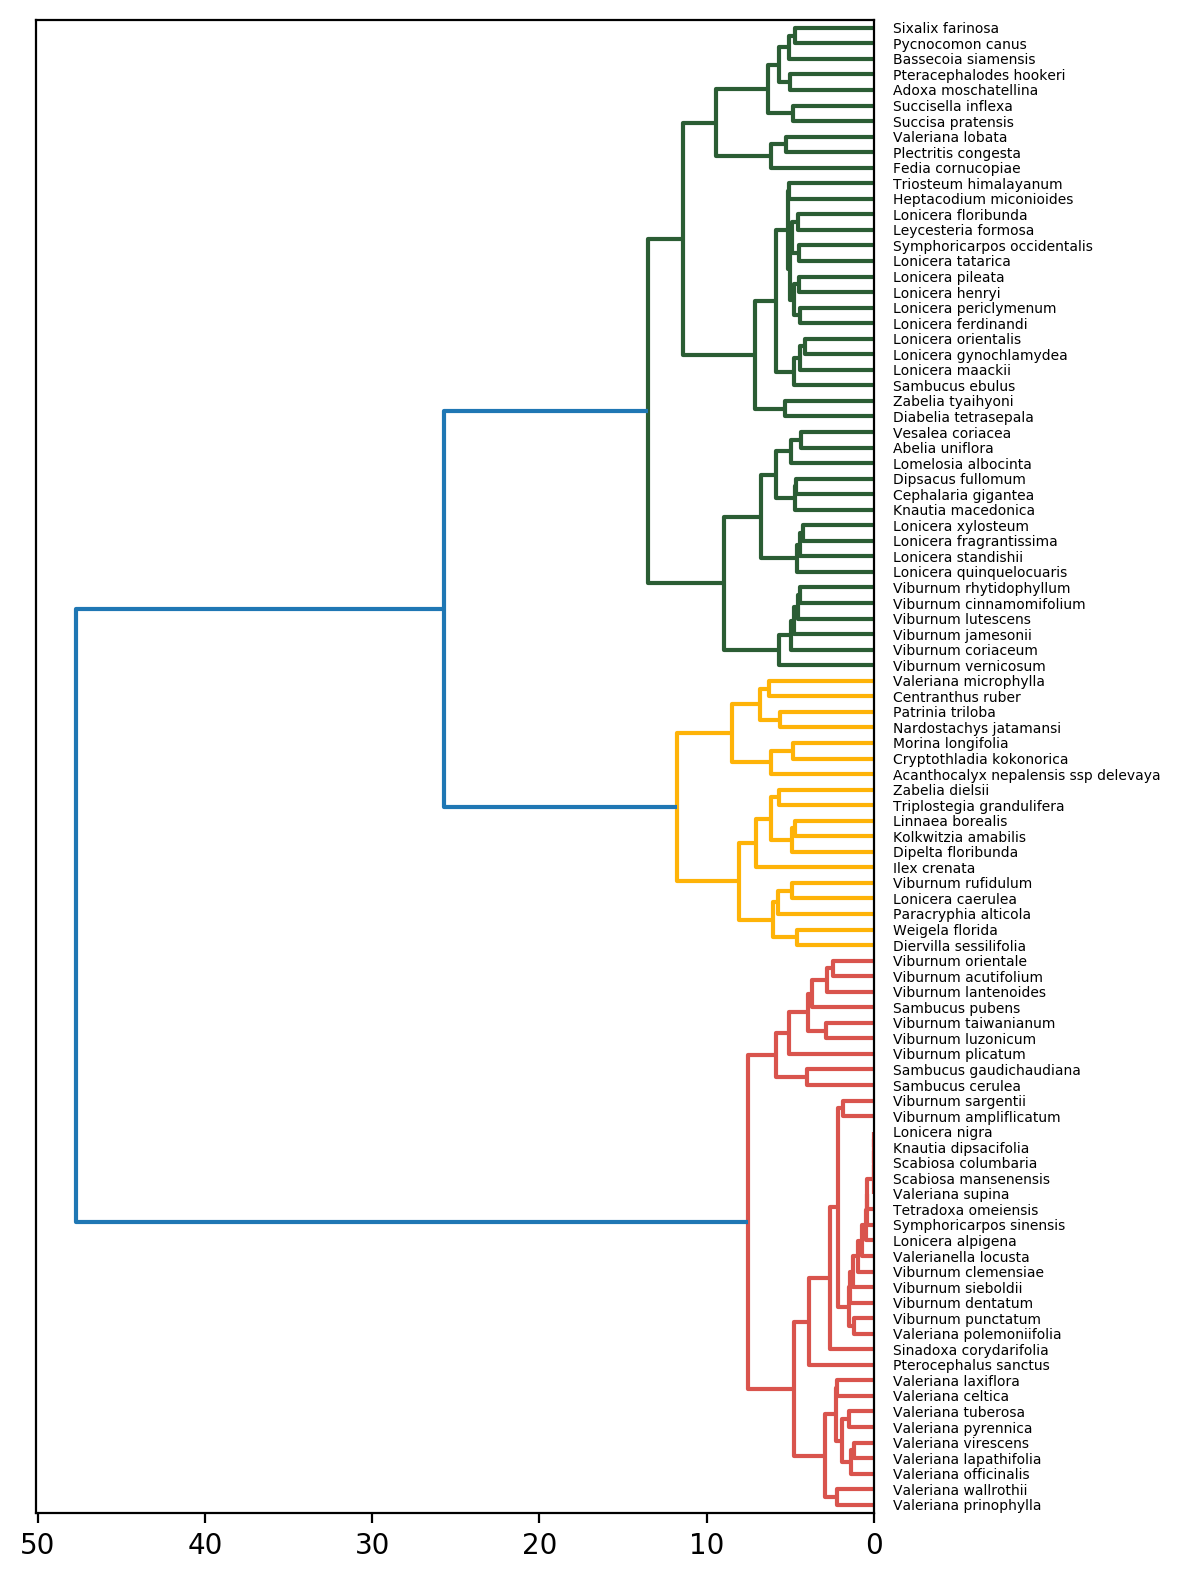

In [8]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(6, 8))

cluster.hierarchy.set_link_color_palette(["xkcd:pale red", "xkcd:amber", "xkcd:pine"])
Z = cluster.hierarchy.linkage(percent_353[locus_cols], method  = "ward")
ward_dendro = cluster.hierarchy.dendrogram(Z, color_threshold=0.5*max(Z[:,2]),
                                           orientation="left", labels = list(percent_353.index), 
                                           ax = ax, )

plt.tight_layout()
# plt.savefig('./Figures/Statistics/Heatmap-taxon-dendrogram.pdf', format='pdf', transparent=True, dpi=300)

The next function is from StackExchange and creates a newick string from a scipy dendrogram. This might be useful for manipulating plots later as you cannot rotate dendrogram nodes in scipy.

In [9]:
def getNewick(node, newick, parentdist, leaf_names):
    if node.is_leaf():
        return "%s:%.2f%s" % (leaf_names[node.id], parentdist - node.dist, newick)
    else:
        if len(newick) > 0:
            newick = "):%.2f%s" % (parentdist - node.dist, newick)
        else:
            newick = ");"
        newick = getNewick(node.get_left(), newick, node.dist, leaf_names)
        newick = getNewick(node.get_right(), ",%s" % (newick), node.dist, leaf_names)
        newick = "(%s" % (newick)
        return newick

In [10]:
percent_353 = percent_353.reindex(ward_dendro['ivl'])

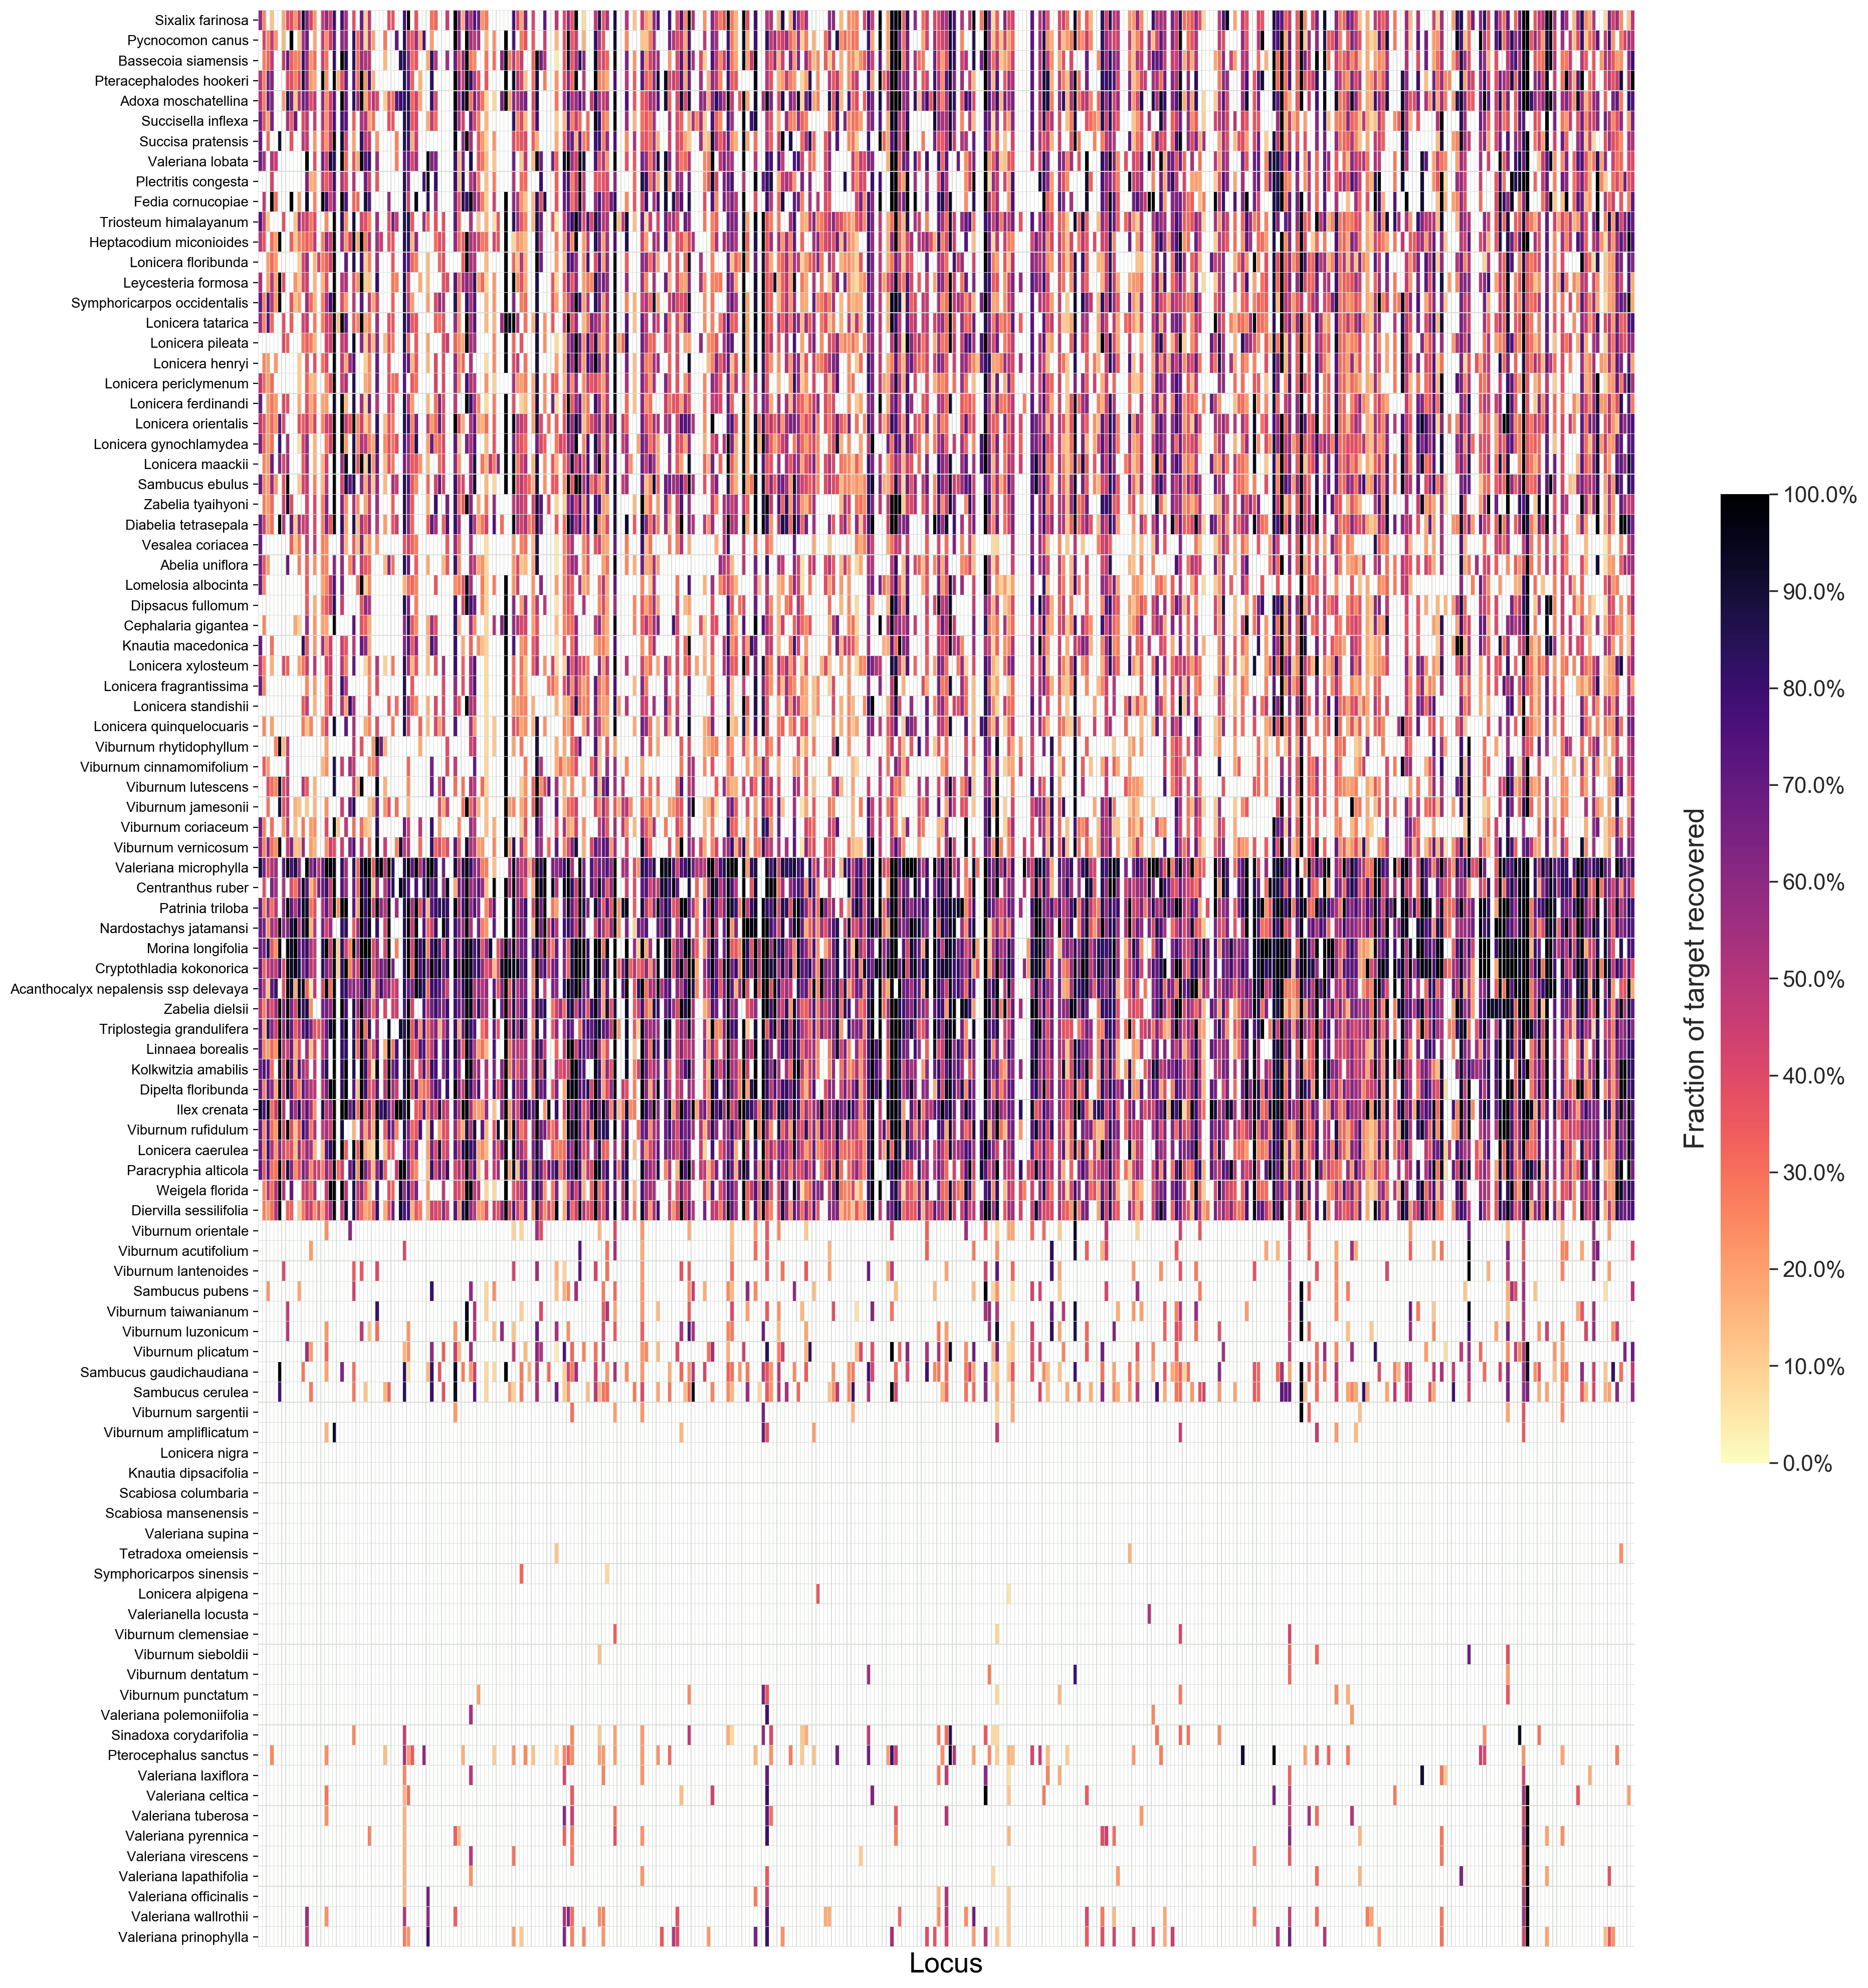

In [11]:
fig, ax = plt.subplots(figsize=(20,20))
sns.set(font_scale=1)
mask = percent_353[locus_cols].isnull()
heatmap = sns.heatmap(data=percent_353[locus_cols].replace(to_replace=0, value=np.nan), 
                      linecolor="xkcd:light grey", mask=mask, cmap='magma_r', 
                      vmin=0.0, vmax=1.0, linewidths=0.10,
            cbar_kws = {"ticks":np.linspace(start=0.0, stop = 1.0, num=11), "shrink": 0.50})

heatmap.set_ylim([0, 96])

heatmap.set_xticks([])
heatmap.set_xticklabels([])

heatmap.set_yticklabels([s.replace("_", " ") for s in percent_353.index])

heatmap.set_xlabel("Locus", size=20)
heatmap.set_ylabel("")

cbar = heatmap.collections[0].colorbar
cbar.set_ticklabels(["{}%".format(t) for t in np.linspace(0, 100, 11)])
cbar.ax.tick_params(labelsize=16)
cbar.set_label(label='Fraction of target recovered', labelpad = -125.0, y = 0.50, size=20)

plt.tight_layout()
# plt.savefig('./Figures/Statistics/Length-heatmap.pdf', format='pdf', transparent=True, dpi=300)

Now I'll reorganize the order of the loci to highlight which ones we kept for analyses. First I'll check to make sure the loci for each dataset are the same.

In [12]:
exon_loci = ["locus{}".format(l) for l in [5357,6432,6947,6383,6732,6458,5464,5990,5899,6221,6226,4793,6130,6139,6689,5354,4471,6494,5733,5404,6933,5421,5639,5815,5941,6601,6462,4796,6961,7128,7241,5664,6366,6785,7583,6119,4992,4691,6216,7361,7136,6652,6848,5716,6552,6572,6320,5422,4744,5090,6978,5273,5562,5843,6050,7602,6679,5599,6389,5398,5188,6318,6995,5200,6454,6064,5138,5950,5296,5945,5104,5260,6792,5018,7279,6265,6527,6540,5406,6373,7273,5366,5866,5918,4848,7141,6299,5859,7111,5116,6378,6363,6029,5634,6398,6487,6238,6258,5531,5477,5841,7021,7135,6685,5348,6274,6859,6483,5770,6649,5921,6270,5772,5299,6198,7628,6924,6227,7325,6449,5981,6865,5703,7028,6036,6496,6457,6459,6914,5721,6946,6298,5339,6098,6779,6544,5913,6407,5596,4954,5968,5551,5123,6056,5791,6550,5333,5922,5502,6393,5536,5893,6746,6404,5163,6713,5489,6164,5038,6791,6038,5131,6016,6563,4893,5162,6882,5528,6175,5977,6893,5865,6405,5264,5822,6854,6631,6460,5670,4942,5857,4932,4889,4724,6968,6148,5943,5842,6660,5347,5699,5335,6977,7331,5858,6150,5949,5614,7013,6864,6557,5980,7324,6639,6488,5933,6500,6041,5578,7572,5849,5513,6958,6406,5816,5974,5894,6420,5034,6282,6526,6176,5168,6528,5642,5257,6384]]
sc_loci = ["locus{}".format(l) for l in [6198,5670,7628,6649,4932,6483,5857,4942,6270,5981,6865,6227,6449,7325,6036,6496,7028,4796,5822,6924,5264,4744,6946,6914,6298,5335,6457,6459,5699,5347,6407,6056,6544,6779,4691,6098,5842,5943,5578,5933,6393,5513,6550,5849,6713,5614,5949,5858,6404,6746,6882,6563,5168,6175,5034,6164,5257,6016,4471,6038,6791,5642,4793,5894,5977,6893,5816,6854,5703,4848,6405,5299,5772,5921,5770,6631,6460,5913,6660,6148,5123,5551,6968,5968,4954,5596,6977,5339,5721,5163,7324,6639,6864,6557,5980,5893,5536,6150,7331,5489,7013,5922,5333,5791,6488,5502,7572,6500,6041,6406,6420,5974,5865,6958,5131,5038,6384,6526,6176,5528,6282,6528,5162,5188,5398,6432,5200,6732,5562,5273,5990,6458,5599,6947,6383,5843,6130,6139,5296,6226,5260,5104,6221,5945,5138,6933,4893,6689,5950,6494,5918,5866,6462,5366,6961,6601,5018,7241,7128,6119,5406,7583,6366,6785,6652,6848,7361,7136,5841,5477,5531,6552,6572,5348,6216,5116,5859,6320,5634,6679,6050,7602,6389,5464,6978,6995,6318,5357,5733,5354,5639,6454,6064,5421,5404,6792,5899,6540,6527,5664,4724,4889,7279,6265,5941,5815,7141,7273,6373,6029,6363,6258,6238,6398,6487,6299,5090,5422,6378,7111,4992,6859,6274,7021,5716,7135,6685]]
exon_sc_loci = ["locus{}".format(l) for l in [6198,5670,7628,6649,4932,6483,5857,4942,6270,5981,6865,6227,6449,7325,6036,6496,7028,4796,5822,6924,5264,4744,6946,6914,6298,5335,6457,6459,5699,5347,6407,6056,6544,6779,4691,6098,5842,5943,5578,5933,6393,5513,6550,5849,6713,5614,5949,5858,6404,6746,6882,6563,5168,6175,5034,6164,5257,6016,4471,6038,6791,5642,4793,5894,5977,6893,5816,6854,5703,4848,6405,5299,5772,5921,5770,6631,6460,5913,6660,6148,5123,5551,6968,5968,4954,5596,6977,5339,5721,5163,7324,6639,6864,6557,5980,5893,5536,6150,7331,5489,7013,5922,5333,5791,6488,5502,7572,6500,6041,6406,6420,5974,5865,6958,5131,5038,6384,6526,6176,5528,6282,6528,5162,5188,5398,6432,5200,6732,5562,5273,5990,6458,5599,6947,6383,5843,6130,6139,5296,6226,5260,5104,6221,5945,5138,6933,4893,6689,5950,6494,5918,5866,6462,5366,6961,6601,5018,7241,7128,6119,5406,7583,6366,6785,6652,6848,7361,7136,5841,5477,5531,6552,6572,5348,6216,5116,5859,6320,5634,6679,6050,7602,6389,5464,6978,6995,6318,5357,5733,5354,5639,6454,6064,5421,5404,6792,5899,6540,6527,5664,4724,4889,7279,6265,5941,5815,7141,7273,6373,6029,6363,6258,6238,6398,6487,6299,5090,5422,6378,7111,4992,6859,6274,7021,5716,7135,6685]] 

In [13]:
set(exon_loci) == set(exon_sc_loci) == set(sc_loci)

True

I'll start by clustering the loci by percent length.

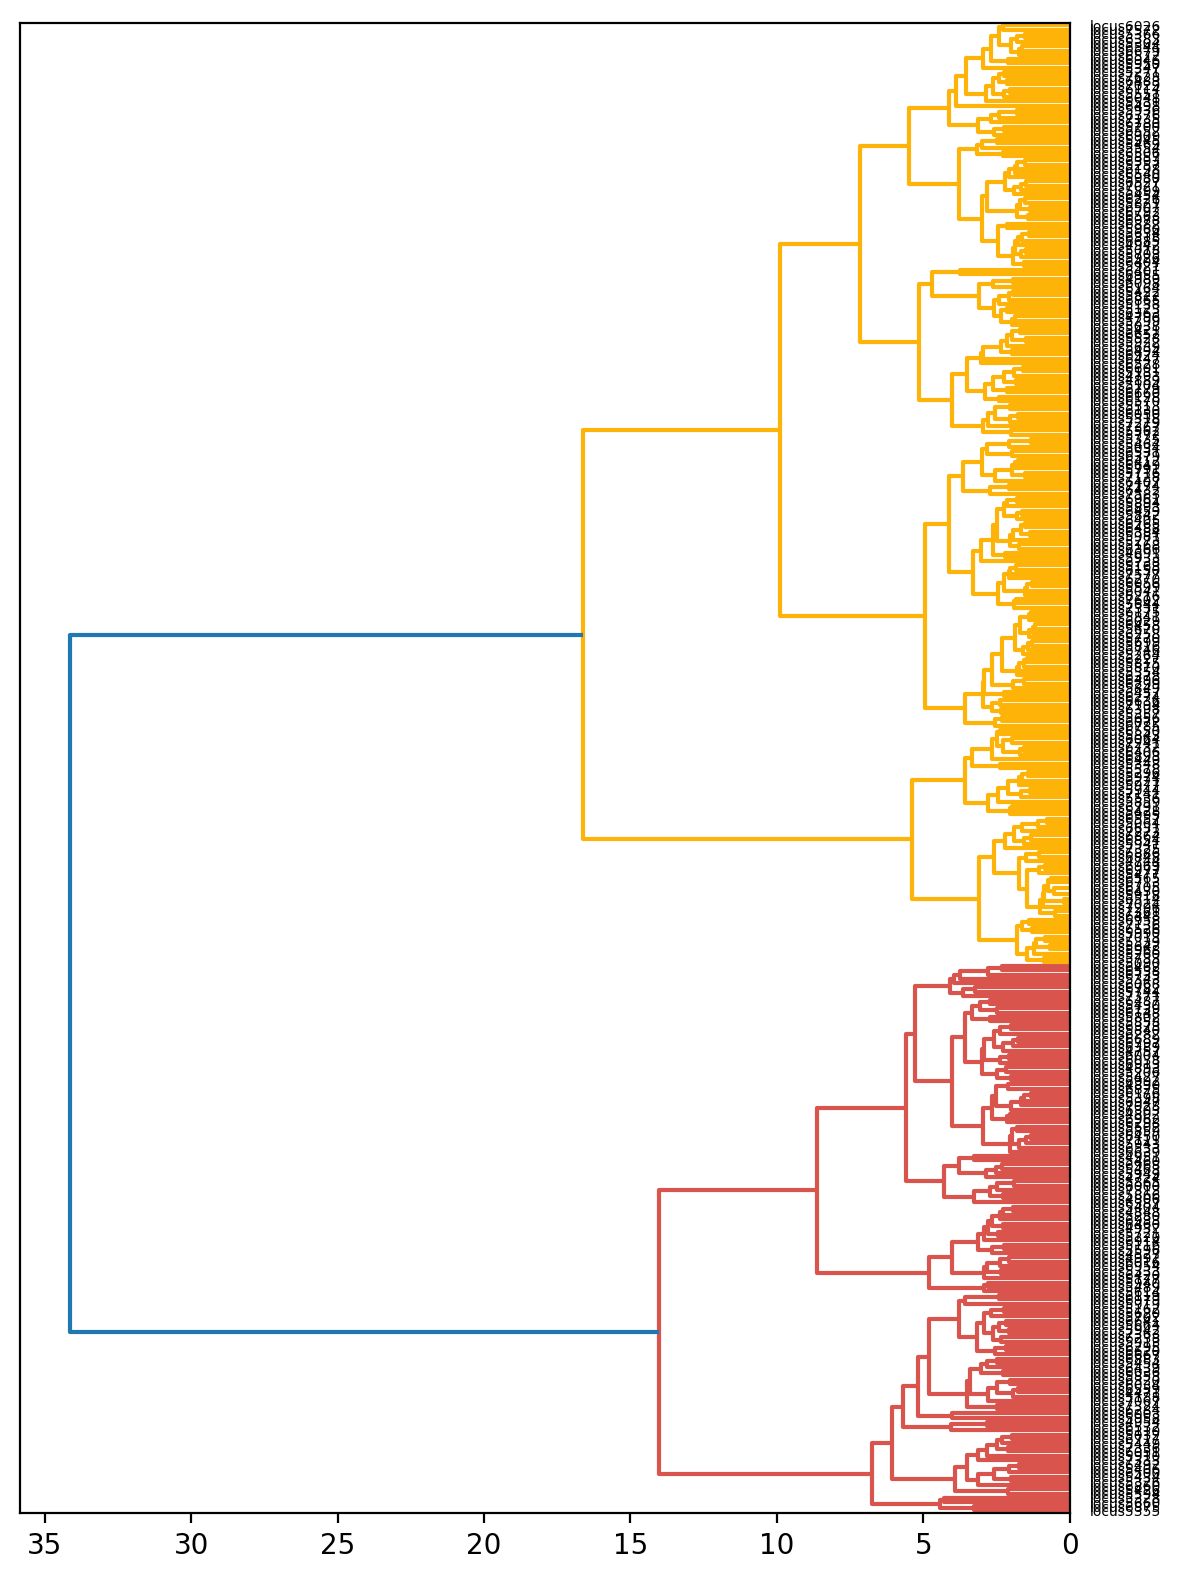

In [14]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(6, 8))

cluster.hierarchy.set_link_color_palette(["xkcd:pale red", "xkcd:amber", "xkcd:pine"])
locusZ = cluster.hierarchy.linkage(percent_353[locus_cols].T, method  = "ward")
locus_ward_dendro = cluster.hierarchy.dendrogram(locusZ, color_threshold=0.5*max(Z[:,2]),
                                           orientation="left", labels = list(percent_353[locus_cols].T.index), 
                                           ax = ax)

plt.tight_layout()

In [592]:
percent_353 = percent_353[locus_ward_dendro['ivl']]
locus_cols = [c for c in percent_353.columns if c.startswith("locus")]

**Remember** that the `labels` parameter of `cluster.hierarchy.dendrogram` should be the original order of the columns that created `Z`, which in this case are the original indices of `percent_353`, all of the species in alphabetical order.

/Users/iangilman/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


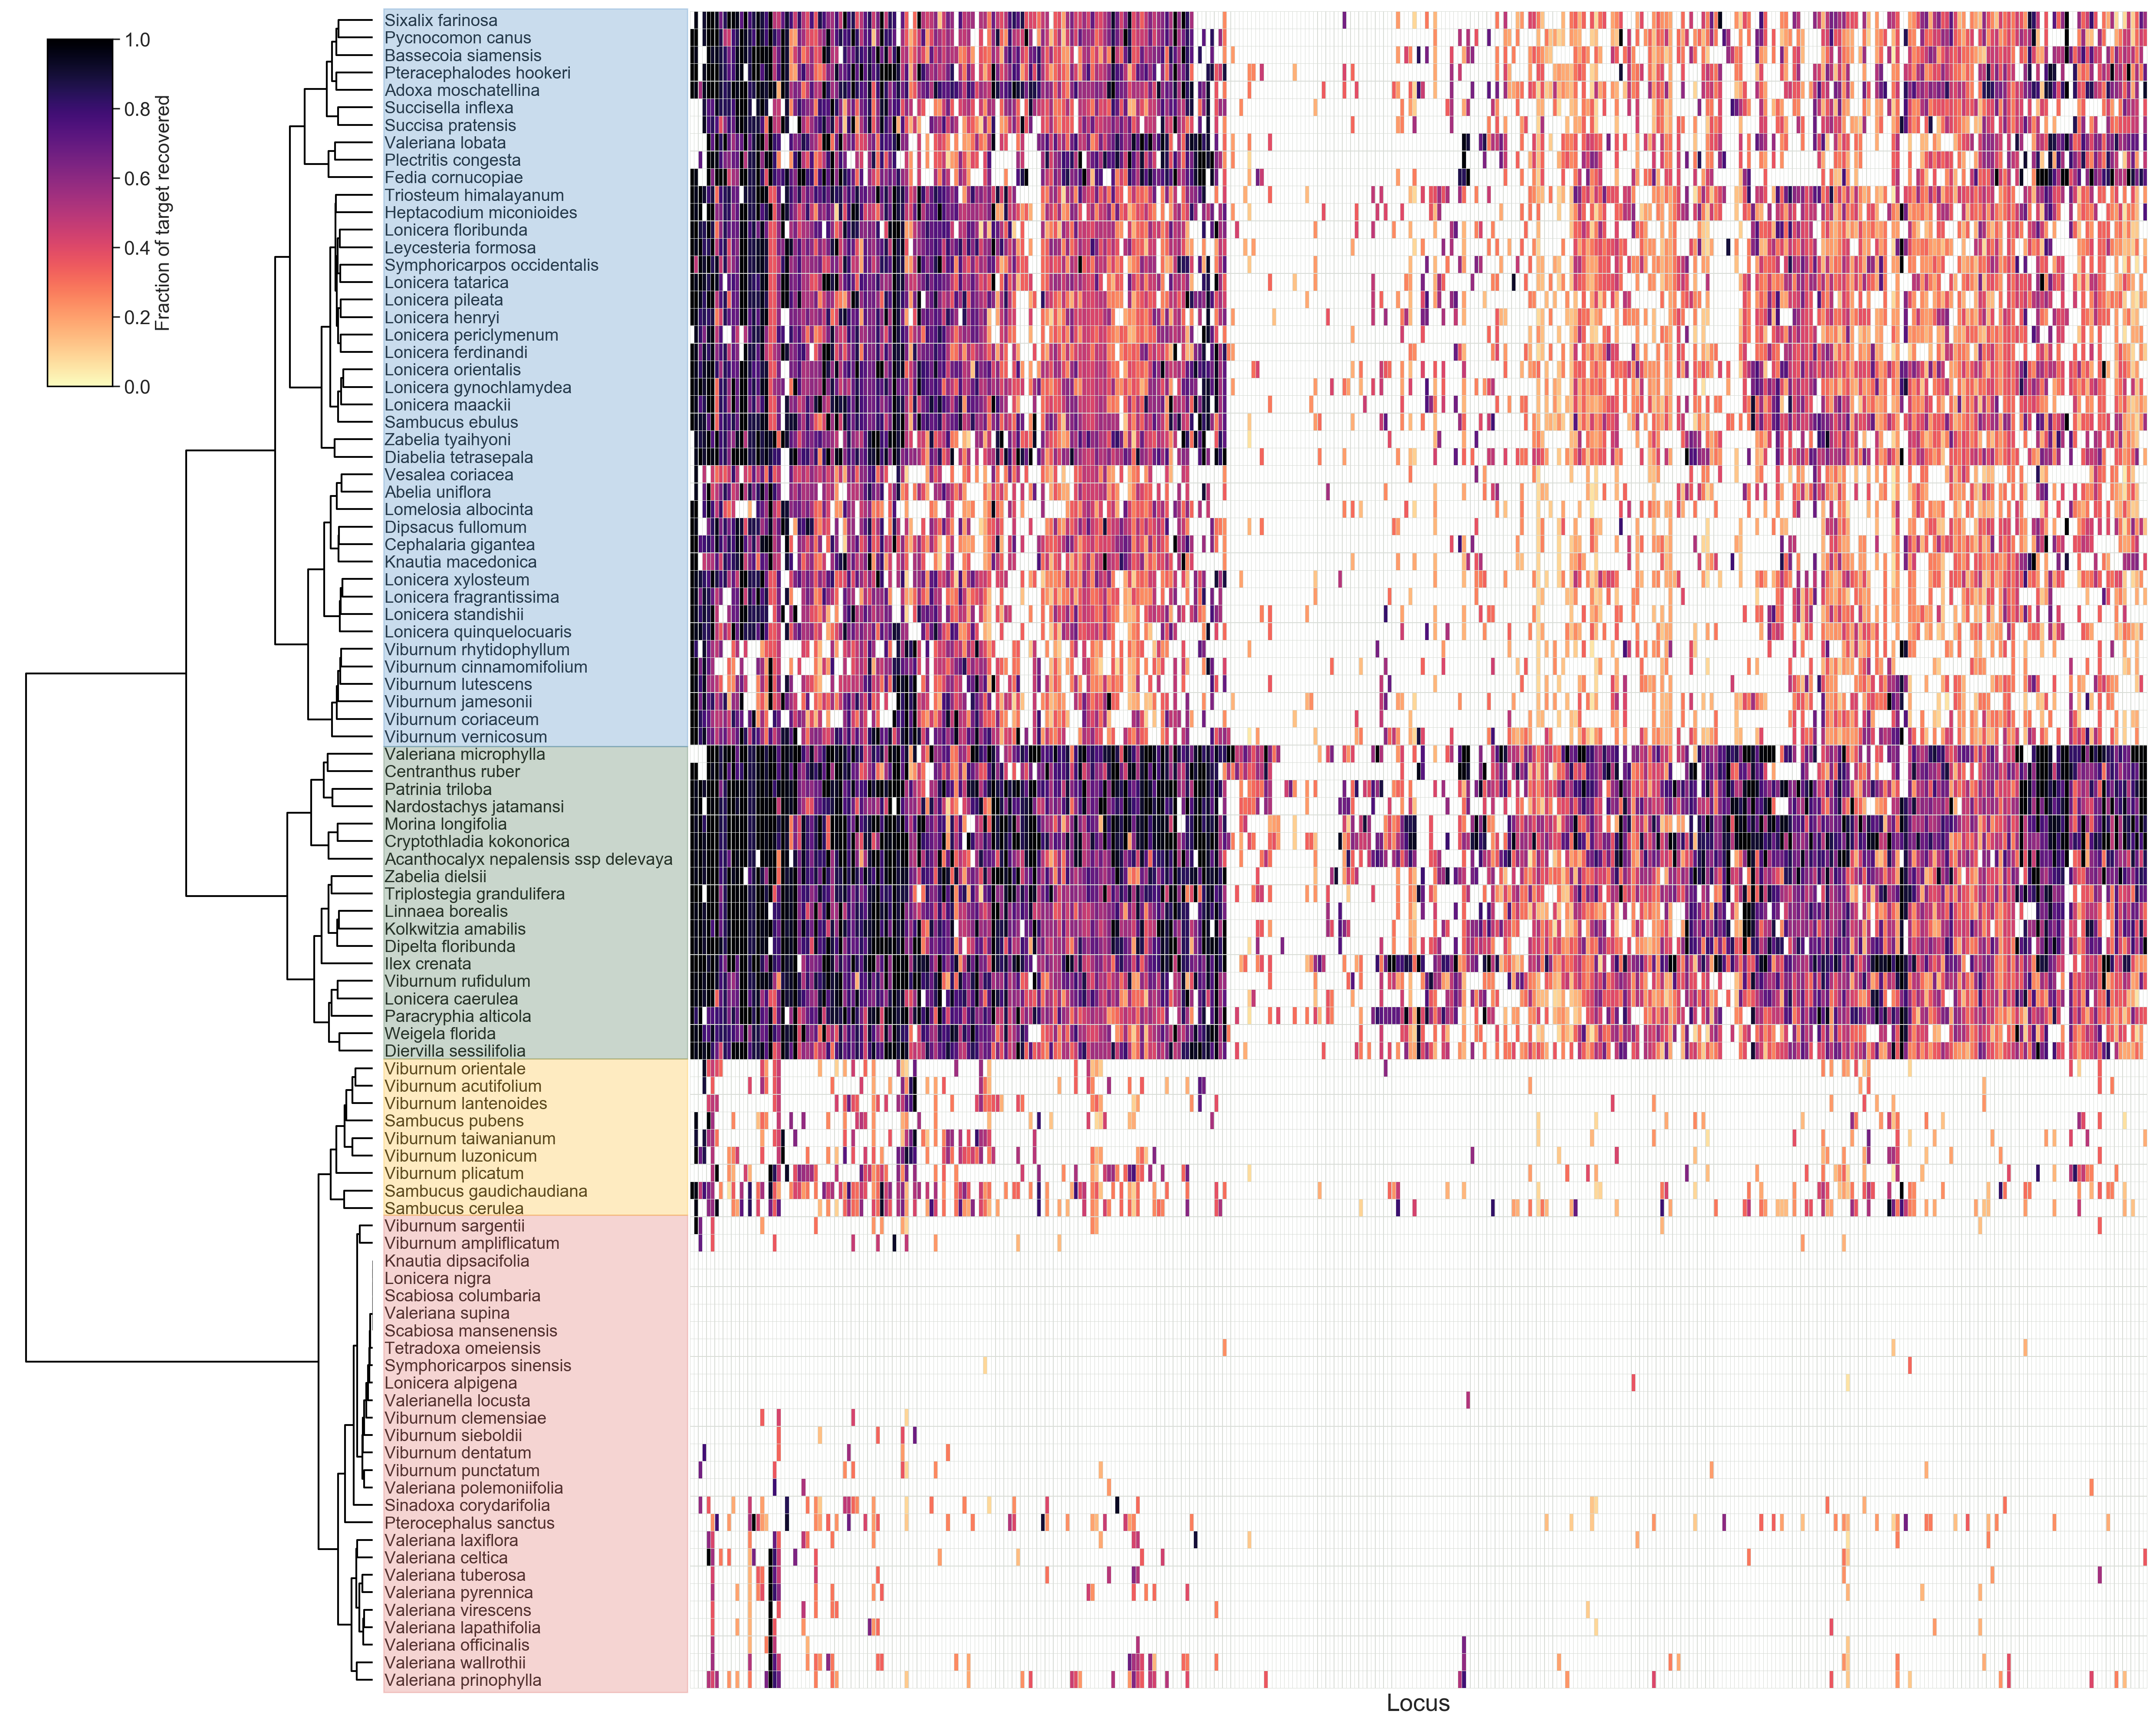

In [942]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,20), gridspec_kw={'width_ratios': [1, 4]})

fig.patches.extend([plt.Rectangle((0.18, 0.0225), 0.14, 0.275, edgecolor=None,
                                  fill=True, color='xkcd:pale red', alpha=0.25, zorder=1000,
                                  transform=fig.transFigure, figure=fig)])
fig.patches.extend([plt.Rectangle((0.18, 0.0225+0.275), 0.14, 0.09,
                                  fill=True, color='xkcd:amber', alpha=0.25, zorder=1000,
                                  transform=fig.transFigure, figure=fig)])
fig.patches.extend([plt.Rectangle((0.18, 0.0225+0.275+0.09), 0.14, 0.18,
                                  fill=True, color='xkcd:pine', alpha=0.25, zorder=1000,
                                  transform=fig.transFigure, figure=fig)])
fig.patches.extend([plt.Rectangle((0.18, 0.0225+0.275+0.09+0.18), 0.14, 0.425,
                                  fill=True, color='xkcd:bluish', alpha=0.25, zorder=1000,
                                  transform=fig.transFigure, figure=fig)])

plt.style.use('default')
cluster.hierarchy.set_link_color_palette(["black", "black", "black"])
cluster.hierarchy.dendrogram(Z, color_threshold=0.5*max(Z[:,2]), orientation="left", 
                             leaf_font_size=14, ax=ax[0], labels=ward_dendro['ivl'],
                             above_threshold_color="black")


sns.set(font_scale=1)
mask = percent_353[locus_cols].isnull()
heatmap = sns.heatmap(data=percent_353[locus_cols].replace(to_replace=0, value=np.nan), 
                      linecolor="xkcd:light grey", mask=mask, cmap='magma_r', vmin=0.0, vmax=1.0, 
                      linewidths=0.10, ax=ax[1], cbar=False,
            cbar_kws = {"ticks":np.linspace(start=0.0, stop = 1.0, num=11), "shrink": 0.50})

heatmap.set_ylim([0, 96])

heatmap.set_xticks([])
heatmap.set_xticklabels([])
heatmap.set_yticklabels([])

heatmap.set_xlabel("Locus", size=20)
heatmap.set_ylabel("")

cmap = plt.cm.magma_r
norm = mcolors.Normalize(vmin=0.0, vmax=1.0)
cax = fig.add_axes([0.025, 0.775, 0.03, 0.20]) # [x0, y0, width, height]
cbar = colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
cbar.outline.set_edgecolor('black')
cbar.ax.tick_params(labelsize=16)
cbar.set_label("Fraction of target recovered", size=16)

ax[0].grid(False)
ax[0].patch.set_visible(False)
ax[0].set_facecolor('white')
ax[0].set_xticks([])
ax[0].set_xticklabels([])

ax[1].set_facecolor('white')

plt.tight_layout()
# plt.savefig('./Figures/Statistics/Locus-heatmap.pdf', format='pdf', transparent=True, dpi=300, bbox_inches='tight')
# plt.savefig('./Figures/Statistics/Locus-heatmap..lowres.png', format='png', transparent=True, dpi=150, bbox_inches='tight')

Now I'll use a grid layout to add additional plots around the outside that show taxon and locus occupancy, which taxa were excluded from parts of analyses, and which loci were used. First I'll use the species tree to figure out which taxa in the data frame were included.

In [15]:
dips = toytree.tree("/Users/iangilman/Dropbox/Dipsacales_Baits_Project/Gene-tree-investigation/FINAL_SPECIES_TREE/Dipsacales-species-tree.BS33.rooted.tre")

In [16]:
species_tree_tips = dips.get_tip_labels()
species_tree_tips = [s.replace("_", " ") for s in species_tree_tips]
species_tree_tips = [s.replace("Patrina", "Patrinia") if "Patrina" in s else s for s in species_tree_tips]

In [17]:
in_tree = []
for i in percent_353.index:
    if i in species_tree_tips:
        in_tree.append(True)
    else:
        in_tree.append(False)
percent_353["intree"] = in_tree

Now count how many taxa each locus contains, and how many loci were recovered for each taxon.

In [18]:
locus_counts = 353-(percent_353[locus_cols] == 0.000000).astype(float).sum(axis=1)
taxon_counts = 96-(percent_353[locus_cols] == 0.000000).astype(float).sum(axis=0)

/Users/iangilman/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:101: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


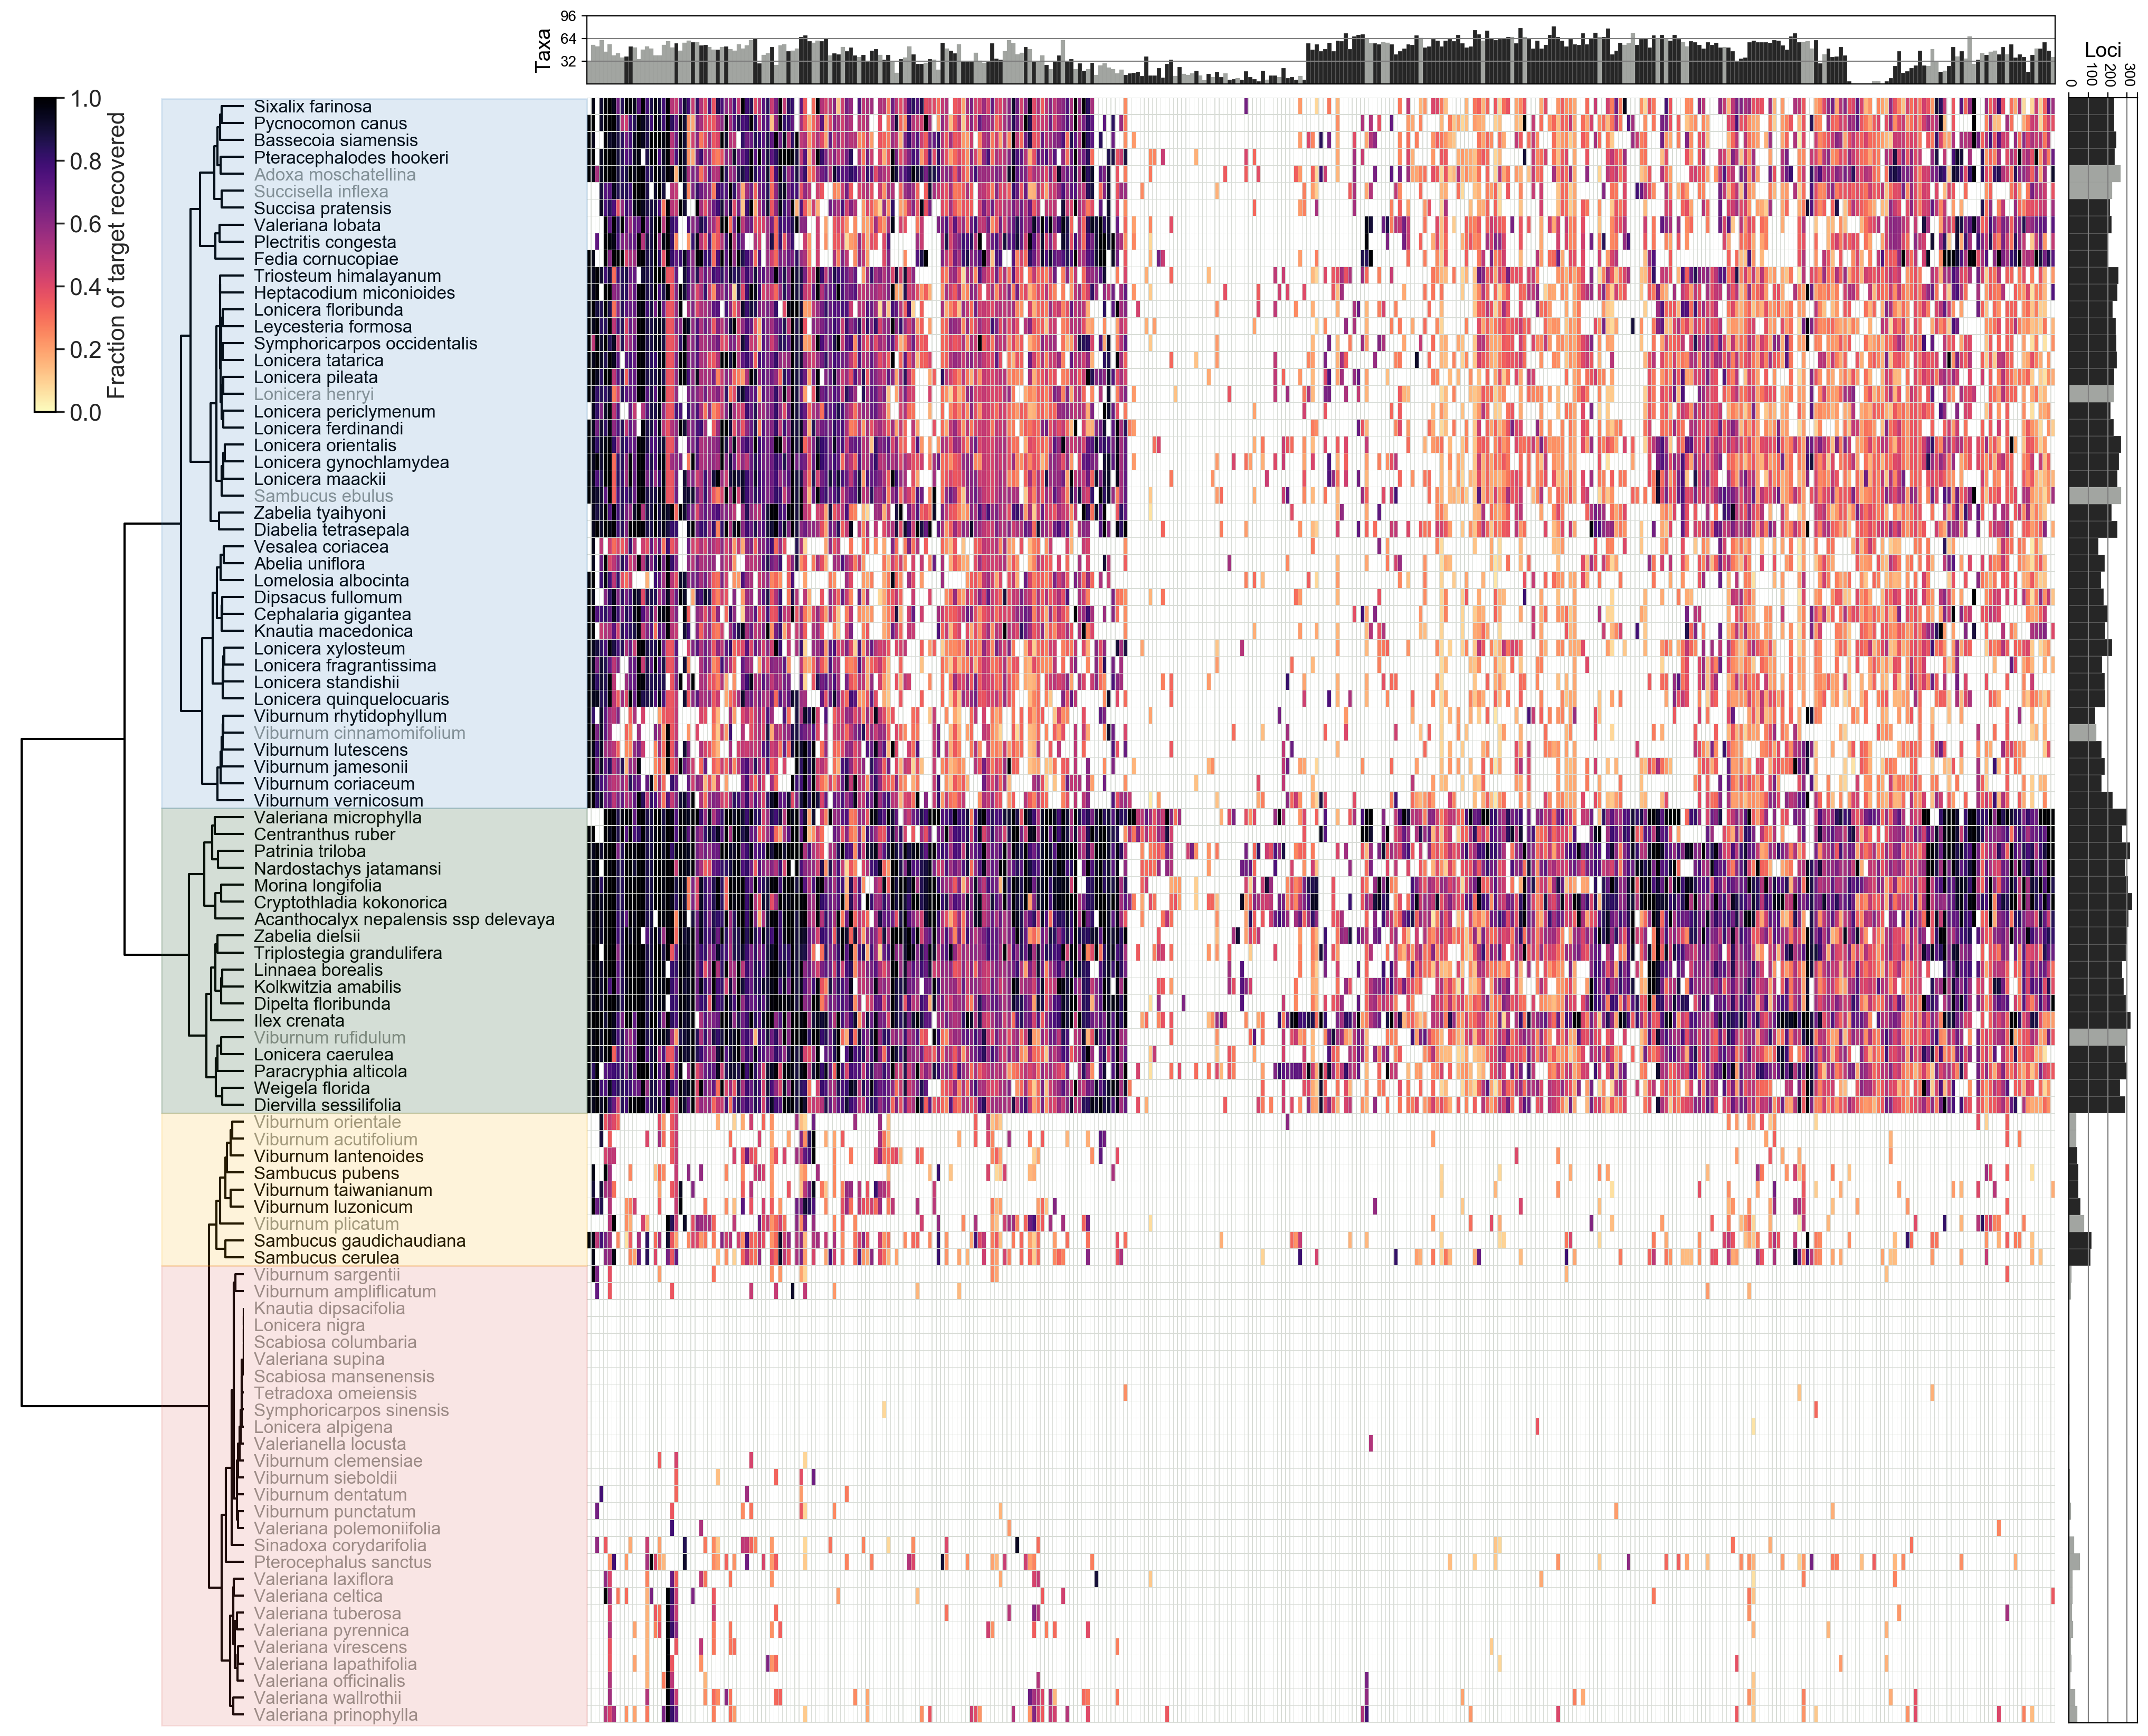

In [997]:
plt.style.use('default')
fig = plt.figure(constrained_layout=False, figsize=(26,21))

# Create grid
gs = fig.add_gridspec(21, 26)
# Add dendrogram, bar plot, and heat map axes
ax_dg = fig.add_subplot(gs[1:, :3])
ax_tp = fig.add_subplot(gs[0, 7:-1])
ax_lp = fig.add_subplot(gs[1:, -1])
ax_hm = fig.add_subplot(gs[1:, 7:-1])

# Add taxon bar chart and color by inclusion
tpbar = ax_tp.bar(x=range(353), height=taxon_counts, color="xkcd:black", width=1.0, alpha=0.85, 
          edgecolor="white", linewidth=0.10, align='edge')
counts=0
for i, locus in enumerate(percent_353[locus_cols].columns):
    if locus not in exon_loci:
        tpbar[i].set_color('xkcd:grey')
    else:
        counts+=1
# Add locus bar chart
lpbar = ax_lp.barh(y=range(96), width=locus_counts, color="xkcd:black", height=1.0, alpha=0.85, 
               align='edge',  edgecolor="white", linewidth=0.10)

ax_tp.set_xticks([])
ax_tp.set_xticklabels([])
ax_tp.set_yticks([32, 64, 96])
ax_tp.set_yticklabels([32, 64, 96])
ax_tp.set_xlim(0, 353)
ax_tp.set_ylim(0, 96)
ax_tp.grid(axis="y", color="gray")
ax_tp.set_ylabel("Taxa", size=14)

ax_lp.xaxis.tick_top()
ax_lp.xaxis.set_label_position("top")
ax_lp.set_yticks([])
ax_lp.set_yticklabels([])
ax_lp.set_xlim(0, 353)
ax_lp.set_ylim(0, 96)
ax_lp.set_xticks([0,100, 200, 300, 353])
ax_lp.set_xticklabels([0, 100, 200, 300], rotation=-90)
ax_lp.grid(axis="x", color="gray")
ax_lp.set_xlabel("Loci", size=14)

# Add cluster background colors
fig.patches.extend([plt.Rectangle((0.18, 0.10875), 0.155, 0.2075, fill=True, color='xkcd:pale red', 
                                  alpha=0.15, transform=fig.transFigure, figure=fig)])
fig.patches.extend([plt.Rectangle((0.18, 0.10875+0.2075), 0.155, 0.06875, fill=True, color='xkcd:amber', 
                                  alpha=0.15, transform=fig.transFigure, figure=fig)])
fig.patches.extend([plt.Rectangle((0.18, 0.11+0.205+0.07), 0.155, 0.1375, fill=True, color='xkcd:pine', 
                                  alpha=0.2, transform=fig.transFigure, figure=fig)])
fig.patches.extend([plt.Rectangle((0.18, 0.11+0.205+0.07+0.1375), 0.155, 0.32, fill=True, color='xkcd:bluish',
                                  alpha=0.15, transform=fig.transFigure, figure=fig)])

# Add dendrogram and color labels by inclusion
cluster.hierarchy.set_link_color_palette(["black", "black", "black"])
cluster.hierarchy.dendrogram(Z, color_threshold=0.5*max(Z[:,2]), orientation="left", 
                             leaf_font_size=12, ax=ax_dg, labels=ward_dendro['ivl'],
                             above_threshold_color="black", )

for i, lbl in enumerate(ax_dg.get_ymajorticklabels()):
    if not percent_353.loc[lbl.get_text(), "intree"]:
        lbl.set_color("xkcd:grey")
        lpbar[i].set_color('xkcd:grey')
        
ax_dg.grid(False)
ax_dg.set_facecolor('white')
ax_dg.set_xticks([])
ax_dg.set_xticklabels([])
for s in ['right', 'left', 'top', 'bottom']:
    ax_dg.spines[s].set_visible(False)

# Add heat map
sns.set(font_scale=1)
mask = percent_353[locus_cols].isnull()
heatmap = sns.heatmap(data=percent_353[locus_cols].replace(to_replace=0, value=np.nan), 
                      linecolor="xkcd:light grey", mask=mask, cmap='magma_r', vmin=0.0, vmax=1.0, 
                      linewidths=0.10, ax=ax_hm, cbar=False,
            cbar_kws = {"ticks":np.linspace(start=0.0, stop = 1.0, num=11), "shrink": 0.50})

ax_hm.set_facecolor('white')
ax_hm.set_ylim([0, 96])
ax_hm.set_xticks([])
ax_hm.set_xticklabels([])
ax_hm.set_yticklabels([])
ax_hm.axis('off')

ax_hm.set_xlabel("Locus", size=20)
ax_hm.set_ylabel("")

# Add color bar
cmap = plt.cm.magma_r
norm = mcolors.Normalize(vmin=0.0, vmax=1.0)
cax = fig.add_subplot(gs[1:5, 0])
cbar = colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
cbar.ax.set_aspect(15)
cbar.outline.set_edgecolor('black')
cbar.ax.tick_params(labelsize=16)
cbar.set_label("Fraction of target recovered", size=16)

plt.tight_layout()
# plt.savefig('./Figures/Statistics/Annotated-locus-heatmap-grey.pdf', format='pdf', 
#             transparent=True, dpi=300, bbox_inches='tight')
# plt.savefig('./Figures/Statistics/Annotated-locus-heatmap-grey.lowres.png', format='png', 
#             transparent=True, dpi=150, bbox_inches='tight')

Now reorder columns to group loci we did and didn't use.

In [19]:
locus_presence_grouping = deque()
for l in locus_cols:
    if l in exon_loci:
        locus_presence_grouping.appendleft(l)
    else:
        locus_presence_grouping.append(l)

/Users/iangilman/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


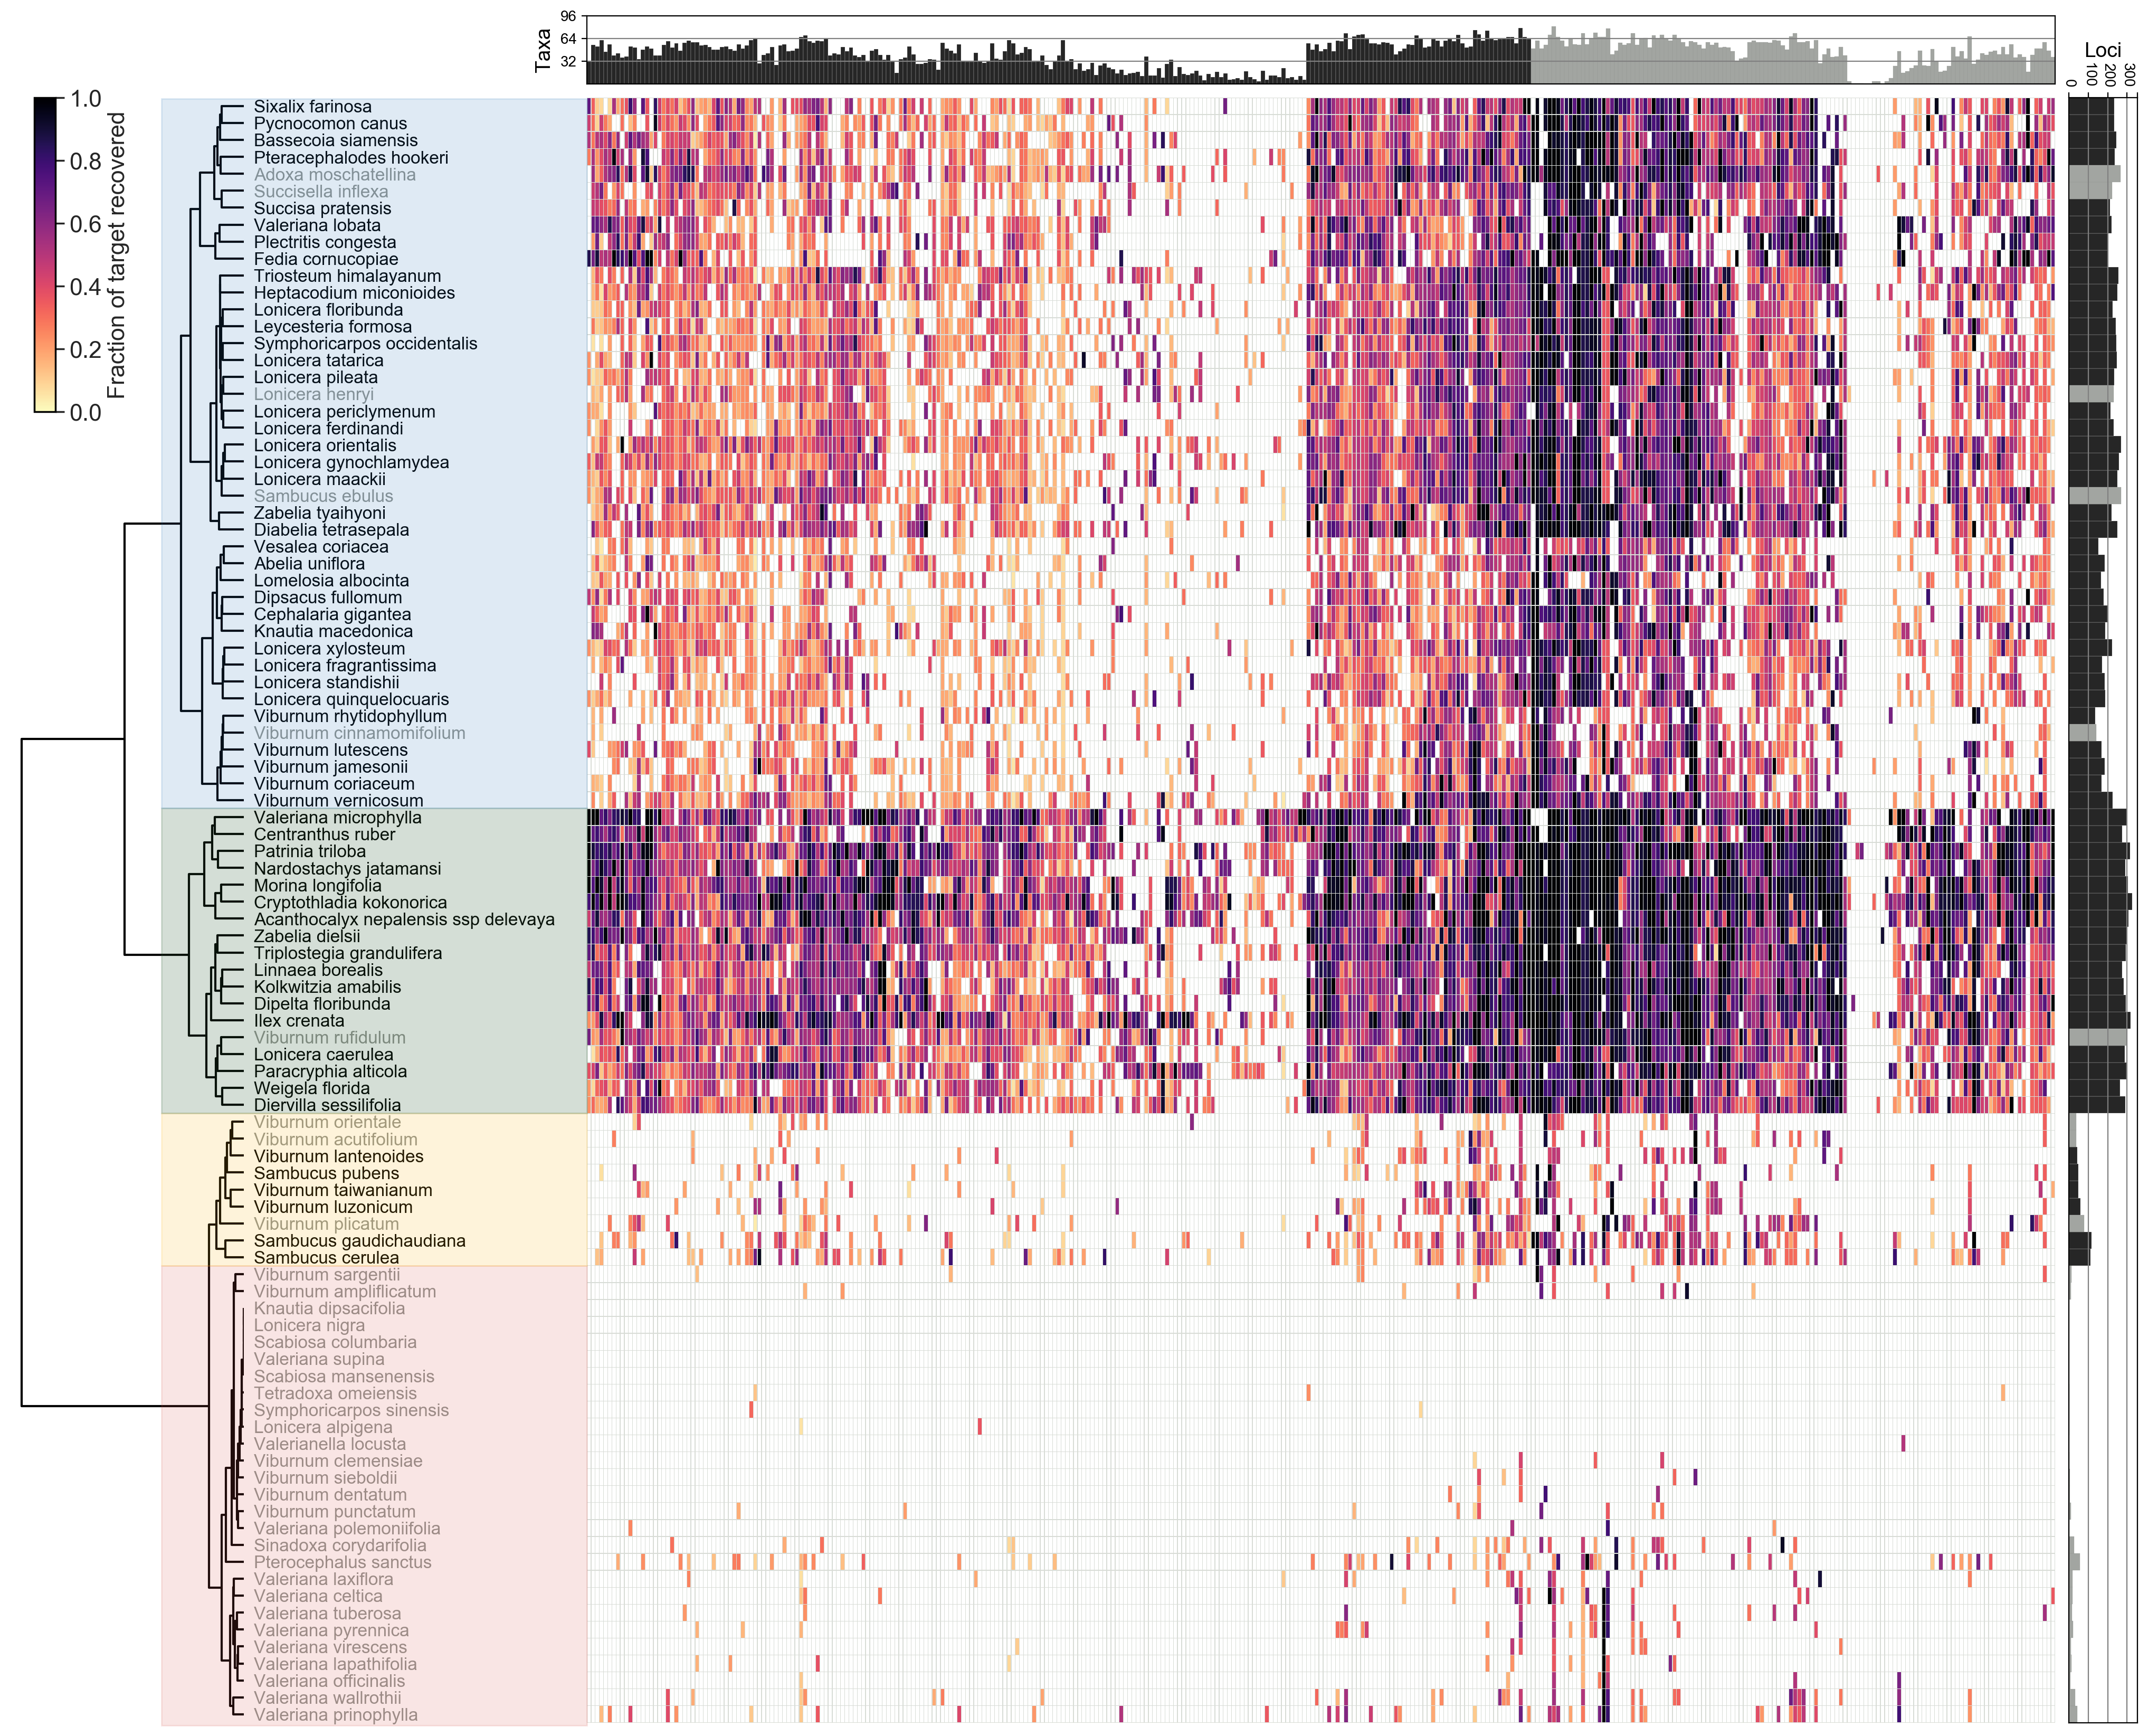

In [996]:
plt.style.use('default')
fig = plt.figure(constrained_layout=False, figsize=(26,21))

# Create grid
gs = fig.add_gridspec(21, 26)
# Add dendrogram, bar plot, and heat map axes
ax_dg = fig.add_subplot(gs[1:, :3])
ax_tp = fig.add_subplot(gs[0, 7:-1])
ax_lp = fig.add_subplot(gs[1:, -1])
ax_hm = fig.add_subplot(gs[1:, 7:-1])

# Add taxon bar chart and color by inclusion
taxon_counts = 96-(percent_353[locus_presence_grouping] == 0.000000).astype(float).sum(axis=0)
tpbar = ax_tp.bar(x=range(353), height=taxon_counts, color="xkcd:black", width=1.0, alpha=0.85, 
          edgecolor="white", linewidth=0.10, align='edge')
counts=0
for i, locus in enumerate(percent_353[locus_presence_grouping].columns):
    if locus not in exon_loci:
        tpbar[i].set_color('xkcd:grey')
    else:
        counts+=1
# Add locus bar chart
lpbar = ax_lp.barh(y=range(96), width=locus_counts, color="xkcd:black", height=1.0, alpha=0.85, 
               align='edge',  edgecolor="white", linewidth=0.10)

ax_tp.set_xticks([])
ax_tp.set_xticklabels([])
ax_tp.set_yticks([32, 64, 96])
ax_tp.set_yticklabels([32, 64, 96])
ax_tp.set_xlim(0, 353)
ax_tp.set_ylim(0, 96)
ax_tp.grid(axis="y", color="gray")
ax_tp.set_ylabel("Taxa", size=14)

ax_lp.xaxis.tick_top()
ax_lp.xaxis.set_label_position("top")
ax_lp.set_yticks([])
ax_lp.set_yticklabels([])
ax_lp.set_xlim(0, 353)
ax_lp.set_ylim(0, 96)
ax_lp.set_xticks([0,100, 200, 300, 353])
ax_lp.set_xticklabels([0, 100, 200, 300], rotation=-90)
ax_lp.grid(axis="x", color="gray")
ax_lp.set_xlabel("Loci", size=14)

# Add cluster background colors
fig.patches.extend([plt.Rectangle((0.18, 0.10875), 0.155, 0.2075, fill=True, color='xkcd:pale red', 
                                  alpha=0.15, transform=fig.transFigure, figure=fig)])
fig.patches.extend([plt.Rectangle((0.18, 0.10875+0.2075), 0.155, 0.06875, fill=True, color='xkcd:amber', 
                                  alpha=0.15, transform=fig.transFigure, figure=fig)])
fig.patches.extend([plt.Rectangle((0.18, 0.11+0.205+0.07), 0.155, 0.1375, fill=True, color='xkcd:pine', 
                                  alpha=0.2, transform=fig.transFigure, figure=fig)])
fig.patches.extend([plt.Rectangle((0.18, 0.11+0.205+0.07+0.1375), 0.155, 0.32, fill=True, color='xkcd:bluish',
                                  alpha=0.15, transform=fig.transFigure, figure=fig)])

# Add dendrogram and color labels by inclusion
cluster.hierarchy.set_link_color_palette(["black", "black", "black"])
cluster.hierarchy.dendrogram(Z, color_threshold=0.5*max(Z[:,2]), orientation="left", 
                             leaf_font_size=12, ax=ax_dg, labels=ward_dendro['ivl'],
                             above_threshold_color="black", )

for i, lbl in enumerate(ax_dg.get_ymajorticklabels()):
    if not percent_353.loc[lbl.get_text(), "intree"]:
        lbl.set_color("xkcd:grey")
        lpbar[i].set_color('xkcd:grey')
        
ax_dg.grid(False)
ax_dg.set_facecolor('white')
ax_dg.set_xticks([])
ax_dg.set_xticklabels([])
for s in ['right', 'left', 'top', 'bottom']:
    ax_dg.spines[s].set_visible(False)

# Add heat map
sns.set(font_scale=1)
mask = percent_353[locus_presence_grouping].isnull()
heatmap = sns.heatmap(data=percent_353[locus_presence_grouping].replace(to_replace=0, value=np.nan), 
                      linecolor="xkcd:light grey", mask=mask, cmap='magma_r', vmin=0.0, vmax=1.0, 
                      linewidths=0.10, ax=ax_hm, cbar=False,
            cbar_kws = {"ticks":np.linspace(start=0.0, stop = 1.0, num=11), "shrink": 0.50})

ax_hm.set_facecolor('white')
ax_hm.set_ylim([0, 96])
ax_hm.set_xticks([])
ax_hm.set_xticklabels([])
ax_hm.set_yticklabels([])
ax_hm.axis('off')

ax_hm.set_xlabel("Locus", size=20)
ax_hm.set_ylabel("")

# Add color bar
cmap = plt.cm.magma_r
norm = mcolors.Normalize(vmin=0.0, vmax=1.0)
cax = fig.add_subplot(gs[1:5, 0])
cbar = colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
cbar.ax.set_aspect(15)
cbar.outline.set_edgecolor('black')
cbar.ax.tick_params(labelsize=16)
cbar.set_label("Fraction of target recovered", size=16)

plt.tight_layout()
# plt.savefig('./Figures/Statistics/Annotated-locus-heatmap-reorder.pdf', format='pdf', 
#             transparent=True, dpi=300, bbox_inches='tight')
# plt.savefig('./Figures/Statistics/Annotated-locus-heatmap-reorder.lowres.png', format='png', 
#             transparent=True, dpi=150, bbox_inches='tight')

## Global and cluster-based statistics
First let's see what the median number of loci recovered and median lengths are for the dataset as a whole. I'll also look at the mean maximum length.

In [20]:
global_median = 353-(percent_353[locus_cols] == 0.000000).astype(float).sum(axis=1).median()
global_lower = 353-(percent_353[locus_cols] == 0.000000).astype(float).sum(axis=1).describe()["75%"]
global_upper = 353-(percent_353[locus_cols] == 0.000000).astype(float).sum(axis=1).describe()["25%"]

global_median_len = percent_353[locus_cols].replace(0.0, np.nan).median().median()
global_median_lower = percent_353[locus_cols].replace(0.0, np.nan).median().describe()["25%"]
global_median_upper = percent_353[locus_cols].replace(0.0, np.nan).median().describe()["75%"]

global_max_len = percent_353[locus_cols].replace(0.0, np.nan).max().median()
global_max_lower = percent_353[locus_cols].replace(0.0, np.nan).max().describe()["25%"]
global_max_upper = percent_353[locus_cols].replace(0.0, np.nan).max().describe()["75%"]

print("The global median loci recovered was {:2.0f} (IQR: {:2.0f}-{:2.0f})".format(global_median, 
                                                                                 global_lower,
                                                                                 global_upper))

print("The global median length recovered was {:3.1%} (IQR {:3.1%}-{:3.1%}) the expected exon length".format(global_median_len, 
                                                                                                             global_median_lower,
                                                                                                             global_median_upper))
print("The global median maximum length recovered was {:3.1%} (IQR {:3.1%}-{:3.1%}) the expected exon length".format(
                                                                                                             global_max_len, 
                                                                                                             global_max_lower,
                                                                                                             global_max_upper))

The global median loci recovered was 187 (IQR: 31-249)
The global median length recovered was 44.9% (IQR 33.7%-58.6%) the expected exon length
The global median maximum length recovered was 96.7% (IQR 84.8%-102.9%) the expected exon length


/Users/iangilman/miniconda3/envs/python3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [21]:
for t, c in taxon_counts.iteritems():
    if c==0:
        print(t,c)

locus6430 0.0
locus6705 0.0


So we did not recovery any contigs for loci 6430 and 6705. Let's look at the mean number of loci recovered and their assembled lengths within each cluster.

In [24]:
percent_353["cluster"] = np.concatenate((np.repeat("low", 27), np.repeat("acceptable",9 ), np.repeat("high", 18), np.repeat("moderate", 42)))
by_cluster = percent_353.groupby("cluster")

In [25]:
for g in by_cluster.groups:
    median_len = by_cluster.get_group(g).replace(0, np.nan).median(axis=0).median()
    len_lower = by_cluster.get_group(g).replace(0, np.nan).median(axis=0).describe()["25%"]
    len_upper = by_cluster.get_group(g).replace(0, np.nan).median(axis=0).describe()["75%"]

    
    temp = by_cluster.get_group(g)[locus_cols]
    rec_median = 353-(temp == 0.000000).astype(float).sum(axis=1).median()
    rec_lower = 353-(temp == 0.000000).astype(float).sum(axis=1).describe()["75%"]
    rec_upper = 353-(temp == 0.000000).astype(float).sum(axis=1).describe()["25%"]
    
    print("{} median loci recovered {:2.0f} (IQR: {:2.0f}-{:2.0f})".format(g, rec_median, rec_lower, rec_upper))
    print("{} median length {:2.1%} (IQR: {:2.1%}-{:2.1%})\n".format(g, median_len, len_lower, len_upper))

/Users/iangilman/miniconda3/envs/python3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


acceptable median loci recovered 49 (IQR: 44-78)
acceptable median length 31.1% (IQR: 20.2%-45.7%)

high median loci recovered 295 (IQR: 289-304)
high median length 61.0% (IQR: 46.0%-76.8%)

low median loci recovered  9 (IQR:  2-17)
low median length 27.4% (IQR: 20.4%-43.1%)

moderate median loci recovered 222 (IQR: 186-243)
moderate median length 38.7% (IQR: 28.8%-53.7%)



Let's take a look at which high-quality taxa were removed from the species tree due to aberrant placement.

In [26]:
percent_353[(percent_353["cluster"].isin(["moderate", "high"])) & (percent_353["intree"]==False)]

locus6528  locus5821  locus5822  locus5980  \
Viburnum rufidulum         0.679907   0.260870   0.722841   0.303859   
Viburnum cinnamomifolium   0.000000   0.347826   0.208914   0.000000   
Sambucus ebulus            0.679907   0.260870   0.213092   0.569132   
Lonicera henryi            0.000000   0.260870   0.208914   0.000000   
Succisella inflexa         0.658879   0.367150   0.208914   0.646302   
Adoxa moschatellina        0.483645   0.265700   0.689415   0.631833   

                          locus5981  locus6955  locus6150  locus5460  \
Viburnum rufidulum         0.216495   0.985207   0.406154      0.992   
Viburnum cinnamomifolium   0.000000   0.000000   0.000000      0.464   
Sambucus ebulus            0.216495   0.000000   0.378462      1.096   
Lonicera henryi            0.216495   0.000000   0.000000      0.000   
Succisella inflexa         0.000000   0.000000   0.000000      0.544   
Adoxa moschatellina        0.000000   0.000000   0.216923      0.872   

                          locus5463  locus5464  ...  locus6544  locus5639  \
Viburnum rufidulum         0.385809   0.130909  ...   0.541648   0.502952   
Viburnum cinnamomifolium   0.000000   0.000000  ...   0.101306   0.162928   
Sambucus ebulus            0.000000   0.000000  ...   0.216119   0.538371   
Lonicera henryi            0.000000   0.000000  ...   0.187753   0.502952   
Succisella inflexa         0.339246   0.683636  ...   0.655110   0.495868   
Adoxa moschatellina        0.645233   0.123636  ...   0.336335   0.000000   

                          locus6540  locus6460  locus6462  locus7583  \
Viburnum rufidulum         0.221675   0.870652   0.568465   0.607251   
Viburnum cinnamomifolium   0.000000   0.593478   0.414938   0.000000   
Sambucus ebulus            0.221675   0.841304   0.709544   0.000000   
Lonicera henryi            0.221675   0.707609   0.630705   0.000000   
Succisella inflexa         0.256158   0.378261   0.568465   0.000000   
Adoxa moschatellina        0.645320   0.714130   0.273859   0.000000   

                          locus4992  locus6238  intree   cluster  
Viburnum rufidulum         1.245506   0.776931   False      high  
Viburnum cinnamomifolium   0.473596   0.532100   False  moderate  
Sambucus ebulus            0.834270   0.767138   False  moderate  
Lonicera henryi            0.706180   0.199129   False  moderate  
Succisella inflexa         0.219101   0.649619   False  moderate  
Adoxa moschatellina        0.803933   0.750816   False  moderate  

[6 rows x 355 columns]

## Locus-based statistics
The next set of analyses look at the number locus that have certain properties or meet a filtering criterion.

In [54]:
raw_stats = pd.read_csv('/Users/iangilman/Dropbox/Dipsacales_Baits_Project/Gilman_stats.txt', sep='\t', index_col=0)
raw_stats.index = [s.replace("_", " ") for s in raw_stats.index]
raw_stats.index = [s.replace("Patrina", "Patrinia") if "Patrina" in s else s for s in raw_stats.index]
raw_stats = raw_stats.sort_index()
raw_stats['cluster'] = percent_353["cluster"].sort_index()
raw_stats.head()

NumReads  ReadsMapped  PctOnTarget  \
Abelia uniflora                         710977       135737        0.191   
Acanthocalyx nepalensis ssp delevaya    854502       316136        0.370   
Adoxa moschatellina                    1015995       151739        0.149   
Bassecoia siamensis                     592404       129043        0.218   
Centranthus ruber                       314298        83493        0.266   

                                      GenesMapped  GenesWithContigs  \
Abelia uniflora                               348               201   
Acanthocalyx nepalensis ssp delevaya          352               319   
Adoxa moschatellina                           349               283   
Bassecoia siamensis                           347               259   
Centranthus ruber                             338               282   

                                      GenesWithSeqs  GenesAt25pct  \
Abelia uniflora                                 186           135   
Acanthocalyx nepalensis ssp delevaya            306           283   
Adoxa moschatellina                             267           237   
Bassecoia siamensis                             244           200   
Centranthus ruber                               275           260   

                                      GenesAt50pct  GenesAt75pct  \
Abelia uniflora                                 55            14   
Acanthocalyx nepalensis ssp delevaya           219           119   
Adoxa moschatellina                            166            78   
Bassecoia siamensis                             98            42   
Centranthus ruber                              197           107   

                                      Genesat150pct  ParalogWarnings   cluster  
Abelia uniflora                                   0                0  moderate  
Acanthocalyx nepalensis ssp delevaya              0               30      high  
Adoxa moschatellina                               0                2  moderate  
Bassecoia siamensis                               0                3  moderate  
Centranthus ruber                                 0               39      high

In [29]:
raw_stats.sort_values("ParalogWarnings", ascending=False)[:20]["ParalogWarnings"]

Cryptothladia kokonorica                52
Morina longifolia                       47
Centranthus ruber                       39
Acanthocalyx nepalensis ssp delevaya    30
Zabelia dielsii                         24
Fedia cornucopiae                       18
Viburnum rufidulum                      13
Valeriana lobata                        12
Pteracephalodes hookeri                 11
Zabelia tyaihyoni                        8
Valeriana microphylla                    6
Ilex crenata                             6
Nardostachys jatamansi                   5
Dipelta floribunda                       5
Kolkwitzia amabilis                      4
Linnaea borealis                         4
Lonicera caerulea                        4
Paracryphia alticola                     4
Weigela florida                          4
Bassecoia siamensis                      3
Name: ParalogWarnings, dtype: int64

In [30]:
dipsacales_stats = raw_stats.reset_index()
dipsacales_stats.rename({"index":"species"}, axis=1, inplace=True)
dipsacales_stats = dipsacales_stats.merge(raw_353[[c for c in raw_353.columns if not c.startswith("locus")]], on="species")
dipsacales_stats.head()

species  NumReads  ReadsMapped  PctOnTarget  \
0  Acanthocalyx nepalensis ssp delevaya    854502       316136        0.370   
1                     Lonicera alpigena      3643          817        0.224   
2                      Vesalea coriacea    280404        32235        0.115   
3                    Lonicera xylosteum    186957        41482        0.222   
4                       Zabelia dielsii   1110105       197219        0.178   

   GenesMapped  GenesWithContigs  GenesWithSeqs  GenesAt25pct  GenesAt50pct  \
0          352               319            306           283           219   
1          101                 4              2             1             0   
2          331               163            151           104            29   
3          319               231            222           161            63   
4          352               312            302           283           214   

   GenesAt75pct  Genesat150pct  ParalogWarnings  initial_concentration  \
0           119              0               30                  95.00   
1             0              0                0                  30.20   
2             6              0                0                 494.00   
3            23              0                1                  60.00   
4           116              0               24                   9.26   

   initial_ng_DNA         genus  cycles  post_amp_ng_DNA  pool  
0          9500.0  Acanthocalyx      12          934.800     8  
1          3020.0      Lonicera      12          558.600     5  
2         24700.0      Viburnum      12          113.620     6  
3          3300.0        Morina      12          904.400     5  
4           277.8          Ilex      12            4.408     6

In [31]:
dipsacales_stats.describe()

NumReads   ReadsMapped  PctOnTarget  GenesMapped  GenesWithContigs  \
count  9.600000e+01  9.600000e+01    96.000000    96.000000         96.000000   
mean   4.658669e+05  1.087618e+05     0.184010   302.041667        169.062500   
std    4.582499e+05  2.273955e+05     0.131243    73.475942        112.881383   
min    2.872000e+03  1.720000e+02     0.004000    24.000000          1.000000   
25%    2.058375e+05  1.315875e+04     0.070000   301.750000         44.500000   
50%    3.249500e+05  6.230450e+04     0.195500   330.500000        201.000000   
75%    5.388305e+05  1.071838e+05     0.255500   343.250000        259.000000   
max    2.325322e+06  1.848190e+06     0.795000   352.000000        339.000000   

       GenesWithSeqs  GenesAt25pct  GenesAt50pct  GenesAt75pct  Genesat150pct  \
count      96.000000     96.000000     96.000000     96.000000      96.000000   
mean      158.843750    130.927083     76.072917     35.239583       0.020833   
std       112.264287    101.240542     72.832793     41.035734       0.143576   
min         0.000000      0.000000      0.000000      0.000000       0.000000   
25%        30.750000     19.750000      6.000000      2.000000       0.000000   
50%       187.000000    139.000000     63.500000     23.500000       0.000000   
75%       250.000000    207.000000    114.250000     48.000000       0.000000   
max       326.000000    311.000000    256.000000    170.000000       1.000000   

       ParalogWarnings  initial_concentration  initial_ng_DNA     cycles  \
count        96.000000              96.000000       96.000000  96.000000   
mean          3.364583             107.282188    17558.884115  12.208333   
std           9.115770             221.733685    49601.671867   0.845006   
min           0.000000               2.600000       26.000000  12.000000   
25%           0.000000              13.325000      633.500000  12.000000   
50%           0.000000              31.100000     2430.000000  12.000000   
75%           2.000000              82.850000     7955.000000  12.000000   
max          52.000000            1520.000000   270000.000000  16.000000   

       post_amp_ng_DNA       pool  
count        96.000000  96.000000  
mean        977.634667   4.500000  
std         521.838896   2.303316  
min           4.408000   1.000000  
25%         614.650000   2.750000  
50%         967.100000   4.500000  
75%        1368.000000   6.250000  
max        2166.000000   8.000000

In [32]:
numeric_stats = dipsacales_stats[[c for c in dipsacales_stats.columns if dipsacales_stats[c].dtype.kind in 'biufc']]
numeric_stats.head()

NumReads  ReadsMapped  PctOnTarget  GenesMapped  GenesWithContigs  \
0    854502       316136        0.370          352               319   
1      3643          817        0.224          101                 4   
2    280404        32235        0.115          331               163   
3    186957        41482        0.222          319               231   
4   1110105       197219        0.178          352               312   

   GenesWithSeqs  GenesAt25pct  GenesAt50pct  GenesAt75pct  Genesat150pct  \
0            306           283           219           119              0   
1              2             1             0             0              0   
2            151           104            29             6              0   
3            222           161            63            23              0   
4            302           283           214           116              0   

   ParalogWarnings  initial_concentration  initial_ng_DNA  cycles  \
0               30                  95.00          9500.0      12   
1                0                  30.20          3020.0      12   
2                0                 494.00         24700.0      12   
3                1                  60.00          3300.0      12   
4               24                   9.26           277.8      12   

   post_amp_ng_DNA  pool  
0          934.800     8  
1          558.600     5  
2          113.620     6  
3          904.400     5  
4            4.408     6

In [33]:
numeric_stats.describe()

NumReads   ReadsMapped  PctOnTarget  GenesMapped  GenesWithContigs  \
count  9.600000e+01  9.600000e+01    96.000000    96.000000         96.000000   
mean   4.658669e+05  1.087618e+05     0.184010   302.041667        169.062500   
std    4.582499e+05  2.273955e+05     0.131243    73.475942        112.881383   
min    2.872000e+03  1.720000e+02     0.004000    24.000000          1.000000   
25%    2.058375e+05  1.315875e+04     0.070000   301.750000         44.500000   
50%    3.249500e+05  6.230450e+04     0.195500   330.500000        201.000000   
75%    5.388305e+05  1.071838e+05     0.255500   343.250000        259.000000   
max    2.325322e+06  1.848190e+06     0.795000   352.000000        339.000000   

       GenesWithSeqs  GenesAt25pct  GenesAt50pct  GenesAt75pct  Genesat150pct  \
count      96.000000     96.000000     96.000000     96.000000      96.000000   
mean      158.843750    130.927083     76.072917     35.239583       0.020833   
std       112.264287    101.240542     72.832793     41.035734       0.143576   
min         0.000000      0.000000      0.000000      0.000000       0.000000   
25%        30.750000     19.750000      6.000000      2.000000       0.000000   
50%       187.000000    139.000000     63.500000     23.500000       0.000000   
75%       250.000000    207.000000    114.250000     48.000000       0.000000   
max       326.000000    311.000000    256.000000    170.000000       1.000000   

       ParalogWarnings  initial_concentration  initial_ng_DNA     cycles  \
count        96.000000              96.000000       96.000000  96.000000   
mean          3.364583             107.282188    17558.884115  12.208333   
std           9.115770             221.733685    49601.671867   0.845006   
min           0.000000               2.600000       26.000000  12.000000   
25%           0.000000              13.325000      633.500000  12.000000   
50%           0.000000              31.100000     2430.000000  12.000000   
75%           2.000000              82.850000     7955.000000  12.000000   
max          52.000000            1520.000000   270000.000000  16.000000   

       post_amp_ng_DNA       pool  
count        96.000000  96.000000  
mean        977.634667   4.500000  
std         521.838896   2.303316  
min           4.408000   1.000000  
25%         614.650000   2.750000  
50%         967.100000   4.500000  
75%        1368.000000   6.250000  
max        2166.000000   8.000000

In [34]:
raw_stats.sort_values("ParalogWarnings", ascending=False)[:15]

NumReads  ReadsMapped  PctOnTarget  \
Cryptothladia kokonorica               1785213       602397        0.337   
Morina longifolia                       413515       147768        0.357   
Centranthus ruber                       314298        83493        0.266   
Acanthocalyx nepalensis ssp delevaya    854502       316136        0.370   
Zabelia dielsii                        1110105       197219        0.178   
Fedia cornucopiae                       206736        36621        0.177   
Viburnum rufidulum                      867405       199339        0.230   
Valeriana lobata                        445096       159600        0.359   
Pteracephalodes hookeri                 798041       157884        0.198   
Zabelia tyaihyoni                       306010        68535        0.224   
Valeriana microphylla                   835073       229859        0.275   
Ilex crenata                            534377       116377        0.218   
Nardostachys jatamansi                  331702        86778        0.262   
Dipelta floribunda                      332273        81436        0.245   
Kolkwitzia amabilis                     362732        71090        0.196   

                                      GenesMapped  GenesWithContigs  \
Cryptothladia kokonorica                      351               339   
Morina longifolia                             350               316   
Centranthus ruber                             338               282   
Acanthocalyx nepalensis ssp delevaya          352               319   
Zabelia dielsii                               352               312   
Fedia cornucopiae                             334               212   
Viburnum rufidulum                            350               306   
Valeriana lobata                              342               233   
Pteracephalodes hookeri                       348               251   
Zabelia tyaihyoni                             346               229   
Valeriana microphylla                         347               311   
Ilex crenata                                  350               324   
Nardostachys jatamansi                        344               297   
Dipelta floribunda                            347               301   
Kolkwitzia amabilis                           348               290   

                                      GenesWithSeqs  GenesAt25pct  \
Cryptothladia kokonorica                        326           311   
Morina longifolia                               305           282   
Centranthus ruber                               275           260   
Acanthocalyx nepalensis ssp delevaya            306           283   
Zabelia dielsii                                 302           283   
Fedia cornucopiae                               202           181   
Viburnum rufidulum                              298           260   
Valeriana lobata                                219           194   
Pteracephalodes hookeri                         235           197   
Zabelia tyaihyoni                               221           182   
Valeriana microphylla                           300           293   
Ilex crenata                                    319           296   
Nardostachys jatamansi                          291           276   
Dipelta floribunda                              292           270   
Kolkwitzia amabilis                             283           260   

                                      GenesAt50pct  GenesAt75pct  \
Cryptothladia kokonorica                       256           170   
Morina longifolia                              229           150   
Centranthus ruber                              197           107   
Acanthocalyx nepalensis ssp delevaya           219           119   
Zabelia dielsii                                214           116   
Fedia cornucopiae                              123            65   
Viburnum rufidulum                             172            79   
Valeriana lobata                   

In [35]:
name_display_dict = {'NumReads':"Total reads", 
                     'ReadsMapped':"Reads mapped", 
                     'PctOnTarget':"Fraction on target", 
                     'GenesMapped':"Loci mapped",
                     'GenesWithContigs':"Loci with contigs", 
                     'GenesWithSeqs':"Loci with sequences", 
                     'GenesAt25pct':"Loci $\geq$ 25% total length", 
                     'GenesAt50pct':"Loci $\geq$ 50% total length",
                     'GenesAt75pct':"Loci $\geq$ 75% total length", 
                     'ParalogWarnings':"Paralog warnings per sample", 
                     'initial_concentration':"Initial sample\nconcentration (ng/$\mu$g)",
                     'initial_ng_DNA':"Initial sample DNA (ng)", 
                     'cycles':"Library PCR cycles", 
                     'post_amp_ng_DNA':"Post-amplification\nsample DNA (ng)", 
                     'pool':"Library pool"}

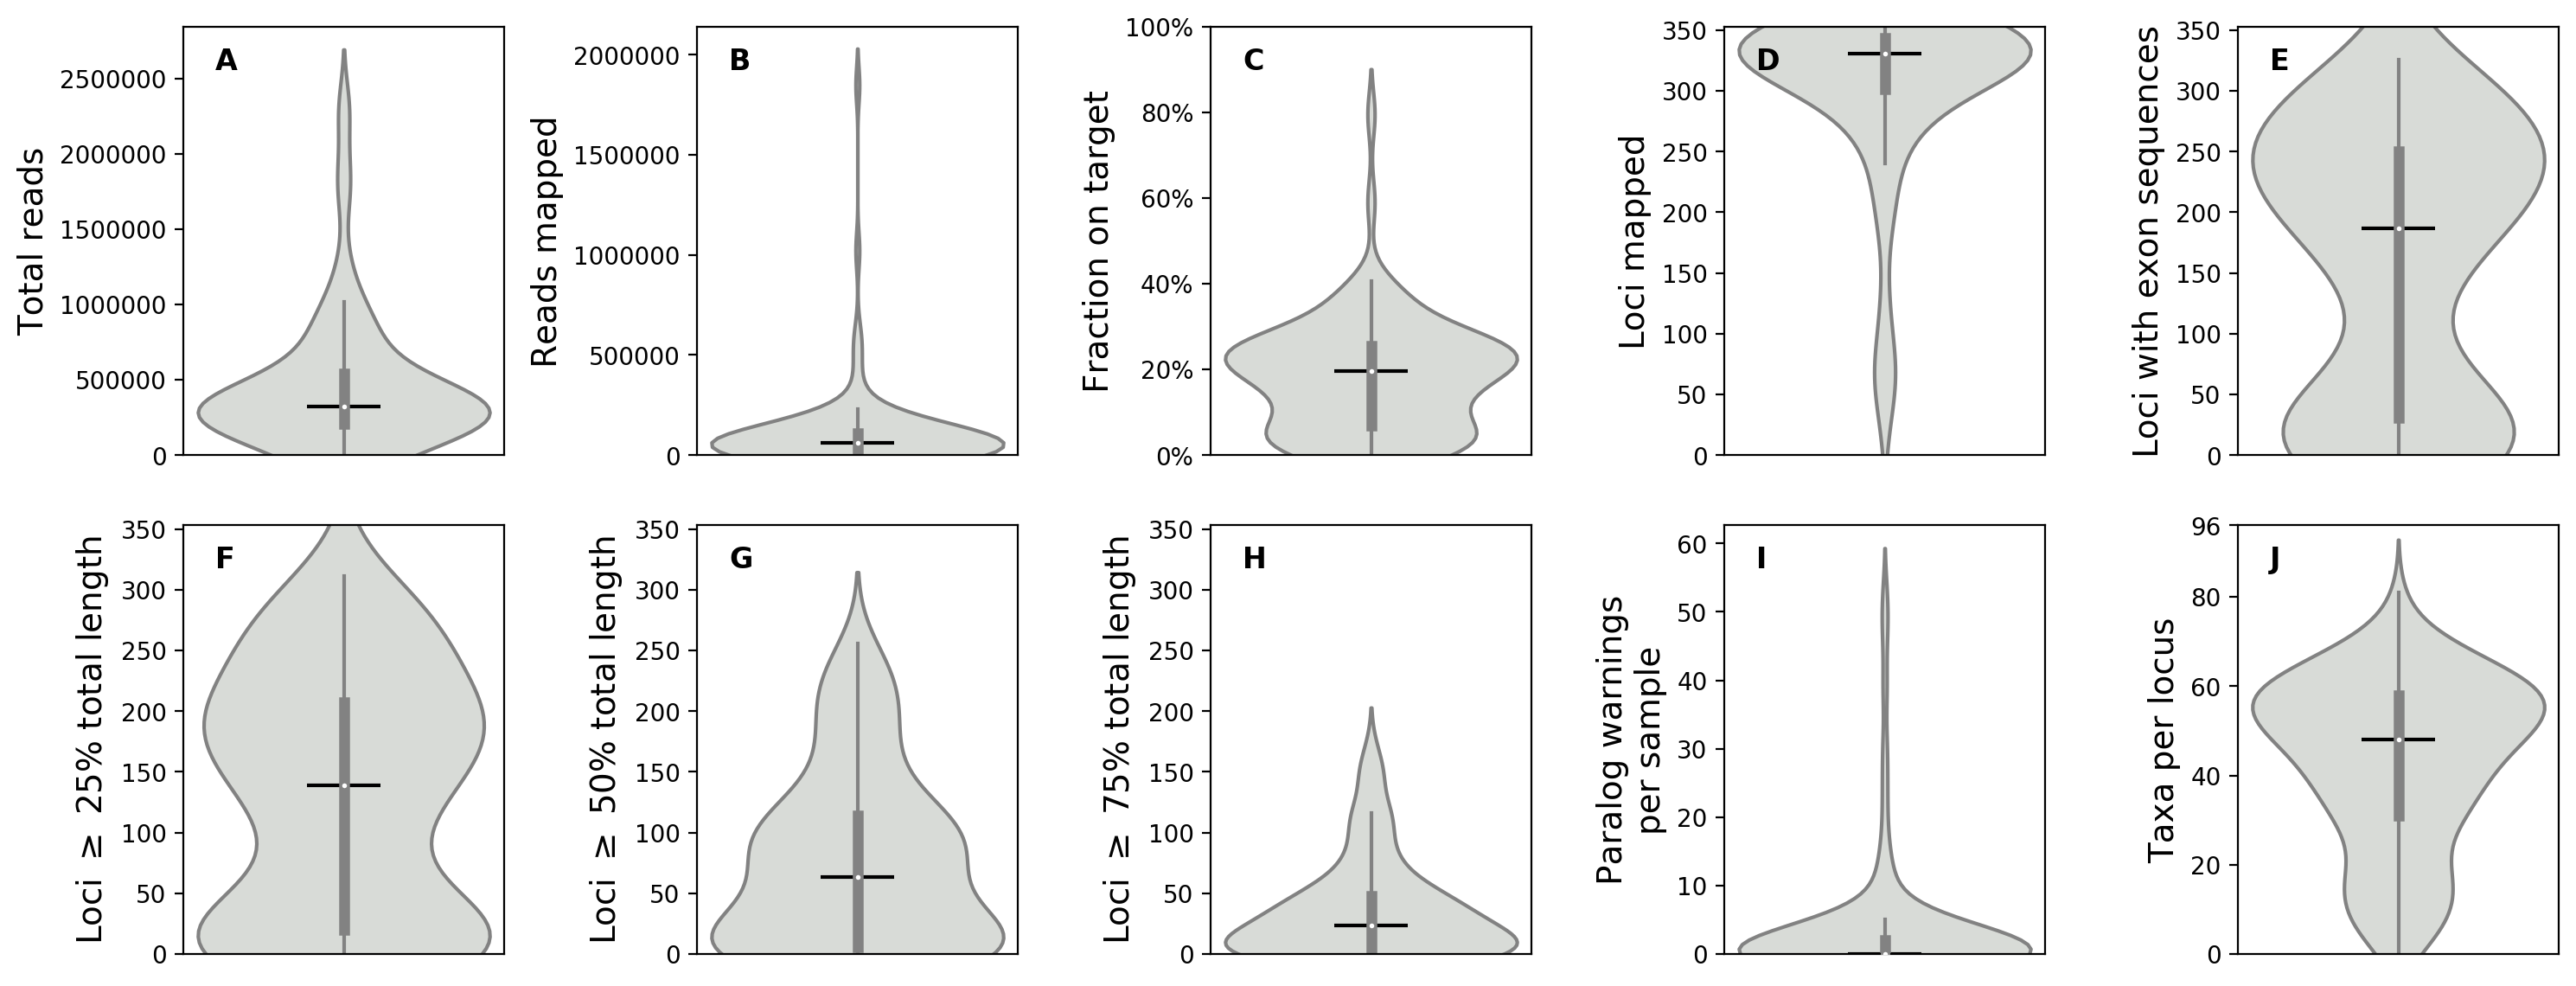

In [40]:
nrows = 2
ncols = 5

plt.style.use('default')
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))

j = 0
for i, col in enumerate(numeric_stats.columns):
    if col in ["pool", "Genesat150pct", "genus_factor", "cycles", "initial_ng_DNA", 
               "post_amp_ng_DNA", "initial_concentration", "GenesWithContigs"]:
        continue
    else:
        ax = axs.reshape(-1)[j]
        
        sns.violinplot(numeric_stats[col], inner='box', 
                       orient="v", ax = axs.reshape(-1)[j], color="xkcd:light grey")
        ax.hlines(y=numeric_stats[col].median(), xmin=-0.1, xmax=0.1, linestyle="-", color="black")
        ax.set_xticks([])

        if ax.get_ylim()[0] < 0:
            ax.set_ylim([0, ax.get_ylim()[1]])       

        if "GENES" in col.upper():
            ax.set_ylim([0, 353])
            
        if col.lower() == "numreads":
            ax.set_ylabel("Total reads", size=14)
        
        if col.lower() == "readsmapped":
            ax.set_ylabel("Reads mapped", size=14)
            
        if col.lower() == "pctontarget":
            ax.set_ylabel("Fraction on target", size=14)
            ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
            ax.set_yticklabels(["{}%".format(n) for n in [0, 20, 40, 60, 80, 100]])
        
        if col.lower() == "genesmapped":
            ax.set_ylabel("Loci mapped", size=14)
        
        if col.lower() == "geneswithcontigs":
            ax.set_ylabel("Loci with contigs", size=14)
        
        if col.lower() == "geneswithseqs":
            ax.set_ylabel("Loci with exon sequences", size=14)
            
        if col.upper().startswith("GENESAT"):
            ax.set_ylabel("Loci $\geq$ {}% total length".format(re.search("[\d]+", col)[0]), size=14)
            
        if col.lower() == "paralogwarnings":
            ax.set_ylabel("Paralog warnings\nper sample", size=14)
        
#         ax.annotate(string.ascii_uppercase[j], xy=(0.055, 0.9), xycoords="axes fraction", 
#                     weight='bold', size=12)

        j+=1

sns.violinplot(taxon_counts, inner='box', orient="v", ax = axs[1,4], color="xkcd:light grey")
axs[1,4].hlines(y=taxon_counts.median(), xmin=-0.1, xmax=0.1, linestyle="-", color="black")
axs[1,4].set_xticks([])
axs[1,4].set_ylim(0,96)
axs[1,4].set_yticks([0,20,40,60,80,96])
axs[1,4].set_yticklabels([0,20,40,60,80,96])
axs[1,4].set_ylabel("Taxa per locus", size=14)

for i, ax in enumerate(axs.flatten()):
    ax.annotate(string.ascii_uppercase[i], xy=(0.1, 0.9), xycoords="axes fraction", 
                    weight='bold', size=12)
# fig.delaxes(axs.reshape(-1)[-1])
    
plt.tight_layout()
# plt.savefig('./Figures/Statistics/FigureS1.recovery-violins.pdf', format='pdf', transparent=True, dpi=300, bbox_inches='tight')
# plt.savefig('./Figures/Statistics/FigureS1.recovery-violins.lowres.png', format='png', transparent=True, dpi=150, bbox_inches='tight')

In [895]:
taxon_counts.describe()

count    353.000000
mean      43.167139
std       19.044590
min        0.000000
25%       31.000000
50%       48.000000
75%       58.000000
max       81.000000
dtype: float64

In the figure above, violin plots show kernel density smoothed distributions with median (black horizontal bar), inner quartile range (thick vertical grey line), and 1.5x inner quartile range (thin grey line). In subplots **K**, **L**, and **N**, dashed red lines show suggested minimum initial DNA concentration, initial total DNA mass, and post-amplification DNA mass.

Now to look into the correlation between sample/library prep and sequencing/assembly metrics. 

In [118]:
numeric_stats = numeric_stats.drop(labels=["Genesat150pct"], axis=1)

In [119]:
numeric_stats = numeric_stats.drop(labels=["genus_factor"], axis=1)

In [120]:
corrmat = numeric_stats.corr()

/Users/iangilman/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


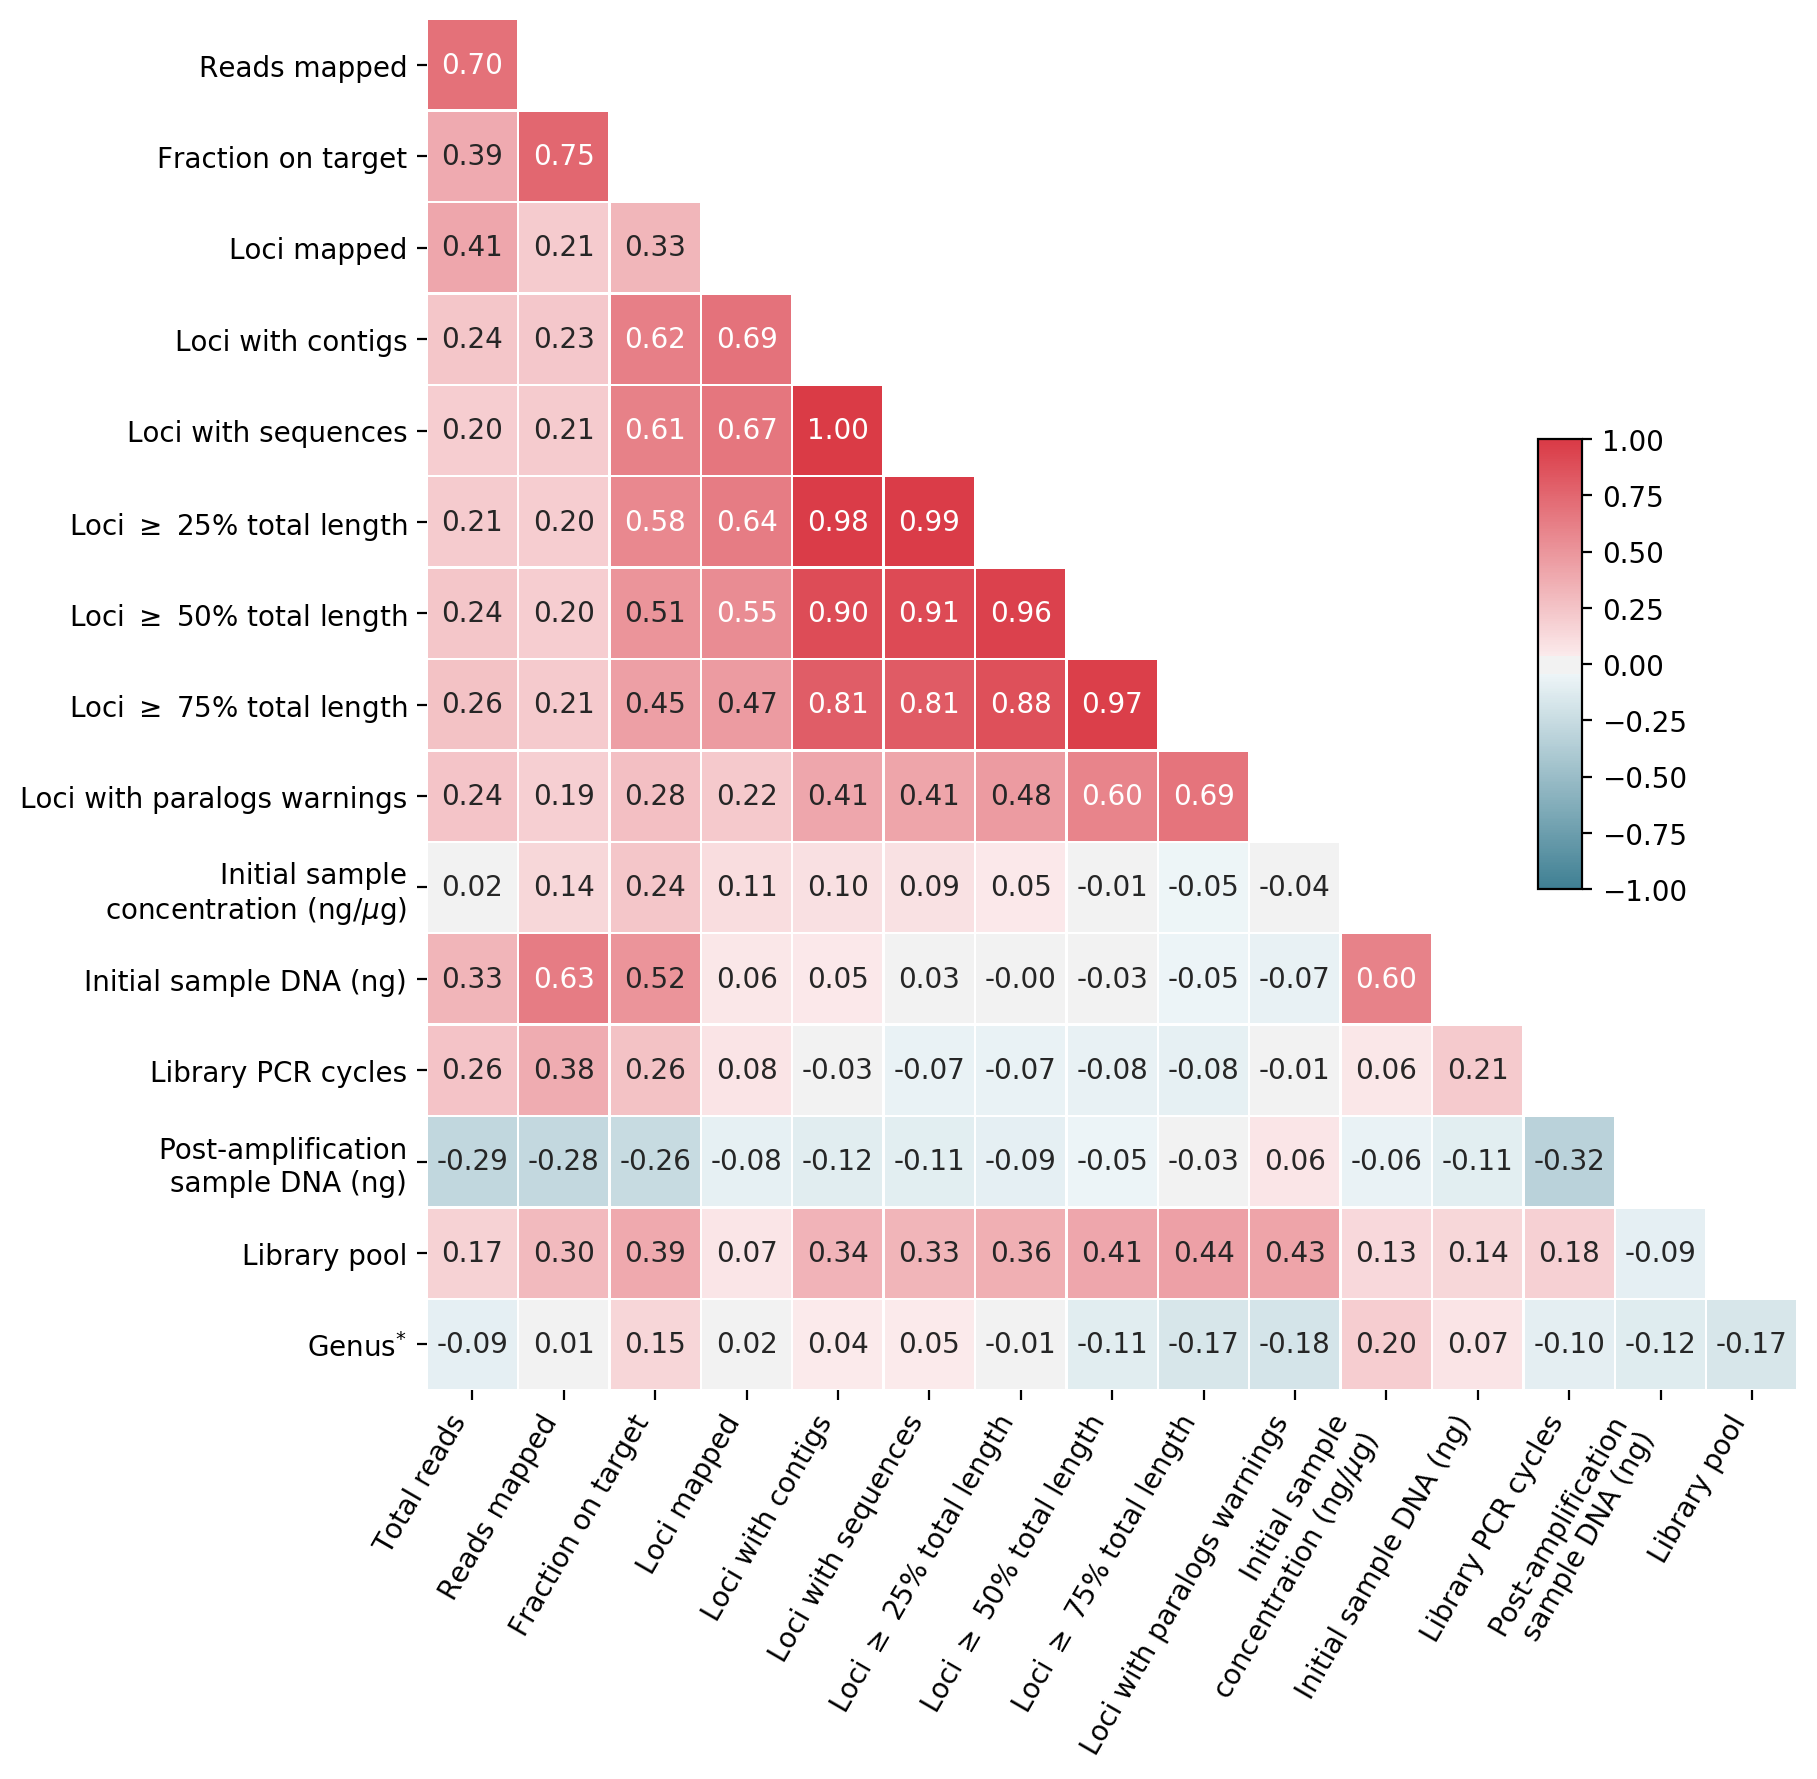

In [121]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrmat, dtype=np.bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(h_neg=220, h_pos=10, as_cmap=True)

sns.heatmap(corrmat, mask=mask, cmap=cmap, vmin=-1.0, vmax=1.0, center=0, square=True, linewidths=.5, 
            cbar_kws={"shrink": .5}, annot=True, fmt=".2f", cbar=False)

ax.set_xticks(np.linspace(start=0.5, stop=15.5, num=16))
ax.set_yticks(np.linspace(start=0.5, stop=15.5, num=16))
ax.set_xticklabels([name_display_dict[c] for c in corrmat.columns][:-1], rotation=60, ha="right")
ax.set_yticklabels([name_display_dict[c] for c in corrmat.columns])

ax.set_xlim([0,15])
ax.set_ylim([16,1])

ax2 = fig.add_axes([0.75, 0.5, 0.02, 0.25])
norm = colors.Normalize(vmin=-1.0, vmax=1.0)
colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='vertical')

plt.tight_layout()

# plt.savefig('./Figures/Metadata_corrmat.pdf', format='pdf', transparent=True, dpi=300)

So it looks like there is maybe some relationship between the library pools and what we recovered, but I'll need to test this explicitly.

## Effects of library pooling

A useful guide to choosing tests is on the [`pingouin` site](https://pingouin-stats.org/guidelines.html). To test for pool differences we need to first establish whether or not these measurements are normally distributed. If they are normal, we can simply use one-way ANOVA to test for differences in pool means. If the data are *non*-normal, we'll use the [Kruskal-Wallis test](http://www.biostathandbook.com/kruskalwallis.html) to test if there are differences between library pools. However, as Dr. McDonald notes in his discussion of the Kruskal-Wall test, there are a few things we should make us cautious of using this over one-way ANOVA:
    - one-way ANOVA is not very sensitive to deviations from normality
    - the Kruskal-Wallis test will transform our data from nominal to ranked
    - the Kruskal-Wallis test assumes equal group variation (homoscedasticity)
        - Welch's ANOVA is an extension of ANOVA when data are hetroscedastic
    - non-parametric tests are usually less powerful than parametric tests

So using parametric, one-way ANOVA (or Welch's) may actually be a better choice than non-parametric tests if we are not severely violating assumptions. To decide which route to go I'll further test if the standard deviations within pools are similar enough under log-transformations.

In [981]:
log_numeric = pd.DataFrame([np.array(np.log10(numeric_stats["NumReads"])),
                            np.array(np.log10(numeric_stats["ReadsMapped"])),
                            np.array(np.log10(numeric_stats["PctOnTarget"]*100)),
                            np.array(np.log10(numeric_stats["initial_concentration"])),
                            np.array(np.log10(numeric_stats["initial_ng_DNA"])),
                            np.array(np.log10(numeric_stats["GenesWithSeqs"])),
                            numeric_stats["pool"]]).T
log_numeric.columns = ["NumReads", "ReadsMapped", "PctOnTarget", "initial_concentration", 
                       "initial_ng_DNA", "GenesWithSeqs", "pool"]
log_numeric = log_numeric.replace(-np.inf, 0)

### Reads per sample

In [950]:
print("Normality test")
normal_test(numeric_stats["NumReads"], alpha=0.01, log=False)

print("\nBarlett's test")
barlett = stats.bartlett(numeric_stats.loc[numeric_stats["pool"]==1]["NumReads"],
                         numeric_stats.loc[numeric_stats["pool"]==2]["NumReads"],
                         numeric_stats.loc[numeric_stats["pool"]==3]["NumReads"],
                         numeric_stats.loc[numeric_stats["pool"]==4]["NumReads"],
                         numeric_stats.loc[numeric_stats["pool"]==5]["NumReads"],
                         numeric_stats.loc[numeric_stats["pool"]==6]["NumReads"],
                         numeric_stats.loc[numeric_stats["pool"]==7]["NumReads"],
                         numeric_stats.loc[numeric_stats["pool"]==8]["NumReads"])
print(barlett)

print("\nLog-transformed normality test")
normal_test(log_numeric["NumReads"], alpha=0.01, log=False)

print("\nLog-transformed Barlett's test")
barlett = stats.bartlett(log_numeric.loc[log_numeric["pool"]==1]["NumReads"],
                         log_numeric.loc[log_numeric["pool"]==2]["NumReads"],
                         log_numeric.loc[log_numeric["pool"]==3]["NumReads"],
                         log_numeric.loc[log_numeric["pool"]==4]["NumReads"],
                         log_numeric.loc[log_numeric["pool"]==5]["NumReads"],
                         log_numeric.loc[log_numeric["pool"]==6]["NumReads"],
                         log_numeric.loc[log_numeric["pool"]==7]["NumReads"],
                         log_numeric.loc[log_numeric["pool"]==8]["NumReads"])
print(barlett)

print("\nLog-transformed Welch's ANOVA")
pg.print_table(pg.welch_anova(dv="NumReads", between="pool", data=log_numeric))

print("\nLog-transformed Krusckal-Wallis test")
pg.print_table(pg.kruskal(data=log_numeric, dv="NumReads", between="pool"))

Normality test
p = 7.51003e-14
The null hypothesis can be rejected. Data are not-normal.

Barlett's test
BartlettResult(statistic=28.732798779925478, pvalue=0.00016185003304008798)

Log-transformed normality test
p = 7.75627e-11
The null hypothesis can be rejected. Data are not-normal.

Log-transformed Barlett's test
BartlettResult(statistic=20.670004278218748, pvalue=0.0042905304493452865)

Log-transformed Welch's ANOVA

ANOVA SUMMARY

Source      ddof1    ddof2      F    p-unc    np2
--------  -------  -------  -----  -------  -----
pool            7   37.163  0.412    0.889  0.041


Log-transformed Krusckal-Wallis test
Source      ddof1       H    p-unc
--------  -------  ------  -------
pool            7  10.529    0.161



- Read counts are **non-normally** distributed, whether raw or transformed
- The pools have **unequal variances** and variance is smaller when data are **log-transformed**
- **Welch's ANOVA** and **KW test** using **log-transformed** are both **non-significant**

**Therefore is does not appear that pools received unequal numbers of reads per individual.**

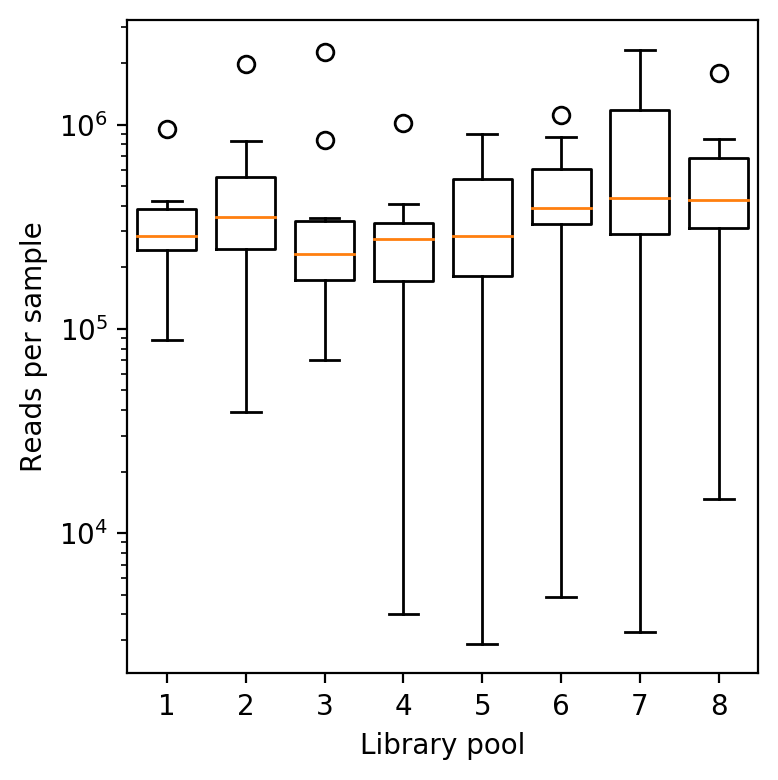

In [951]:
fig, ax = plt.subplots(figsize=(4,4))

for i in range(1,9):
    ax.boxplot(numeric_stats.loc[numeric_stats["pool"]==i]["NumReads"], widths=[0.75],
               bootstrap=100, positions=[i])

ax.semilogy()
ax.set_xlabel("Library pool")
ax.set_ylabel("Reads per sample")
plt.tight_layout()

### Reads mapped

In [599]:
print("Normality test")
normal_test(numeric_stats["ReadsMapped"], alpha=0.01, log=False)

print("\nBarlett's test")
barlett = stats.bartlett(numeric_stats.loc[numeric_stats["pool"]==1]["ReadsMapped"],
                         numeric_stats.loc[numeric_stats["pool"]==2]["ReadsMapped"],
                         numeric_stats.loc[numeric_stats["pool"]==3]["ReadsMapped"],
                         numeric_stats.loc[numeric_stats["pool"]==4]["ReadsMapped"],
                         numeric_stats.loc[numeric_stats["pool"]==5]["ReadsMapped"],
                         numeric_stats.loc[numeric_stats["pool"]==6]["ReadsMapped"],
                         numeric_stats.loc[numeric_stats["pool"]==7]["ReadsMapped"],
                         numeric_stats.loc[numeric_stats["pool"]==8]["ReadsMapped"])
print(barlett)

print("\nLog-transformed normality test")
normal_test(log_numeric["ReadsMapped"], alpha=0.01, log=False)

print("\nLog-transformed Barlett's test")
barlett = stats.bartlett(log_numeric.loc[log_numeric["pool"]==1]["ReadsMapped"],
                         log_numeric.loc[log_numeric["pool"]==2]["ReadsMapped"],
                         log_numeric.loc[log_numeric["pool"]==3]["ReadsMapped"],
                         log_numeric.loc[log_numeric["pool"]==4]["ReadsMapped"],
                         log_numeric.loc[log_numeric["pool"]==5]["ReadsMapped"],
                         log_numeric.loc[log_numeric["pool"]==6]["ReadsMapped"],
                         log_numeric.loc[log_numeric["pool"]==7]["ReadsMapped"],
                         log_numeric.loc[log_numeric["pool"]==8]["ReadsMapped"])
print(barlett)

print("\nLog-transformed Welch's ANOVA")
pg.print_table(pg.welch_anova(dv="ReadsMapped", between="pool", data=log_numeric))

print("\nLog-transformed Krusckal-Wallis test")
pg.print_table(pg.kruskal(data=log_numeric, dv="ReadsMapped", between="pool"))

Normality test
p = 8.58714e-33
The null hypothesis can be rejected. Data are not-normal.

Barlett's test
BartlettResult(statistic=192.82647434195218, pvalue=3.787197387259738e-38)

Log-transformed normality test
p = 0.00286345
The null hypothesis can be rejected. Data are not-normal.

Log-transformed Barlett's test
BartlettResult(statistic=22.48616335113795, pvalue=0.0020935397223820233)

Log-transformed Welch's ANOVA

ANOVA SUMMARY

Source      ddof1    ddof2      F    p-unc    np2
--------  -------  -------  -----  -------  -----
pool            7   36.816  8.211    0.000  0.252


Log-transformed Krusckal-Wallis test
Source      ddof1       H    p-unc
--------  -------  ------  -------
pool            7  33.419    0.000



- Reads mapped are **non-normally** distributed, whether raw or transformed
- The pools have **unequal variances** and variance is much smaller when data are **log-transformed**
- **Welch's ANOVA** and **KW test** using **log-transformed** are both **highly significant**

**Therefore, the number of mapped reads per individual is significantly different between pools.** I expect this pattern to extend to the percent of reads on target.

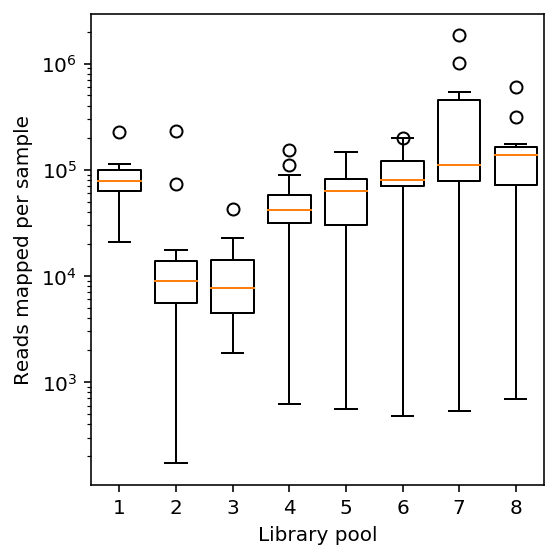

In [600]:
fig, ax = plt.subplots(figsize=(4,4))

for i in range(1,9):
    ax.boxplot(numeric_stats.loc[numeric_stats["pool"]==i]["ReadsMapped"], widths=[0.75],
               bootstrap=100, positions=[i])

ax.semilogy()
ax.set_xlabel("Library pool")
ax.set_ylabel("Reads mapped per sample")
plt.tight_layout()

### Fraction of reads on target

In [601]:
print("Normality test")
normal_test(numeric_stats["PctOnTarget"], alpha=0.01, log=False)

print("\nBarlett's test")
barlett = stats.bartlett(numeric_stats.loc[numeric_stats["pool"]==1]["PctOnTarget"],
                         numeric_stats.loc[numeric_stats["pool"]==2]["PctOnTarget"],
                         numeric_stats.loc[numeric_stats["pool"]==3]["PctOnTarget"],
                         numeric_stats.loc[numeric_stats["pool"]==4]["PctOnTarget"],
                         numeric_stats.loc[numeric_stats["pool"]==5]["PctOnTarget"],
                         numeric_stats.loc[numeric_stats["pool"]==6]["PctOnTarget"],
                         numeric_stats.loc[numeric_stats["pool"]==7]["PctOnTarget"],
                         numeric_stats.loc[numeric_stats["pool"]==8]["PctOnTarget"])
print(barlett)

print("\nLog-transformed normality test")
normal_test(log_numeric["PctOnTarget"], alpha=0.01, log=False)

print("\nLog-transformed Barlett's test")
barlett = stats.bartlett(log_numeric.loc[log_numeric["pool"]==1]["PctOnTarget"],
                         log_numeric.loc[log_numeric["pool"]==2]["PctOnTarget"],
                         log_numeric.loc[log_numeric["pool"]==3]["PctOnTarget"],
                         log_numeric.loc[log_numeric["pool"]==4]["PctOnTarget"],
                         log_numeric.loc[log_numeric["pool"]==5]["PctOnTarget"],
                         log_numeric.loc[log_numeric["pool"]==6]["PctOnTarget"],
                         log_numeric.loc[log_numeric["pool"]==7]["PctOnTarget"],
                         log_numeric.loc[log_numeric["pool"]==8]["PctOnTarget"])
print(barlett)

print("\nLog-transformed Welch's ANOVA")
pg.print_table(pg.welch_anova(dv="PctOnTarget", between="pool", data=log_numeric))

print("\nLog-transformed Krusckal-Wallis test")
pg.print_table(pg.kruskal(data=log_numeric, dv="PctOnTarget", between="pool"))

Normality test
p = 5.54648e-08
The null hypothesis can be rejected. Data are not-normal.

Barlett's test
BartlettResult(statistic=86.83575306924652, pvalue=5.515560749085978e-16)

Log-transformed normality test
p = 0.000795709
The null hypothesis can be rejected. Data are not-normal.

Log-transformed Barlett's test
BartlettResult(statistic=54.80953300460026, pvalue=1.6262326017239336e-09)

Log-transformed Welch's ANOVA

ANOVA SUMMARY

Source      ddof1    ddof2       F    p-unc    np2
--------  -------  -------  ------  -------  -----
pool            7   34.544  50.564    0.000  0.758


Log-transformed Krusckal-Wallis test
Source      ddof1       H    p-unc
--------  -------  ------  -------
pool            7  59.764    0.000



- Mapping efficiency is **non-normally** distributed, whether raw or transformed
- The pools have **unequal variances** and variance is smaller when data are **log-transformed**
- **Welch's ANOVA** and **KW test** using **log-transformed** are both **highly significant**

**Therefore, the fraction of reads on target per individual is significantly different between pools.**

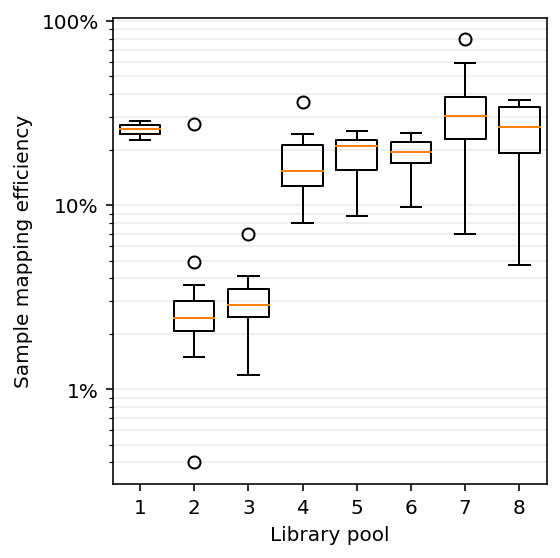

In [602]:
fig, ax = plt.subplots(figsize=(4,4))

for i in range(1,9):
    ax.boxplot(numeric_stats.loc[numeric_stats["pool"]==i]["PctOnTarget"], widths=[0.75],
               bootstrap=100, positions=[i])

ax.semilogy()
ax.set_xlabel("Library pool")
ax.set_ylabel("Sample mapping efficiency")
ax.set_yticks([0.01, 0.1, 1.0])
ax.set_yticklabels(["1%", "10%", "100%"])
ax.grid(axis='y', which='both', alpha=0.25)
plt.tight_layout()

### Genes with exon sequences

In [983]:
print("Normality test")
normal_test(numeric_stats["GenesWithSeqs"], alpha=0.01, log=False)

print("\nBarlett's test")
barlett = stats.bartlett(numeric_stats.loc[numeric_stats["pool"]==1]["GenesWithSeqs"],
                         numeric_stats.loc[numeric_stats["pool"]==2]["GenesWithSeqs"],
                         numeric_stats.loc[numeric_stats["pool"]==3]["GenesWithSeqs"],
                         numeric_stats.loc[numeric_stats["pool"]==4]["GenesWithSeqs"],
                         numeric_stats.loc[numeric_stats["pool"]==5]["GenesWithSeqs"],
                         numeric_stats.loc[numeric_stats["pool"]==6]["GenesWithSeqs"],
                         numeric_stats.loc[numeric_stats["pool"]==7]["GenesWithSeqs"],
                         numeric_stats.loc[numeric_stats["pool"]==8]["GenesWithSeqs"])
print(barlett)

print("\nLog-transformed normality test")
normal_test(log_numeric["GenesWithSeqs"], alpha=0.01, log=False)

print("\nLog-transformed Barlett's test")
barlett = stats.bartlett(log_numeric.loc[log_numeric["pool"]==1]["GenesWithSeqs"],
                         log_numeric.loc[log_numeric["pool"]==2]["GenesWithSeqs"],
                         log_numeric.loc[log_numeric["pool"]==3]["GenesWithSeqs"],
                         log_numeric.loc[log_numeric["pool"]==4]["GenesWithSeqs"],
                         log_numeric.loc[log_numeric["pool"]==5]["GenesWithSeqs"],
                         log_numeric.loc[log_numeric["pool"]==6]["GenesWithSeqs"],
                         log_numeric.loc[log_numeric["pool"]==7]["GenesWithSeqs"],
                         log_numeric.loc[log_numeric["pool"]==8]["GenesWithSeqs"])
print(barlett)

print("\nLog-transformed Welch's ANOVA")
pg.print_table(pg.welch_anova(dv="GenesWithSeqs", between="pool", data=log_numeric))

print("\nKrusckal-Wallis test")
pg.print_table(pg.kruskal(data=numeric_stats, dv="GenesWithSeqs", between="pool"))

Normality test
p = 6.51721e-47
The null hypothesis can be rejected. Data are not-normal.

Barlett's test
BartlettResult(statistic=29.9067871939113, pvalue=9.877160785385423e-05)

Log-transformed normality test
p = 4.41935e-05
The null hypothesis can be rejected. Data are not-normal.

Log-transformed Barlett's test
BartlettResult(statistic=49.314547650618884, pvalue=1.968715779621416e-08)

Log-transformed Welch's ANOVA

ANOVA SUMMARY

Source      ddof1    ddof2       F    p-unc    np2
--------  -------  -------  ------  -------  -----
pool            7   33.590  15.360    0.000  0.279


Krusckal-Wallis test
Source      ddof1       H    p-unc
--------  -------  ------  -------
pool            7  37.959    0.000



- The number of genes with exon sequence is **non-normally** distributed, whether raw or transformed
    - It is closer to normal when raw
- The pools have **unequal variances** and variance is smaller when data are **log-transformed**
    - Pools are more homoscedastic when log transformed
- **Welch's ANOVA** using **log-transformed** data and **KW test** using **raw** data are both **highly significant**

**Therefore, the number of genes with contigs per individual is significantly different between pools.**

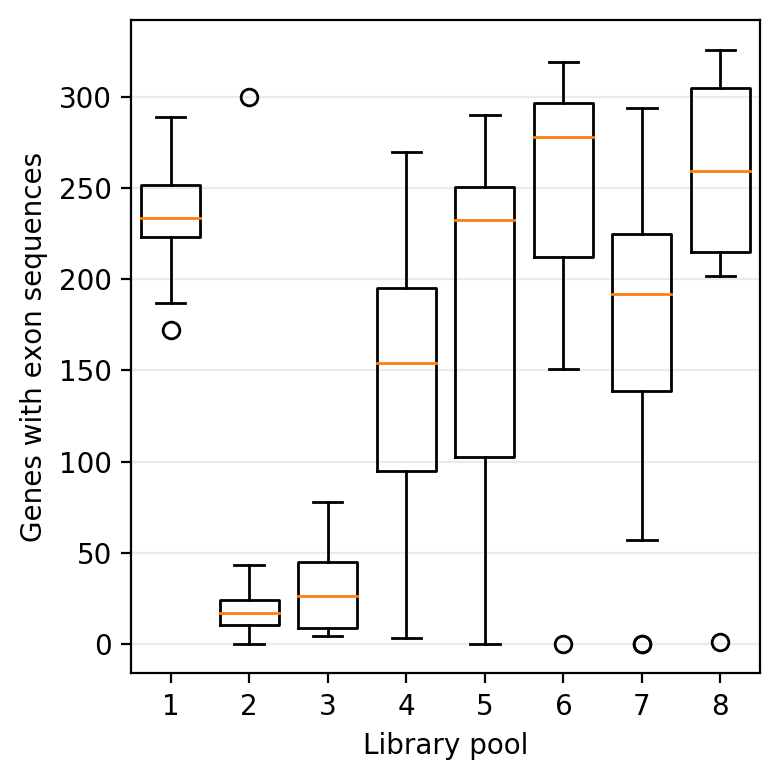

In [984]:
fig, ax = plt.subplots(figsize=(4,4))

for i in range(1,9):
    ax.boxplot(numeric_stats.loc[numeric_stats["pool"]==i]["GenesWithSeqs"], widths=[0.75],
               bootstrap=100, positions=[i])

ax.set_xlabel("Library pool")
ax.set_ylabel("Genes with exon sequences")
ax.grid(axis='y', which='both', alpha=0.25)

plt.tight_layout()

In [1086]:
?plt.boxplot

We found the `ReadsMapped`, `PctOnTarget`, and `GenesWithContigs` varied between pools. Now we can run a Dunn's test to find where population means differ.

In [985]:
dunn_readsmapped = skph.posthoc_dunn(log_numeric, val_col='ReadsMapped', group_col="pool", p_adjust=None, sort=True)
dunn_ontarget = skph.posthoc_dunn(log_numeric, val_col='PctOnTarget', group_col="pool", p_adjust=None, sort=True)
dunn_gwc = skph.posthoc_dunn(numeric_stats, val_col='GenesWithSeqs', group_col="pool", p_adjust=None, sort=True)

/Users/iangilman/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


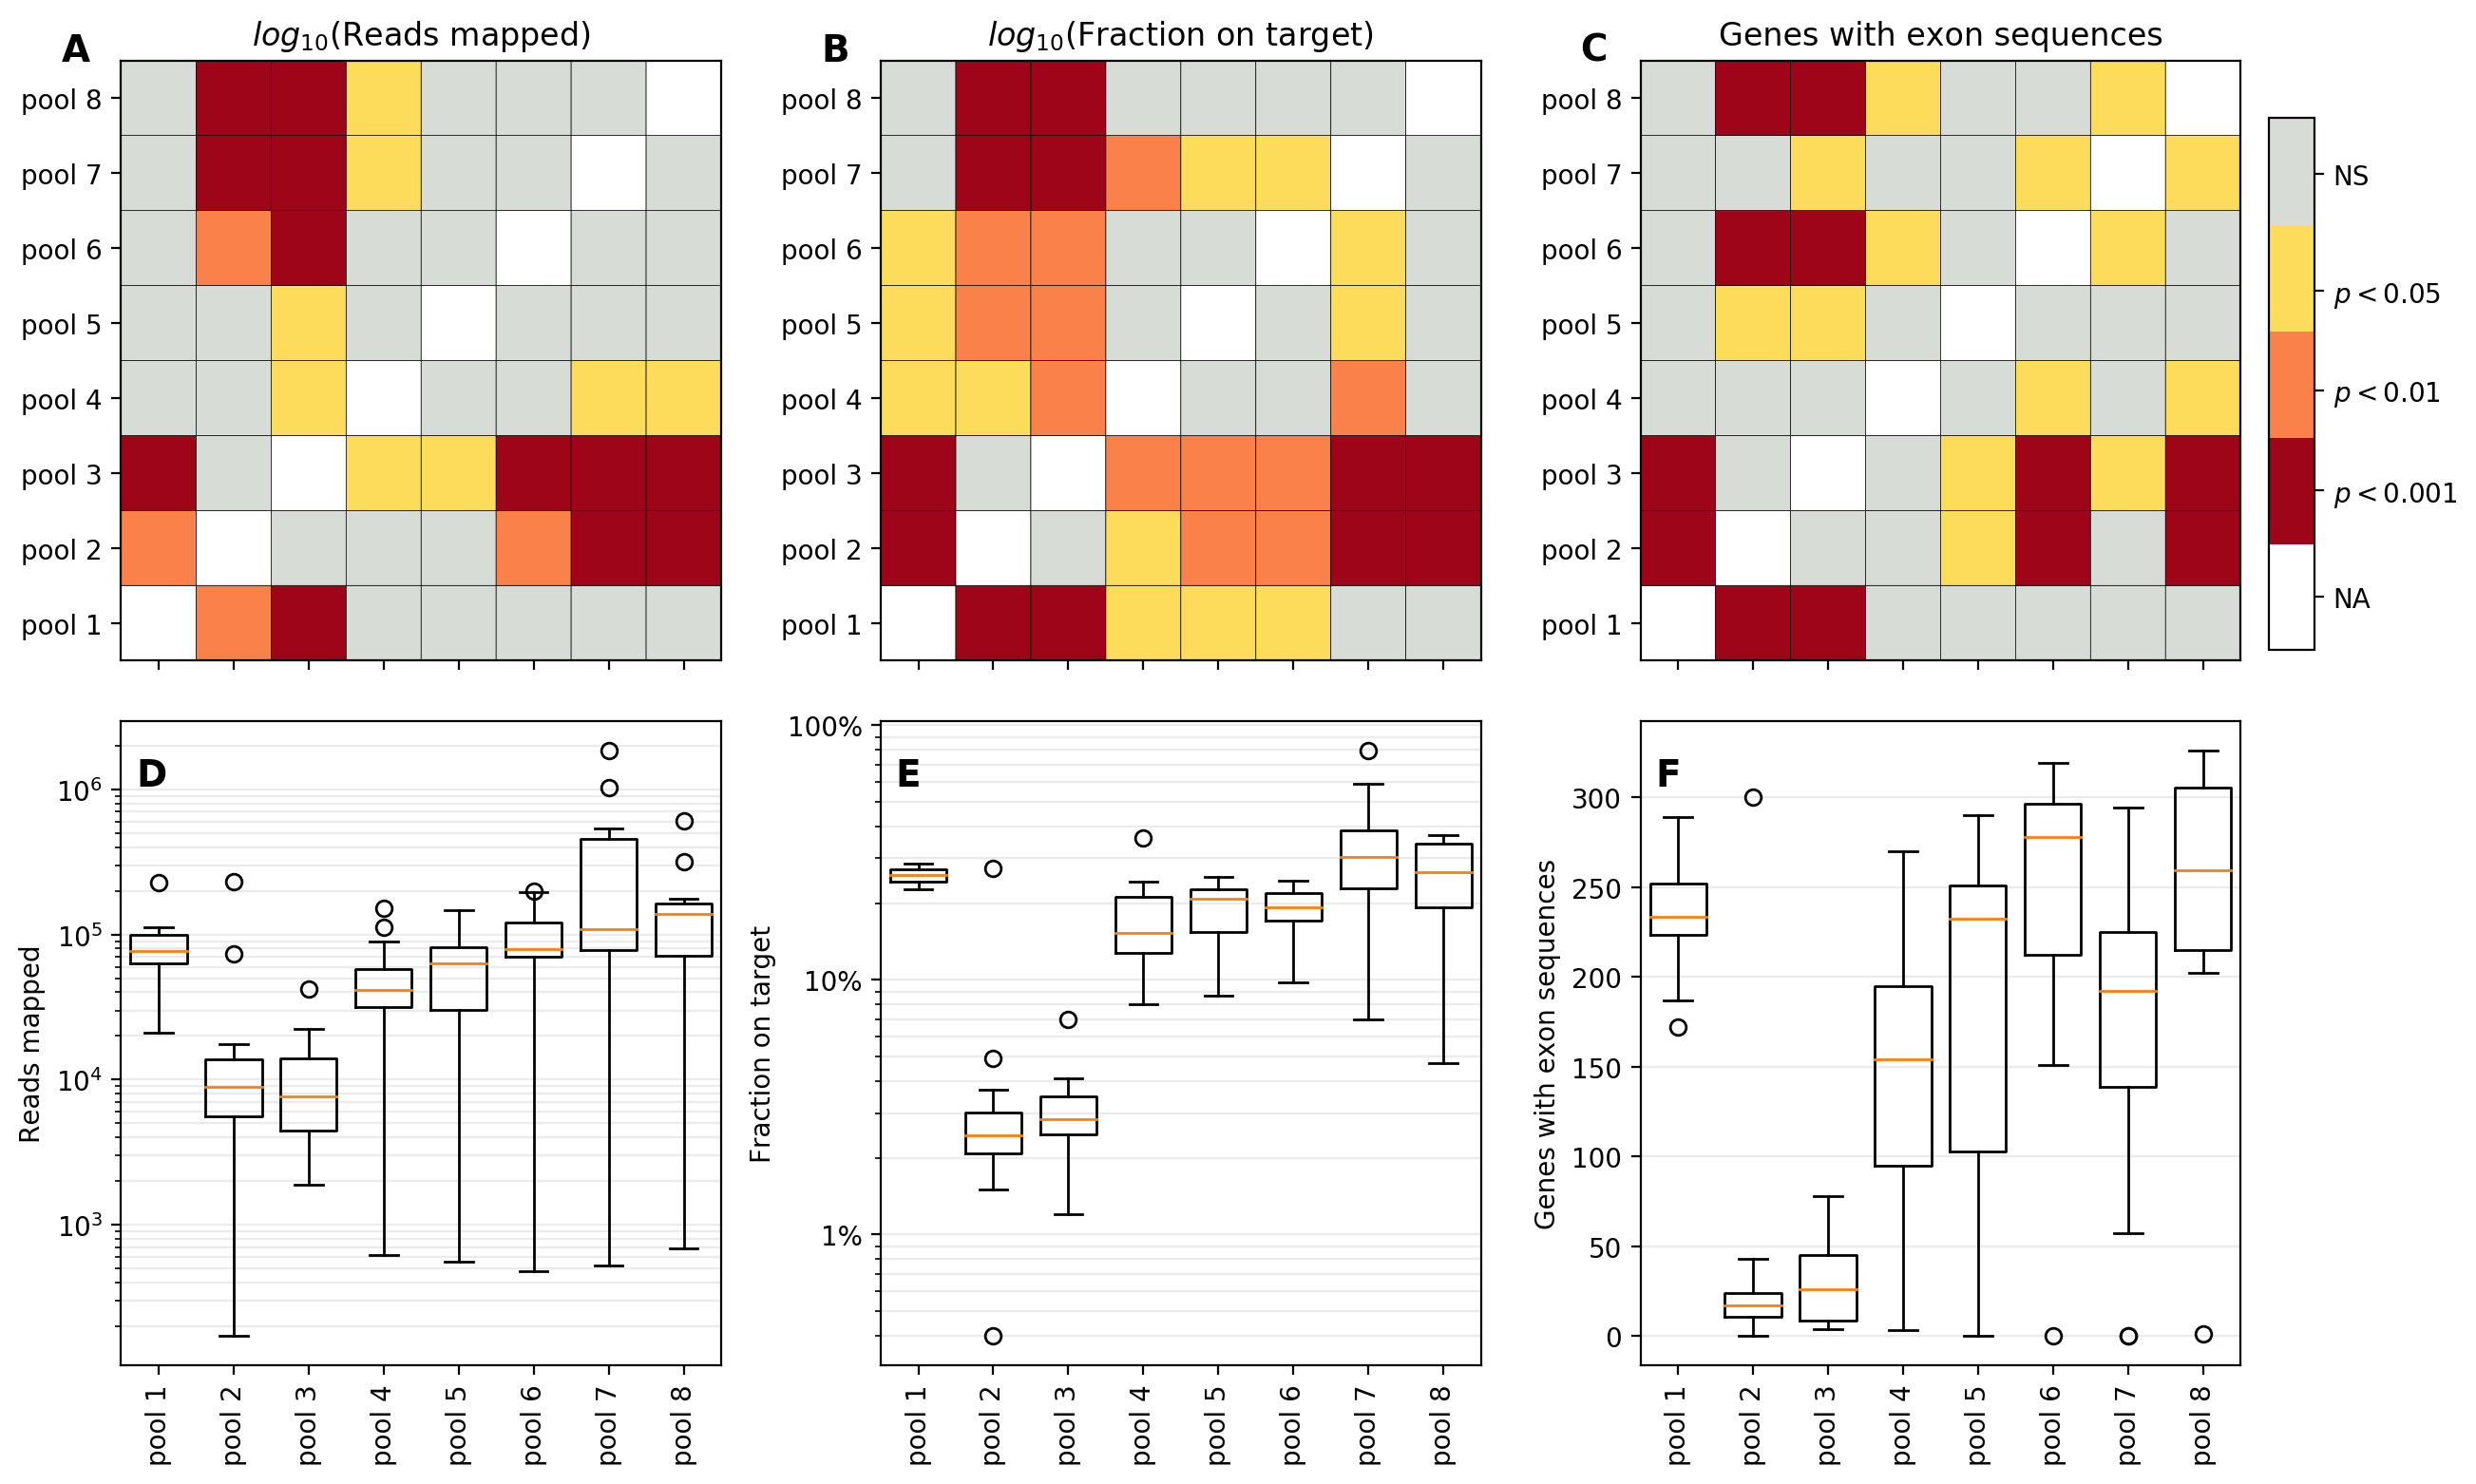

In [1000]:
plt.style.use('default')
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,8), sharex=True)

cmaplist = ["white", "xkcd:carmine", "xkcd:orangish", "xkcd:light gold", "xkcd:light grey"]
cmap = colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = [-1, 0.0, 0.001, 0.01, 0.05, 1.0]
norm = colors.BoundaryNorm(bounds, cmap.N)

pmap_rm = ax[0,0].pcolor(dunn_readsmapped, cmap=cmap, norm=norm, edgecolors="black")
pmap_ot = ax[0,1].pcolor(dunn_ontarget, cmap=cmap, norm=norm, edgecolors="black")
pmap_gwc = ax[0,2].pcolor(dunn_gwc, cmap=cmap, norm=norm, edgecolors="black")

cax = fig.add_axes([ax[0,-1].get_position().x1+0.1, ax[0,-1].get_position().y0+0.025, 
                    0.02, ax[0,-1].get_position().height])
cbar = plt.colorbar(pmap_gwc, cax=cax, cmap=cmap, norm=norm, boundaries=bounds, ticks=[-0.5, 0.0005, 0.005, 0.025, 0.5])
cbar.ax.set_yticklabels(["NA", "$p<0.001$", "$p<0.01$", "$p<0.05$", "NS"])

for i in range(1,9):
    ax[1,0].boxplot(numeric_stats.loc[numeric_stats["pool"]==i]["ReadsMapped"], widths=[0.75],
               bootstrap=1000, positions=[i-0.5])
    ax[1,1].boxplot(numeric_stats.loc[numeric_stats["pool"]==i]["PctOnTarget"], widths=[0.75],
               bootstrap=1000, positions=[i-0.5])
    ax[1,2].boxplot(numeric_stats.loc[numeric_stats["pool"]==i]["GenesWithSeqs"], widths=[0.75],
               bootstrap=1000, positions=[i-0.5])

ax[0,0].set_title("$log_{10}($Reads mapped$)$")
ax[0,1].set_title("$log_{10}($Fraction on target$)$")
ax[0,2].set_title("Genes with exon sequences")

for i in range(3):
    ax[0,i].set_aspect('equal','box')

    ax[0,i].set_yticks(np.linspace(0.5, 7.5, 8))
    ax[0,i].set_yticklabels(["pool {}".format(i) for i in range(1,9)])
    
    ax[1,i].grid(axis="y", which="both", alpha=0.25)
    ax[1,i].set_xticks(np.linspace(0.5, 7.5, 8))
    ax[1,i].set_xticklabels(["pool {}".format(i) for i in range(1,9)], rotation=90)

for i, axis in enumerate(ax.flatten()):
    if i<3:
        axis.annotate(string.ascii_uppercase[i], xy=(-0.1, 1.), xycoords="axes fraction", 
                        weight='bold', size=14)
    else:
        axis.annotate(string.ascii_uppercase[i], xy=(0.025, 0.90), xycoords="axes fraction", 
                        weight='bold', size=14)

ax[1,0].semilogy()
ax[1,1].semilogy()
ax[1,1].set_yticks([0.01, 0.1, 1.0])
ax[1,1].set_yticklabels(["1%", "10%", "100%"])

ax[1,0].set_ylabel("Reads mapped")
ax[1,1].set_ylabel("Fraction on target")
ax[1,2].set_ylabel("Genes with exon sequences")

plt.tight_layout()
# plt.savefig("./Figures/Statistics/Pooling-Read-Stats.pdf", format='pdf', dpi=300, transparent=True, bbox_inches="tight")
# plt.savefig("./Figures/Statistics/Pooling-Read-Stats.lowres.png", format="png", dpi=150, 
#             transparent=True, bbox_inches="tight")

## Effects of sample quality
We were able to detect batch effects (i.e. there was variance between sample pools), and now I'll see if there are individual effects (i.e. artifacts of sample quality). Namely, I'll be looking at in initial sample concentration and DNA mass. Low concentration samples are likely lower quality extractions, and the library preparation required a minimum of 200ng DNA. 

### Initial sample concentration
Are these differences in the sample quality of different pools that might have caused the differential success?

In [875]:
print("Normality test")
normal_test(numeric_stats["initial_concentration"], alpha=0.01, log=False)

print("\nBarlett's test")
barlett = stats.bartlett(numeric_stats.loc[numeric_stats["pool"]==1]["initial_concentration"],
                         numeric_stats.loc[numeric_stats["pool"]==2]["initial_concentration"],
                         numeric_stats.loc[numeric_stats["pool"]==3]["initial_concentration"],
                         numeric_stats.loc[numeric_stats["pool"]==4]["initial_concentration"],
                         numeric_stats.loc[numeric_stats["pool"]==5]["initial_concentration"],
                         numeric_stats.loc[numeric_stats["pool"]==6]["initial_concentration"],
                         numeric_stats.loc[numeric_stats["pool"]==7]["initial_concentration"],
                         numeric_stats.loc[numeric_stats["pool"]==8]["initial_concentration"])
print(barlett)

print("\nLog-transformed normality test")
normal_test(log_numeric["initial_concentration"], alpha=0.01, log=False)

print("\nLog-transformed Barlett's test")
barlett = stats.bartlett(log_numeric.loc[log_numeric["pool"]==1]["initial_concentration"],
                         log_numeric.loc[log_numeric["pool"]==2]["initial_concentration"],
                         log_numeric.loc[log_numeric["pool"]==3]["initial_concentration"],
                         log_numeric.loc[log_numeric["pool"]==4]["initial_concentration"],
                         log_numeric.loc[log_numeric["pool"]==5]["initial_concentration"],
                         log_numeric.loc[log_numeric["pool"]==6]["initial_concentration"],
                         log_numeric.loc[log_numeric["pool"]==7]["initial_concentration"],
                         log_numeric.loc[log_numeric["pool"]==8]["initial_concentration"])
print(barlett)

print("\nLog-transformed one-way ANOVA")
pg.print_table(pg.anova(dv="initial_concentration", between="pool", data=log_numeric))

Normality test
p = 1.1734e-25
The null hypothesis can be rejected. Data are not-normal.

Barlett's test
BartlettResult(statistic=111.83472705722245, pvalue=3.821079293201155e-21)

Log-transformed normality test
p = 0.140895
The null hypothesis cannot be rejected. Data are normal.

Log-transformed Barlett's test
BartlettResult(statistic=9.31802093153212, pvalue=0.23062263124918897)

Log-transformed one-way ANOVA

ANOVA SUMMARY

Source      ddof1    ddof2      F    p-unc    np2
--------  -------  -------  -----  -------  -----
pool            7       88  2.976    0.008  0.191



The **log-transformed data are normal with relatively equal variances**, so I applied a standard **one-way ANOVA** on the log-transformed data. This showed that there are indeed **differences in group means**.

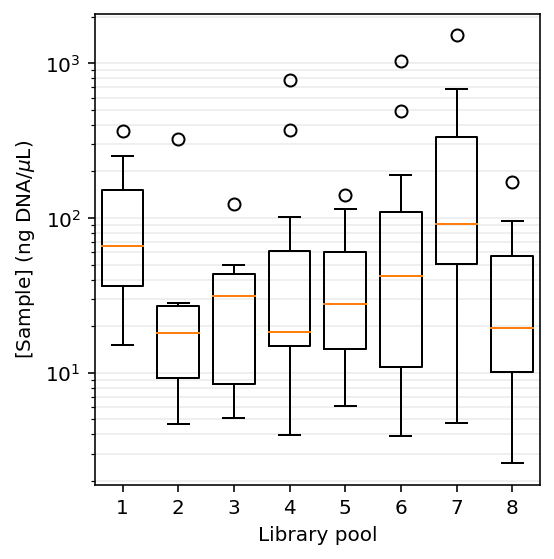

In [873]:
fig, ax = plt.subplots(figsize=(4,4))

for i in range(1,9):
    ax.boxplot(numeric_stats.loc[numeric_stats["pool"]==i]["initial_concentration"], widths=[0.75],
               bootstrap=100, positions=[i])
ax.semilogy()
ax.set_xlabel("Library pool")
ax.set_ylabel("[Sample] (ng DNA/$\mu$L)")
ax.grid(axis='y', which='both', alpha=0.25)

plt.tight_layout()

In [876]:
print("Normality test")
normal_test(numeric_stats["initial_ng_DNA"], alpha=0.01, log=False)

print("\nBarlett's test")
barlett = stats.bartlett(numeric_stats.loc[numeric_stats["pool"]==1]["initial_ng_DNA"],
                         numeric_stats.loc[numeric_stats["pool"]==2]["initial_ng_DNA"],
                         numeric_stats.loc[numeric_stats["pool"]==3]["initial_ng_DNA"],
                         numeric_stats.loc[numeric_stats["pool"]==4]["initial_ng_DNA"],
                         numeric_stats.loc[numeric_stats["pool"]==5]["initial_ng_DNA"],
                         numeric_stats.loc[numeric_stats["pool"]==6]["initial_ng_DNA"],
                         numeric_stats.loc[numeric_stats["pool"]==7]["initial_ng_DNA"],
                         numeric_stats.loc[numeric_stats["pool"]==8]["initial_ng_DNA"])
print(barlett)

print("\nLog-transformed normality test")
normal_test(log_numeric["initial_ng_DNA"], alpha=0.01, log=False)

print("\nLog-transformed Barlett's test")
barlett = stats.bartlett(log_numeric.loc[log_numeric["pool"]==1]["initial_ng_DNA"],
                         log_numeric.loc[log_numeric["pool"]==2]["initial_ng_DNA"],
                         log_numeric.loc[log_numeric["pool"]==3]["initial_ng_DNA"],
                         log_numeric.loc[log_numeric["pool"]==4]["initial_ng_DNA"],
                         log_numeric.loc[log_numeric["pool"]==5]["initial_ng_DNA"],
                         log_numeric.loc[log_numeric["pool"]==6]["initial_ng_DNA"],
                         log_numeric.loc[log_numeric["pool"]==7]["initial_ng_DNA"],
                         log_numeric.loc[log_numeric["pool"]==8]["initial_ng_DNA"])
print(barlett)

print("\nLog-transformed one-way ANOVA")
pg.print_table(pg.anova(dv="initial_ng_DNA", between="pool", data=log_numeric))

Normality test
p = 1.19722e-24
The null hypothesis can be rejected. Data are not-normal.

Barlett's test
BartlettResult(statistic=226.92822669808749, pvalue=2.23008372289206e-45)

Log-transformed normality test
p = 0.166484
The null hypothesis cannot be rejected. Data are normal.

Log-transformed Barlett's test
BartlettResult(statistic=14.431658708033856, pvalue=0.044015397410147816)

Log-transformed one-way ANOVA

ANOVA SUMMARY

Source      ddof1    ddof2      F    p-unc    np2
--------  -------  -------  -----  -------  -----
pool            7       88  4.532    0.000  0.265



The **log-transformed data are normal with relatively equal variances** ($p>0.01$), so I applied a standard **one-way ANOVA** on the log-transformed data. This showed that there are indeed **differences in group means**.

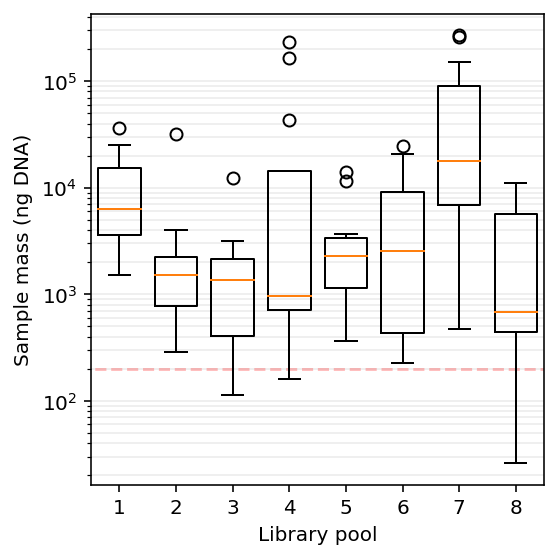

In [880]:
fig, ax = plt.subplots(figsize=(4,4))

for i in range(1,9):
    ax.boxplot(numeric_stats.loc[numeric_stats["pool"]==i]["initial_ng_DNA"], widths=[0.75],
               bootstrap=100, positions=[i])
ax.semilogy()
ax.hlines(y=200, xmin=0, xmax=10, color="red", alpha=0.25, linestyle="--")
ax.set_xlabel("Library pool")
ax.set_ylabel("Sample mass (ng DNA)")
ax.grid(axis='y', which='both', alpha=0.25)
ax.set_xlim(0.5, 8.5)

plt.tight_layout()

Since we used standard ANOVAs, we can apply post-hoc Tukey HSD to identify group differences.

In [1002]:
tukey_conc = skph.posthoc_tukey(a=log_numeric, val_col="initial_concentration", group_col="pool", sort=True)
tukey_mass = skph.posthoc_tukey(a=log_numeric, val_col="initial_ng_DNA", group_col="pool", sort=True)

/Users/iangilman/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


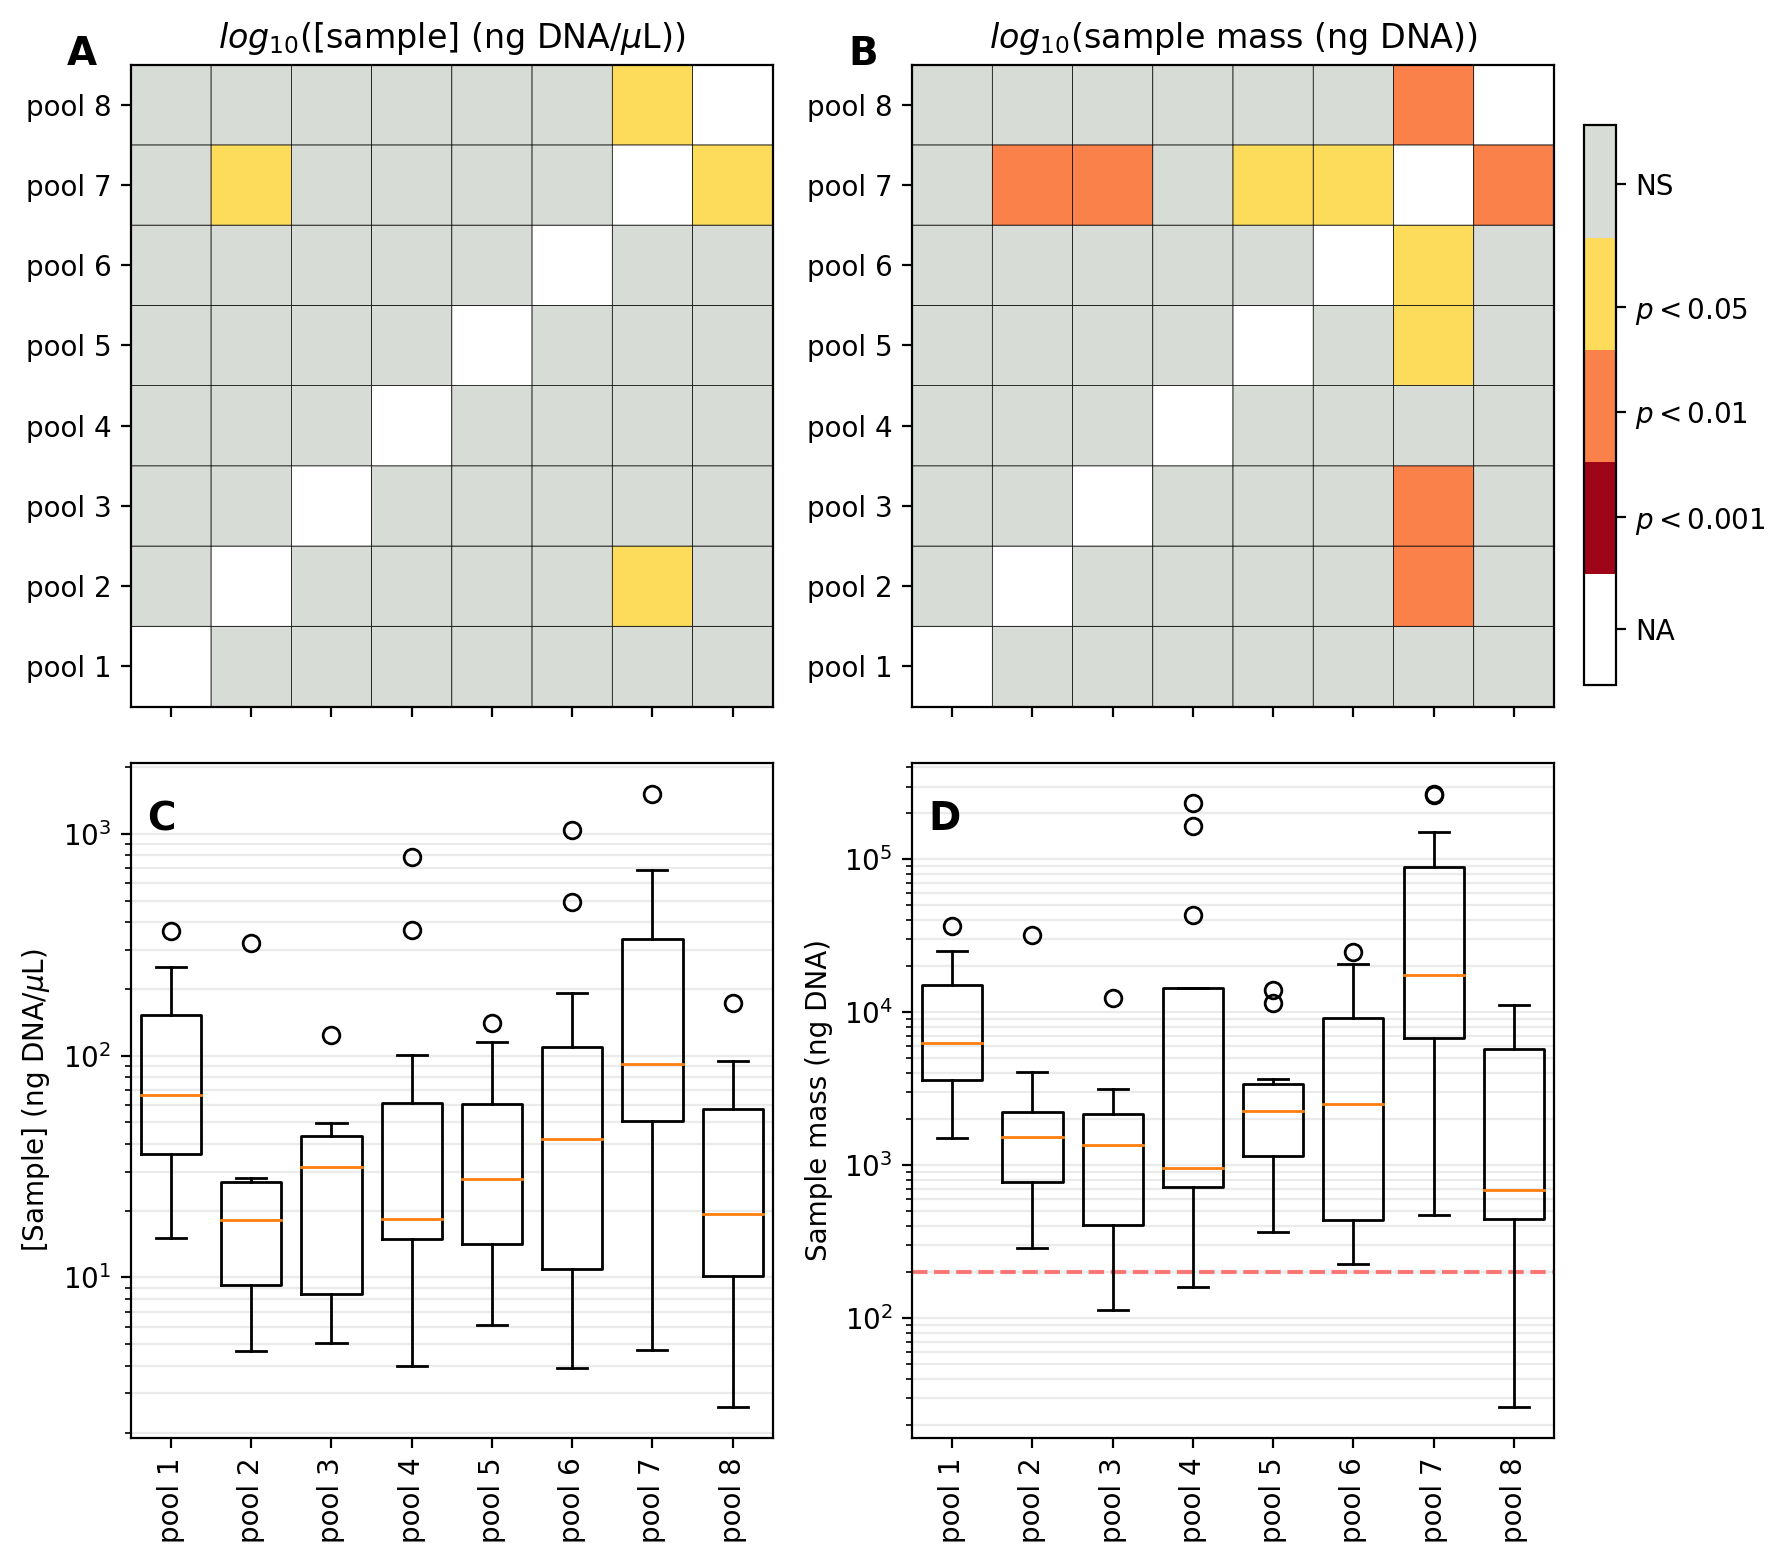

In [1005]:
plt.style.use('default')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8), sharex=True)

cmaplist = ["white", "xkcd:carmine", "xkcd:orangish", "xkcd:light gold", "xkcd:light grey"]
cmap = colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = [-1, 0.0, 0.001, 0.01, 0.05, 1.0]
norm = colors.BoundaryNorm(bounds, cmap.N)

pmap_conc = ax[0,0].pcolor(tukey_conc, cmap=cmap, norm=norm, edgecolors="black")
pmap_mass = ax[0,1].pcolor(tukey_mass, cmap=cmap, norm=norm, edgecolors="black")

cax = fig.add_axes([ax[0,-1].get_position().x1+0.1, ax[0,-1].get_position().y0+0.025, 
                    0.02, ax[0,-1].get_position().height])
cbar = plt.colorbar(pmap_mass, cax=cax, cmap=cmap, norm=norm, boundaries=bounds, 
                    ticks=[-0.5, 0.0005, 0.005, 0.025, 0.5])
cbar.ax.set_yticklabels(["NA", "$p<0.001$", "$p<0.01$", "$p<0.05$", "NS"])

for i in range(1,9):
    ax[1,0].boxplot(numeric_stats.loc[numeric_stats["pool"]==i]["initial_concentration"], widths=[0.75],
               bootstrap=100, positions=[i-0.5])
    ax[1,1].boxplot(numeric_stats.loc[numeric_stats["pool"]==i]["initial_ng_DNA"], widths=[0.75],
               bootstrap=100, positions=[i-0.5])
ax[1,1].hlines(y=200, xmin=0, xmax=10, color="red", alpha=0.5, linestyle="--")

ax[0,0].set_title("$log_{10}$([sample] (ng DNA/$\mu$L))")
ax[0,1].set_title("$log_{10}$(sample mass (ng DNA))")

for i in range(2):
    ax[0,i].set_aspect('equal','box')

    ax[0,i].set_yticks(np.linspace(0.5, 7.5, 8))
    ax[0,i].set_yticklabels(["pool {}".format(i) for i in range(1,9)])
    
    ax[1,i].grid(axis="y", which="both", alpha=0.25)
    ax[1,i].set_xticks(np.linspace(0.5, 7.5, 8))
    ax[1,i].set_xticklabels(["pool {}".format(i) for i in range(1,9)], rotation=90)
    ax[1,i].set_xlim(0, 8)

for i, axis in enumerate(ax.flatten()):
    if i<2:
        axis.annotate(string.ascii_uppercase[i], xy=(-0.1, 1.), xycoords="axes fraction", 
                        weight='bold', size=14)
    else:
        axis.annotate(string.ascii_uppercase[i], xy=(0.025, 0.90), xycoords="axes fraction", 
                        weight='bold', size=14)
ax[1,0].semilogy()
ax[1,1].semilogy()

ax[1,0].set_ylabel("[Sample] (ng DNA/$\mu$L)")
ax[1,1].set_ylabel("Sample mass (ng DNA)")

plt.tight_layout()
# plt.savefig("./Figures/Statistics/Pooling-Quality-Stats.pdf", format='pdf', dpi=300, transparent=True, bbox_inches="tight")
# plt.savefig("./Figures/Statistics/Pooling-Quality-Stats.lowres.png", format='png', dpi=150, transparent=True, bbox_inches="tight")

So there are only a few pools that differ in sample quality. It seems unlikely, but perhaps the differences in sample mass are related the differential success of some of the library pools. If this is the case, we expect there to be a relationship between sample quality and read statistics that lead to overall lower or highr performance of particular libraries. To do this, I'll run a few regressions.

In [733]:
X = log_numeric["initial_concentration"]
y = log_numeric["ReadsMapped"]
X = sm.add_constant(X)

mod_ic = sm.OLS(y, X).fit()
mod_ic = mod_ic.get_robustcov_results()
print(mod_ic.summary())

                            OLS Regression Results                            
Dep. Variable:            ReadsMapped   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     3.878
Date:                Tue, 02 Jun 2020   Prob (F-statistic):             0.0519
Time:                        15:41:44   Log-Likelihood:                -110.50
No. Observations:                  96   AIC:                             225.0
Df Residuals:                      94   BIC:                             230.1
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     4.20

/Users/iangilman/miniconda3/envs/python3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


So it doesn't look like the number of reads mapped is related to the initial concentration because the slope is not significantly different from 0.

### Initial sample mass

In [706]:
print("Normality test")
normal_test(numeric_stats["initial_ng_DNA"], alpha=0.01, log=False)

print("\nLog-transformed normality test")
normal_test(log_numeric["initial_ng_DNA"], alpha=0.01, log=False)

Normality test
p = 1.19722e-24
The null hypothesis can be rejected. Data are not-normal.

Log-transformed normality test
p = 0.166484
The null hypothesis cannot be rejected. Data are normal.


(3.5857142578455057, 0.1664838237522241)

Again, we'll go ahead with the log-transformed data.

In [989]:
X = log_numeric["initial_ng_DNA"]
X = sm.add_constant(X)

y_nr = log_numeric["NumReads"]
y_rm = log_numeric["ReadsMapped"]
y_ot = log_numeric["PctOnTarget"]
y_gwc = log_numeric["GenesWithSeqs"]

nr_mass = sm.OLS(y_nr, X).fit().get_robustcov_results()
rm_mass = sm.OLS(y_rm, X).fit().get_robustcov_results()
ot_mass = sm.OLS(y_ot, X).fit().get_robustcov_results()
gwc_mass = sm.OLS(y_gwc, X).fit().get_robustcov_results()

In [990]:
print(nr_mass.summary2())
print(rm_mass.summary2())
print(ot_mass.summary2())
print(gwc_mass.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     -0.011  
Dependent Variable: NumReads         AIC:                168.6545
Date:               2020-07-29 12:54 BIC:                173.7832
No. Observations:   96               Log-Likelihood:     -82.327 
Df Model:           1                F-statistic:        0.008784
Df Residuals:       94               Prob (F-statistic): 0.926   
R-squared:          0.000            Scale:              0.33231 
------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025  0.975]
------------------------------------------------------------------
const           5.4190    0.2499  21.6862  0.0000   4.9228  5.9151
initial_ng_DNA  0.0068    0.0727   0.0937  0.9255  -0.1376  0.1512
-----------------------------------------------------------------
Omnibus:             46.663       Durbin-Watson:          2.218  
Prob(Omnibus):       0

### Initial sample concentration

In [992]:
X = log_numeric["initial_concentration"]
X = sm.add_constant(X)

y_nr = log_numeric["NumReads"]
y_rm = log_numeric["ReadsMapped"]
y_ot = log_numeric["PctOnTarget"]
y_gwc = log_numeric["GenesWithSeqs"]

nr_conc = sm.OLS(y_nr, X).fit().get_robustcov_results()
rm_conc = sm.OLS(y_rm, X).fit().get_robustcov_results()
ot_conc = sm.OLS(y_ot, X).fit().get_robustcov_results()
gwc_conc = sm.OLS(y_gwc, X).fit().get_robustcov_results()

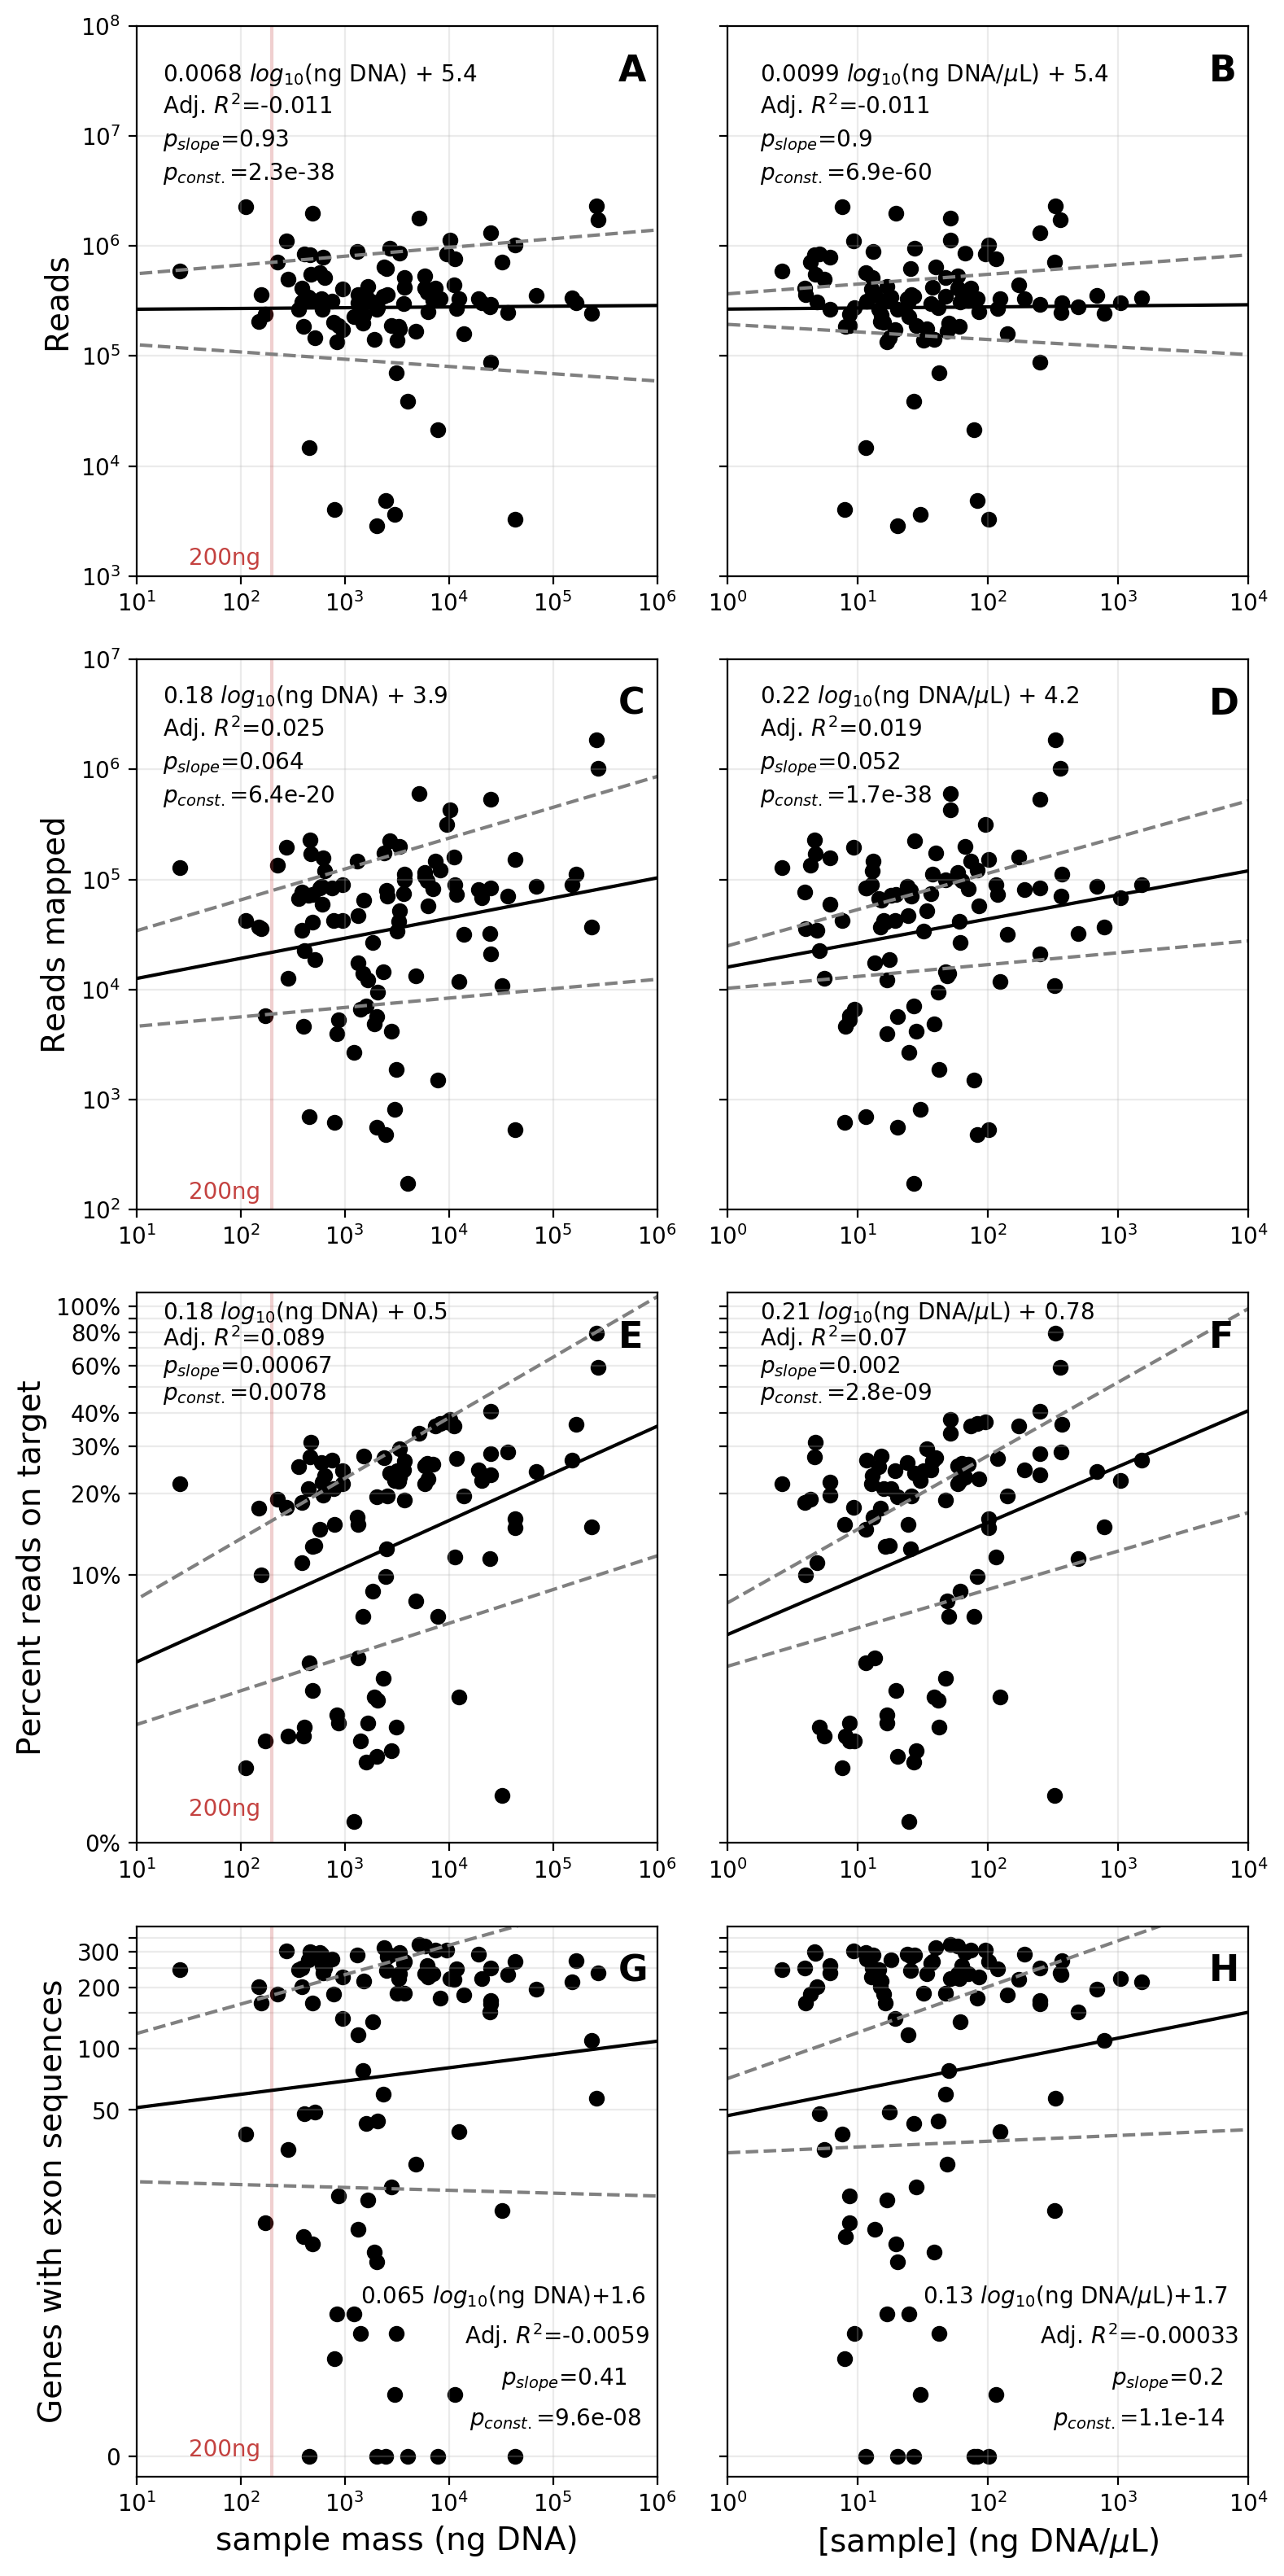

In [1085]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(8,16), sharey='row')


intercept, slope = nr_mass.params
intercept_stderr, slope_stderr = nr_mass.bse
intercept_p, slope_p = nr_mass.pvalues
adjRsq = nr_mass.rsquared_adj
domain=np.linspace(0, 10, 1000)
ax[0,0].scatter(x=log_numeric["initial_ng_DNA"], y=log_numeric["NumReads"], color="black")
ax[0,0].plot(domain, intercept + (slope*domain), color="black")
ax[0,0].plot(domain, (intercept + intercept_stderr) + ((slope+slope_stderr)*domain), color="grey", linestyle="--")
ax[0,0].plot(domain, (intercept - intercept_stderr) + ((slope-slope_stderr)*domain), color="grey", linestyle="--")

ax[0,0].text(x=1.25, y=7.5, s="{:1.2} {} + {:1.2}".format(slope, "$log_{10}$(ng DNA)", intercept))
ax[0,0].text(x=1.25, y=7.2, s="Adj. {}={:1.2}".format("$R^2$", adjRsq))
ax[0,0].text(x=1.25, y=6.9, s="{}={:1.2}".format("$p_{slope}$", slope_p))
ax[0,0].text(x=1.25, y=6.6, s="{}={:1.2}".format("$p_{const.}$", intercept_p))

intercept, slope = rm_mass.params
intercept_stderr, slope_stderr = rm_mass.bse
intercept_p, slope_p = rm_mass.pvalues
adjRsq = rm_mass.rsquared_adj
ax[1,0].scatter(x=log_numeric["initial_ng_DNA"], y=log_numeric["ReadsMapped"], color="black")
ax[1,0].plot(domain, intercept + (slope*domain), color="black")
ax[1,0].plot(domain, (intercept + intercept_stderr) + ((slope+slope_stderr)*domain), color="grey", linestyle="--")
ax[1,0].plot(domain, (intercept - intercept_stderr) + ((slope-slope_stderr)*domain), color="grey", linestyle="--")

ax[1,0].text(x=1.25, y=6.6, s="{:1.2} {} + {:1.2}".format(slope, "$log_{10}$(ng DNA)", intercept))
ax[1,0].text(x=1.25, y=6.3, s="Adj. {}={:1.2}".format("$R^2$", adjRsq))
ax[1,0].text(x=1.25, y=6.0, s="{}={:1.2}".format("$p_{slope}$", slope_p))
ax[1,0].text(x=1.25, y=5.7, s="{}={:1.2}".format("$p_{const.}$", intercept_p))

intercept, slope = ot_mass.params
intercept_stderr, slope_stderr = ot_mass.bse
intercept_p, slope_p = ot_mass.pvalues
adjRsq = ot_mass.rsquared_adj
ax[2,0].scatter(x=log_numeric["initial_ng_DNA"], y=log_numeric["PctOnTarget"], color="black")
ax[2,0].plot(domain, intercept + (slope*domain), color="black")
ax[2,0].plot(domain, (intercept + intercept_stderr) + ((slope+slope_stderr)*domain), color="grey", linestyle="--")
ax[2,0].plot(domain, (intercept - intercept_stderr) + ((slope-slope_stderr)*domain), color="grey", linestyle="--")

ax[2,0].text(x=1.25, y=1.95, s="{:1.2} {} + {:1.2}".format(slope, "$log_{10}$(ng DNA)", intercept))
ax[2,0].text(x=1.25, y=1.85, s="Adj. {}={:1.2}".format("$R^2$", adjRsq))
ax[2,0].text(x=1.25, y=1.75, s="{}={:1.2}".format("$p_{slope}$", slope_p))
ax[2,0].text(x=1.25, y=1.65, s="{}={:1.2}".format("$p_{const.}$", intercept_p))

intercept, slope = gwc_mass.params
intercept_stderr, slope_stderr = gwc_mass.bse
intercept_p, slope_p = gwc_mass.pvalues
adjRsq = gwc_mass.rsquared_adj
ax[3,0].scatter(x=log_numeric["initial_ng_DNA"], y=log_numeric["GenesWithSeqs"], color="black")
ax[3,0].plot(domain, intercept + (slope*domain), color="black")
ax[3,0].plot(domain, (intercept + intercept_stderr) + ((slope+slope_stderr)*domain), color="grey", linestyle="--")
ax[3,0].plot(domain, (intercept - intercept_stderr) + ((slope-slope_stderr)*domain), color="grey", linestyle="--")
# ax[3,0].hlines(y=np.log10(353), xmin=0, xmax=6, color="green", alpha=0.5, linestyle="-")

ax[3,0].text(x=3.15, y=0.75, s="{:1.2} {}+{:1.2}".format(slope, "$log_{10}$(ng DNA)", intercept))
ax[3,0].text(x=4.15, y=0.55, s="Adj. {}={:1.2}".format("$R^2$", adjRsq))
ax[3,0].text(x=4.5, y=0.35, s="{}={:1.2}".format("$p_{slope}$", slope_p))
ax[3,0].text(x=4.2, y=0.15, s="{}={:1.2}".format("$p_{const.}$", intercept_p))
# ax[3,0].text(x=5.5, y=np.log10(400), s="353", color="green")

intercept, slope = nr_conc.params
intercept_stderr, slope_stderr = nr_conc.bse
intercept_p, slope_p = nr_conc.pvalues
adjRsq = nr_conc.rsquared_adj
domain=np.linspace(0, 10, 1000)
ax[0,1].scatter(x=log_numeric["initial_concentration"], y=log_numeric["NumReads"], color="black")
ax[0,1].plot(domain, intercept + (slope*domain), color="black")
ax[0,1].plot(domain, (intercept + intercept_stderr) + ((slope+slope_stderr)*domain), color="grey", linestyle="--")
ax[0,1].plot(domain, (intercept - intercept_stderr) + ((slope-slope_stderr)*domain), color="grey", linestyle="--")

ax[0,1].text(x=0.25, y=7.5, s="{:1.2} {} + {:1.2}".format(slope, "$log_{10}$(ng DNA/$\mu$L)", intercept))
ax[0,1].text(x=0.25, y=7.2, s="Adj. {}={:1.2}".format("$R^2$", adjRsq))
ax[0,1].text(x=0.25, y=6.9, s="{}={:1.2}".format("$p_{slope}$", slope_p))
ax[0,1].text(x=0.25, y=6.6, s="{}={:1.2}".format("$p_{const.}$", intercept_p))

intercept, slope = rm_conc.params
intercept_stderr, slope_stderr = rm_conc.bse
intercept_p, slope_p = rm_conc.pvalues
adjRsq = rm_conc.rsquared_adj
ax[1,1].scatter(x=log_numeric["initial_concentration"], y=log_numeric["ReadsMapped"], color="black")
ax[1,1].plot(domain, intercept + (slope*domain), color="black")
ax[1,1].plot(domain, (intercept + intercept_stderr) + ((slope+slope_stderr)*domain), color="grey", linestyle="--")
ax[1,1].plot(domain, (intercept - intercept_stderr) + ((slope-slope_stderr)*domain), color="grey", linestyle="--")

ax[1,1].text(x=0.25, y=6.6, s="{:1.2} {} + {:1.2}".format(slope, "$log_{10}$(ng DNA/$\mu$L)", intercept))
ax[1,1].text(x=0.25, y=6.3, s="Adj. {}={:1.2}".format("$R^2$", adjRsq))
ax[1,1].text(x=0.25, y=6.0, s="{}={:1.2}".format("$p_{slope}$", slope_p))
ax[1,1].text(x=0.25, y=5.7, s="{}={:1.2}".format("$p_{const.}$", intercept_p))

intercept, slope = ot_conc.params
intercept_stderr, slope_stderr = ot_conc.bse
intercept_p, slope_p = ot_conc.pvalues
adjRsq = ot_conc.rsquared_adj
ax[2,1].scatter(x=log_numeric["initial_concentration"], y=log_numeric["PctOnTarget"], color="black")
ax[2,1].plot(domain, intercept + (slope*domain), color="black")
ax[2,1].plot(domain, (intercept + intercept_stderr) + ((slope+slope_stderr)*domain), color="grey", linestyle="--")
ax[2,1].plot(domain, (intercept - intercept_stderr) + ((slope-slope_stderr)*domain), color="grey", linestyle="--")

ax[2,1].text(x=0.25, y=1.95, s="{:1.2} {} + {:1.2}".format(slope, "$log_{10}$(ng DNA/$\mu$L)", intercept))
ax[2,1].text(x=0.25, y=1.85, s="Adj. {}={:1.2}".format("$R^2$", adjRsq))
ax[2,1].text(x=0.25, y=1.75, s="{}={:1.2}".format("$p_{slope}$", slope_p))
ax[2,1].text(x=0.25, y=1.65, s="{}={:1.2}".format("$p_{const.}$", intercept_p))

intercept, slope = gwc_conc.params
intercept_stderr, slope_stderr = gwc_conc.bse
intercept_p, slope_p = gwc_conc.pvalues
adjRsq = gwc_conc.rsquared_adj
ax[3,1].scatter(x=log_numeric["initial_concentration"], y=log_numeric["GenesWithSeqs"], color="black")
ax[3,1].plot(domain, intercept + (slope*domain), color="black")
ax[3,1].plot(domain, (intercept + intercept_stderr) + ((slope+slope_stderr)*domain), color="grey", linestyle="--")
ax[3,1].plot(domain, (intercept - intercept_stderr) + ((slope-slope_stderr)*domain), color="grey", linestyle="--")
# ax[3,1].hlines(y=np.log10(353), xmin=0, xmax=4, color="green", alpha=0.5, linestyle="-")

ax[3,1].text(x=1.5, y=0.75, s="{:1.2} {}+{:1.2}".format(slope, "$log_{10}$(ng DNA/$\mu$L)", intercept))
ax[3,1].text(x=2.4, y=0.55, s="Adj. {}={:1.2}".format("$R^2$", adjRsq))
ax[3,1].text(x=2.95, y=0.35, s="{}={:1.2}".format("$p_{slope}$", slope_p))
ax[3,1].text(x=2.5, y=0.15, s="{}={:1.2}".format("$p_{const.}$", intercept_p))
# ax[3,1].text(x=3.0, y=np.log10(400), s="353", color="green")


ax[0,0].set_ylim(3, 8)
ax[1,0].set_ylim(2, 7)
ax[2,0].set_ylim(0, 2.05)
ax[3,0].set_ylim(-.1, np.log10(400))

for i in range(4):
    ax[i,0].set_xlim(1, 6)
    ax[i,0].set_xticks(range(1,7))
    ax[i,0].set_xticklabels(["$10^{}$".format(j) for j in range(1,7)])
    
    ax[i,1].set_xlim(0, 4)
    ax[i,1].set_xticks(range(5))
    ax[i,1].set_xticklabels(["$10^{}$".format(j) for j in range(5)])
    
    ax[i,0].text(x=1.5, y=ax[i,0].get_ylim()[0]+0.1, s="200ng", color="xkcd:reddish")
    
    
ax[0,0].set_yticks(range(3,9))
ax[0,0].set_yticklabels(["$10^{}$".format(j) for j in range(3,9)])   
ax[1,0].set_yticks(range(2,8))
ax[1,0].set_yticklabels(["$10^{}$".format(j) for j in range(2,8)])
ax[2,0].set_yticks([0]+[np.log10(d) for d in np.linspace(10,100,10)])
ax[2,0].set_yticklabels(['0%','10%','20%','30%','40%','','60%','','80%','','100%'])
ax[3,0].set_yticks([0]+[np.log10(d) for d in np.linspace(50, 350, 7)])
ax[3,0].set_yticklabels([0, 50, 100, '', 200, '', 300, ''])
    
ax[3,0].set_xlabel("sample mass (ng DNA)", size=14)
ax[3,1].set_xlabel("[sample] (ng DNA/$\mu$L)", size=14)

ax[0,0].set_ylabel("Reads", size=14)
ax[1,0].set_ylabel("Reads mapped", size=14)
ax[2,0].set_ylabel("Percent reads on target", size=14)
ax[3,0].set_ylabel("Genes with exon sequences", size=14)


for i, axis in enumerate(ax.flatten()):
    axis.annotate(string.ascii_uppercase[i], xy=(0.925, 0.90), xycoords="axes fraction", 
                    weight='bold', size=16)

for i in range(4):
    ax[i,0].grid(axis='both', which='major', alpha=0.25)
    ax[i,1].grid(axis='both', which='major', alpha=0.25)
    ax[i,0].vlines(x=np.log10(200), ymin=-0.5, ymax=8, color="xkcd:reddish", alpha=0.25)
    
plt.tight_layout()
# plt.savefig("./Figures/Statistics/SampleQualityRegression.pdf", format='pdf', dpi=300, transparent=True, bbox_inches='tight')
# plt.savefig("./Figures/Statistics/SampleQualityRegression.lowres.png", format='png', dpi=150, transparent=True, bbox_inches='tight')

We can see in the plots above that 
- $R^2$ values are low, so initial sample quality does not explain much of the total variance
- The only significant slopes were 
    - $log_{10}($enrichment$)$~$log_{10}($sample mass$)$
    - $log_{10}($enrichment$)$~$log_{10}($[sample]$)$
    - Suggesting that increased sample quality does slighlty increase the fraction of reads on target, but this does not appear to translate to more genes with contigs.